# data loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
import datetime, math
from tqdm.notebook import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as accuracy

In [4]:
torch.manual_seed(1)

In [5]:
from models.utils import *

In [6]:
names = ['GAZP', 'ROSN', 'LKOH', 'USD000000TOD', 'ICE.BRN', 'IMOEX', 'comex.GC']
dates = ['131101_151031', '151101_171031', '171101_191031']
data_5m = load_data(names, dates, path='data/')

In [7]:
idx = ['gazp', 'rosn', 'lkoh', 'usd', 'brn', 'imoex', 'gld']
data_5m = prepare_data(data_5m, idx)
data_day = make_daily_data(data_5m, idx)

In [8]:
data_5m = data_5m[2:].set_index('date')

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Sharing both axes')
axs[0].plot(x, y ** 2)
axs[1].plot(x, 0.3 * y, 'o')
axs[2].plot(x, y, '+')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

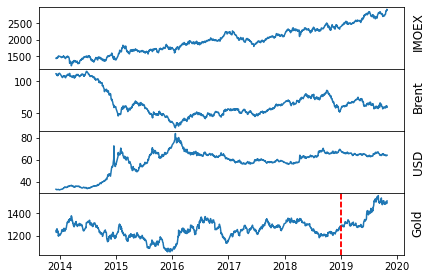

In [66]:
# fig, axs = plt.subplots(4, figsize=(6,4.5))
# fig.suptitle('Vertically stacked subplots')
fig = plt.figure()
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
axs[0].plot(data_day.close_imoex)
axs[0].set_title('IMOEX', rotation='vertical', x=1.04, y=0.25)
plt.axvline(x=pd.to_datetime('2019-01-01'), color='r', linestyle='--')
plt.axvline(x=pd.to_datetime('2019-01-01'), color='r', linestyle='--')
axs[1].plot(data_day.close_brn)
axs[1].set_title('Brent', rotation='vertical', x=1.04, y=0.25)
axs[2].plot(data_day.close_usd)
axs[2].set_title('USD', rotation='vertical', x=1.04, y=0.25)
axs[3].plot(data_day.close_gld)
axs[3].set_title('Gold', rotation='vertical', x=1.04, y=0.25)
fig.tight_layout()
fig.savefig('series.pdf', format='pdf', bbox_inches='tight')

# lstm model

## dataloaders

In [9]:
def take_vars(data, idx, var, additional=None):
    take = [f'{v}_{i}' for i in idx for v in var]
    if additional is not None:
        take += additional
    return data[take].copy()

In [10]:
config = {
    'seq_length': 30,
    'steps': 1,
    'batch_size': 32,
    'task': 'regression',
    'idx': 'imoex,usd,brn,gld',
    # 'idx': 'gazp',
    'var': 'open,close,return,vol,volatility',
    # 'var': 'close',
}

In [11]:
# idx = ['gazp', 'usd', 'brn', 'gol', 'imoex']
# # idx = ['gazp', 'usd', 'brn', 'gol', 'imoex', 'lkoh', 'rosn', 'sibn']
# # idx = ['gazp']
# var = ['open', 'close', 'return', 'vol', 'volatility']

# data = take_vars(data_day, idx, var, additional=[f'dayofweek_{i}' for i in range(5)])

In [12]:
idx = config['idx'].split(',')
var = config['var'].split(',')

data = take_vars(data_day, idx, var, additional=[f'dayofweek_{i}' for i in range(5)])

In [13]:
# idx = ['gazp', 'usd', 'brn', 'imoex']
# idx = ['gazp']
# var = ['open', 'close', 'return', 'vol']

# data = take_vars(
#     data_5m, 
#     idx, 
#     var, 
#     additional=[f'dayofweek_{i}' for i in range(5)] +
#     [f'dayofweek_{i}' for i in ('sin', 'cos')] +
#     [f'time_{i}' for i in ('sin', 'cos')]
# )

In [14]:
#data = pd.read_csv('https://raw.githubusercontent.com/KurochkinAlexey/DA-RNN/master/nasdaq100_padding.csv')

In [15]:
exclude = ['time_cos', 'time_sin', 'dayofweek_cos', 'dayofweek_sin', 
           'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4']
norm_stats = calculate_normalization_statictics(data, train_size=0.8, exclude=exclude)

In [16]:
dataset = TickerDataset(data, y='close_imoex', seq_length=config['seq_length'], norm_stats=norm_stats, steps=config['steps'], task=config['task'])
train_dataset, val_dataset, test_dataset = sequential_split(dataset, splits=[0.8, 0.1, 0.1])

In [17]:
full_loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

In [18]:
config['input_size'] = dataset.data.shape[1]
config['output_size'] = (len(dataset.y_idx) if isinstance(dataset.y_idx, list) else 1)

In [19]:
5+len(config['var'].split(','))*len(config['idx'].split(','))

25

In [20]:
data_norm = (data - norm_stats[0])/norm_stats[1]

## training

In [286]:
from models import *

In [287]:
criterion = nn.MSELoss()
metric = lambda x,y: mse(x,y)*100

In [226]:
def auto_accuracy(y_true, y_pred, threshold=0.5):
    y_true = np.array(y_true, dtype=np.bool)
    y_pred = np.array(y_pred) >= threshold
    return accuracy(y_true, y_pred)

In [227]:
criterion = nn.BCELoss()
metric = auto_accuracy

In [438]:
model = VanillaLSTM(
    input_size=5+len(config['var'].split(','))*len(config['idx'].split(',')),
    output_size=1,
    seq_length=config['seq_length'],
    steps=1,
    
    lstm_layers=2, 
    lstm_hidden_size=256,
    bidirectional=True,
    
    fc_layers=None, # try 1
    fc_hidden_size=64,
    dropout=0,
)

In [421]:
model = EncoderDecoderLSTM(
    input_size=config['input_size'], 
    output_size=config['output_size'],
    seq_length=config['seq_length'],
    steps=config['steps'],
    
    encoder_layers=1, 
    encoder_hidden_size=64,
    encoder_bidirectional=False,
    decoder_layers=1, 
    decoder_hidden_size=64,
    decoder_bidirectional=False,
    
    fc_layers=None,
    fc_hidden_size=16,
    dropout=0.1,
)

In [220]:
model = DARNN(
    N=dataset.data.shape[1],
    M=256,
    P=256,
    T=config['seq_length'])

In [47]:
model = VanillaTransformer(
    input_size=config['input_size'],
    seq_length=config['seq_length'],
    num_layers=16, 
    nhead=config['input_size']
)
# ADD DROPOUT AND OTHER ARGUMENTS

In [133]:
# trainer = Trainer(model)
# trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.001, weight_decay=0.0001) #0.0001, 0.0001
# # trainer.optimizer = torch.optim.RMSprop(trainer.model.parameters(), lr=0.0001, weight_decay=0.001)
# trainer.scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.99)

In [221]:
trainer = DARNNTrainer(model, criterion, metric, task=config['task'])
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.0001, weight_decay=0.0001) #0.001
# trainer.optimizer = torch.optim.RMSprop(trainer.model.parameters(), lr=0.0001, weight_decay=0.001)
trainer.scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.99)

In [135]:
trainer = TransformerTrainer(model, criterion, metric, task=config['task'])
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.0001, weight_decay=0.01) #0.001
# trainer.optimizer = torch.optim.RMSprop(trainer.model.parameters(), lr=0.0001, weight_decay=0.001)
trainer.scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.99)

In [439]:
trainer = LSTMTrainer(model, criterion, metric, task=config['task'])
trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), lr=0.0001, weight_decay=0.001) #0.0001, 0.001
trainer.scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=1)

In [440]:
trainer.fit(train_loader, val_loader, epochs=50, save_logs=False)

{'bidirectional': True,
 'dropout': 0,
 'fc_hidden_size': 64,
 'fc_layers': None,
 'hidden_size': 256,
 'input_size': 25,
 'model': 'VanillaLSTM',
 'num_layers': 2,
 'output_size': 1,
 'seq_length': 30,
 'stateful': True,
 'steps': 1}


  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.2273540946189314
train <lambda> 22.735409648157656


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.05998631101101637
valid <lambda> 5.998631101101637
--------------------------------------------------------------------------------
2 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.02828408795176074
train <lambda> 2.828408812638372


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.04787547420710325
valid <lambda> 4.787547467276454
--------------------------------------------------------------------------------
3 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.01692996092606336
train <lambda> 1.6929961158894002


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.03386661096010357
valid <lambda> 3.386661014519632
--------------------------------------------------------------------------------
4 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.012274361608433537
train <lambda> 1.2274361462914385


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.031507487408816814
valid <lambda> 3.1507488922216
--------------------------------------------------------------------------------
5 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00898595254693646
train <lambda> 0.898595254693646


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.02363349054940045
valid <lambda> 2.3633489676285535
--------------------------------------------------------------------------------
6 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0065178491931874305
train <lambda> 0.6517849149531685


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.019229203957365826
valid <lambda> 1.9229203491704538
--------------------------------------------------------------------------------
7 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00506787564518163
train <lambda> 0.5067875776148867


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.015162690076977015
valid <lambda> 1.5162689669523388
--------------------------------------------------------------------------------
8 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004314448102377355
train <lambda> 0.4314448175136931


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.013578942278400064
valid <lambda> 1.3578941929154098
--------------------------------------------------------------------------------
9 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0040780522977001965
train <lambda> 0.40780521994747687


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.01588066969998181
valid <lambda> 1.588066853582859
--------------------------------------------------------------------------------
10 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003874286812788341
train <lambda> 0.38742868418921717


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.010809447150677443
valid <lambda> 1.0809447732754052
--------------------------------------------------------------------------------
11 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0036240546469343826
train <lambda> 0.3624054617830552


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.009302244579885155
valid <lambda> 0.9302244317950681
--------------------------------------------------------------------------------
12 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0034505889198044315
train <lambda> 0.3450588963460177


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.00888034829404205
valid <lambda> 0.8880348061211407
--------------------------------------------------------------------------------
13 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003501765495457221
train <lambda> 0.3501765510009136


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.008731538779102266
valid <lambda> 0.8731538895517588
--------------------------------------------------------------------------------
14 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003370292983163381
train <lambda> 0.33702929940773174


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.008067484595812857
valid <lambda> 0.8067484188359231
--------------------------------------------------------------------------------
15 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0034235397397424094
train <lambda> 0.3423539732466452


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.008354431833140552
valid <lambda> 0.8354431833140552
--------------------------------------------------------------------------------
16 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003228157827834366
train <lambda> 0.322815784602426


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.007879370648879558
valid <lambda> 0.7879370532464236
--------------------------------------------------------------------------------
17 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0031145947068580426
train <lambda> 0.3114594703220064


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.007395926222670823
valid <lambda> 0.7395926339086145
--------------------------------------------------------------------------------
18 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003052334959647851
train <lambda> 0.3052334977837745


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.007484039000701159
valid <lambda> 0.7484038709662855
--------------------------------------------------------------------------------
19 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0031867104808043223
train <lambda> 0.3186710524460068


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.006689710513455793
valid <lambda> 0.6689710775390267
--------------------------------------------------------------------------------
20 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003048676284379326
train <lambda> 0.3048676284379326


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.007938149443361908
valid <lambda> 0.7938149792607874
--------------------------------------------------------------------------------
21 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0029614152772410307
train <lambda> 0.2961415313620819


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.006647838570643216
valid <lambda> 0.6647838337812573
--------------------------------------------------------------------------------
22 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.002876476133678807
train <lambda> 0.28764761591446586


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.006506568752229214
valid <lambda> 0.6506568752229214
--------------------------------------------------------------------------------
23 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003173625002091285
train <lambda> 0.3173624994815327


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.0059375154378358275
valid <lambda> 0.5937515350524336
--------------------------------------------------------------------------------
24 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0030198433887562715
train <lambda> 0.3019843374204356


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.007237634737975895
valid <lambda> 0.7237634970806539
--------------------------------------------------------------------------------
25 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0031375509206554852
train <lambda> 0.3137550946121337


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.006520005350466818
valid <lambda> 0.6520005350466818
--------------------------------------------------------------------------------
26 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0029938588922959752
train <lambda> 0.2993858917761827


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005827617220347747
valid <lambda> 0.5827617453178391
--------------------------------------------------------------------------------
27 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0029545894103648607
train <lambda> 0.29545894176408183


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.0054508613829966635
valid <lambda> 0.545086115016602
--------------------------------------------------------------------------------
28 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0028171465019113384
train <lambda> 0.28171464800834656


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005559022363740951
valid <lambda> 0.555902233463712
--------------------------------------------------------------------------------
29 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0030698844930157065
train <lambda> 0.3069884525757516


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.006310146825853735
valid <lambda> 0.6310146418400109
--------------------------------------------------------------------------------
30 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0030893693074176554
train <lambda> 0.3089369311055634


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005465212045237422
valid <lambda> 0.5465212190756574
--------------------------------------------------------------------------------
31 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0029663473324035294
train <lambda> 0.2966347303299699


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005216096498770639
valid <lambda> 0.5216096702497452
--------------------------------------------------------------------------------
32 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0030131146377243567
train <lambda> 0.3013114612258505


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.006322422530502081
valid <lambda> 0.6322422821540385
--------------------------------------------------------------------------------
33 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003088529465458123
train <lambda> 0.3088529498199932


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005947908677626401
valid <lambda> 0.5947908852249384
--------------------------------------------------------------------------------
34 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.002924080668890383
train <lambda> 0.292408070890815


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.0050006302481051534
valid <lambda> 0.5000630480935797
--------------------------------------------------------------------------------
35 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0029826728241459932
train <lambda> 0.2982672795042163


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005345345110981725
valid <lambda> 0.5345344776287675
--------------------------------------------------------------------------------
36 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0030252338328864425
train <lambda> 0.30252338146965485


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005109458230435848
valid <lambda> 0.5109458201332018
--------------------------------------------------------------------------------
37 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003018638915818883
train <lambda> 0.30186389449227136


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.0050169945461675525
valid <lambda> 0.5016994546167552
--------------------------------------------------------------------------------
38 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0028782340232282877
train <lambda> 0.2878233957744669


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005160455795703456
valid <lambda> 0.5160455562872812
--------------------------------------------------------------------------------
39 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.002811543148709461
train <lambda> 0.28115431778132915


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.00517430723994039
valid <lambda> 0.5174306978005916
--------------------------------------------------------------------------------
40 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.002915474040491972
train <lambda> 0.2915474018664099


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005959771107882261
valid <lambda> 0.5959771282505244
--------------------------------------------------------------------------------
41 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0028962505639356095
train <lambda> 0.28962505493836943


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.006487196194939315
valid <lambda> 0.6487196078523993
--------------------------------------------------------------------------------
42 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0031450741153093986
train <lambda> 0.3145074126223335


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.004473806970054284
valid <lambda> 0.447380673722364
--------------------------------------------------------------------------------
43 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0032593347132205963
train <lambda> 0.3259334720496554


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005912897409871221
valid <lambda> 0.5912897177040577
--------------------------------------------------------------------------------
44 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.002988232867210172
train <lambda> 0.2988232794450596


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005822758539579809
valid <lambda> 0.5822758539579809
--------------------------------------------------------------------------------
45 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0034742378811642993
train <lambda> 0.3474237888440257


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005032724962802604
valid <lambda> 0.5032724846387282
--------------------------------------------------------------------------------
46 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.002880794298107503
train <lambda> 0.28807943672291003


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005241478327661753
valid <lambda> 0.5241478444077075
--------------------------------------------------------------------------------
47 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003144474554574117
train <lambda> 0.31444745836779475


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.0063188361818902194
valid <lambda> 0.6318836472928524
--------------------------------------------------------------------------------
48 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0030602898987126537
train <lambda> 0.3060289964196272


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.00533402367727831
valid <lambda> 0.5334023793693632
--------------------------------------------------------------------------------
49 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003180424580932595
train <lambda> 0.31804246464162134


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.005678103887476027
valid <lambda> 0.5678103945683688
--------------------------------------------------------------------------------
50 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0030697831716679502
train <lambda> 0.30697832189616747


  0%|          | 0/4 [00:00<?, ?it/s]

valid loss 0.00452667340869084
valid <lambda> 0.45266733795870095
--------------------------------------------------------------------------------


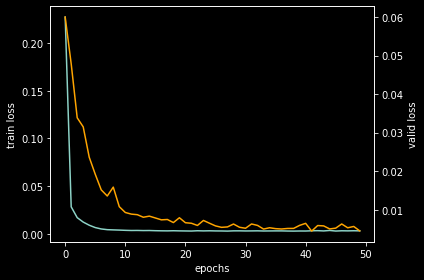

In [441]:
trainer.plot_loss();

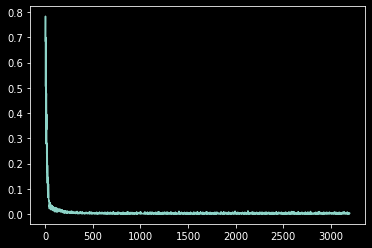

In [435]:
trainer.plot('train_step_loss')

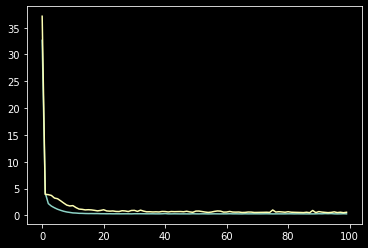

In [436]:
trainer.plot('train_epoch_metric')
trainer.plot('valid_epoch_metric')

In [420]:
baseline_prev = PreviousValueBaseline(task=config['task'])
ret = Trainer(model=baseline_prev).predict(val_loader)
print('previous value:', metric(ret['y_true'], ret['y_pred']))

  0%|          | 0/4 [00:00<?, ?it/s]

previous value: 0.30466544405642126


In [113]:
# baseline_mean = RollingMeanBaseline(task=config['task'])
# ret = Trainer(model=baseline_mean).predict(val_loader)
# print('rolling mean:', metric(ret['y_true'], ret['y_pred']))

In [114]:
# baseline_mean = AlwaysOneBaseline()
# ret = Trainer(model=baseline_mean).predict(val_loader)
print('constanc one:', metric(np.ones_like(ret['y_true']), ret['y_true']))

constanc one: 49.69939128088877


In [437]:
ret = trainer.predict(val_loader)
print('lstm model:', metric(ret['y_true'], ret['y_pred']))

  0%|          | 0/4 [00:00<?, ?it/s]

lstm model: 0.5717829731653989


In [89]:
ret = trainer.predict(test_loader)
print('lstm model:', metric(ret['y_true'], ret['y_pred']))

  0%|          | 0/4 [00:00<?, ?it/s]

lstm model: 74.58296254208989


# shap

In [310]:
full_val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [311]:
full_val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
x,y,t=next(iter(full_val_loader))
x = torch.cat((x, y), dim=2)
x.requires_grad_()
baseline = torch.zeros_like(x)

In [312]:
from captum.attr import (
    IntegratedGradients,
    GradientShap
)

In [313]:
# integrated = IntegratedGradients(model)
# attr_integrated, delta = integrated.attribute(x, baseline, return_convergence_delta=True)
# attr_integrated = attr_integrated.detach().numpy()

In [314]:
shap = GradientShap(model)
attr_shap, delta = shap.attribute(x, baseline, return_convergence_delta=True)
attr_shap = attr_shap.detach().numpy()

In [315]:
feature_names = list(data.columns)
feature_names.append(feature_names.pop(feature_names.index('close_gazp')))

<BarContainer object of 30 artists>

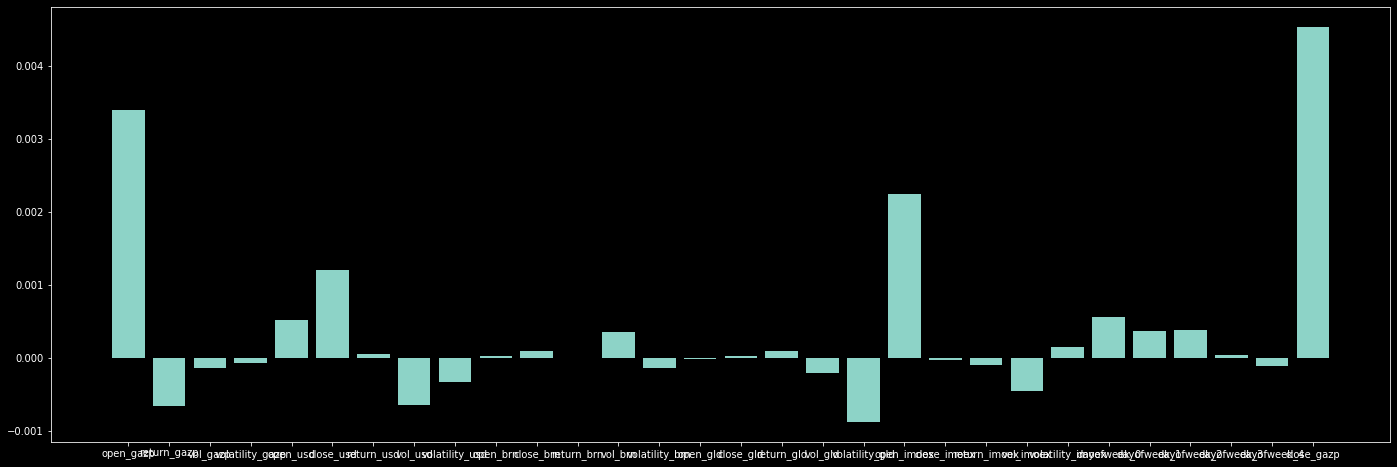

In [318]:
fig = plt.figure(figsize=(24,8))
plt.bar(x=feature_names, height=attr_shap.mean(axis=(0,1)))

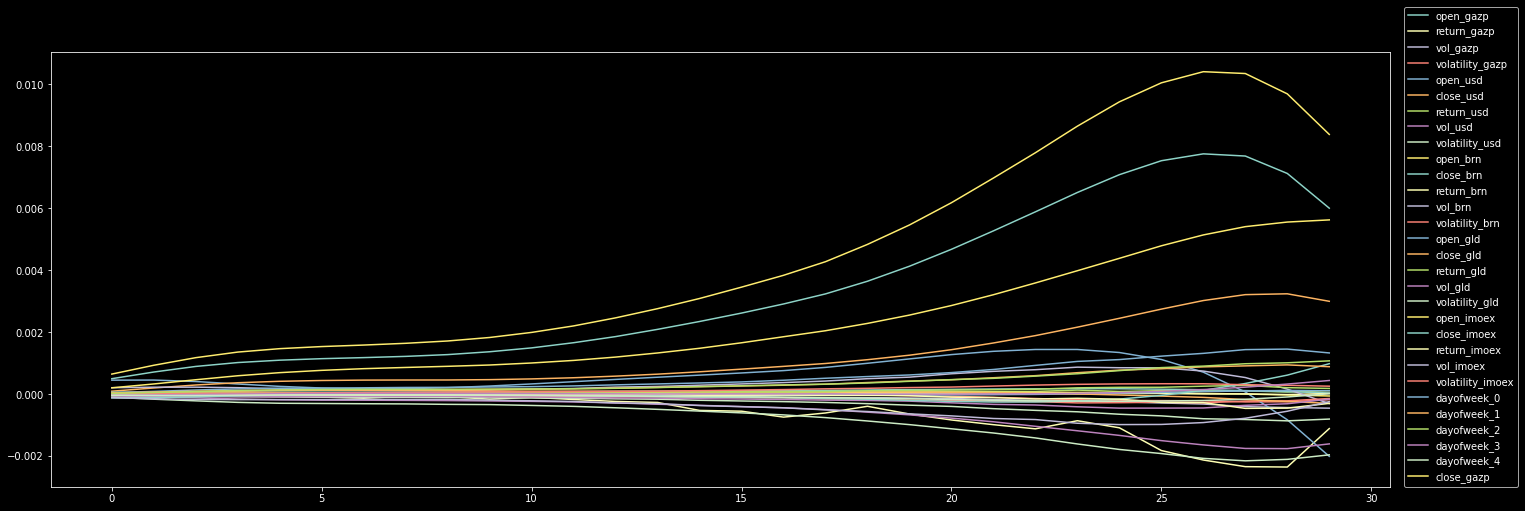

In [319]:
fig = plt.figure(figsize=(24,8))
plt.plot(attr_shap.mean(axis=0))
plt.legend(feature_names, loc=[1.01, 0])

In [264]:
full_loader = DataLoader(dataset, batch_size=9999, shuffle=False)
x,y,t=next(iter(full_loader))
x = torch.cat((x, y), dim=2)
x.requires_grad_()
baseline = torch.zeros_like(x)

In [265]:
attr_shap, delta = shap.attribute(x, baseline, return_convergence_delta=True)
attr_shap = attr_shap.detach().numpy()

In [266]:
attr_shap.shape

(1276, 30, 10)

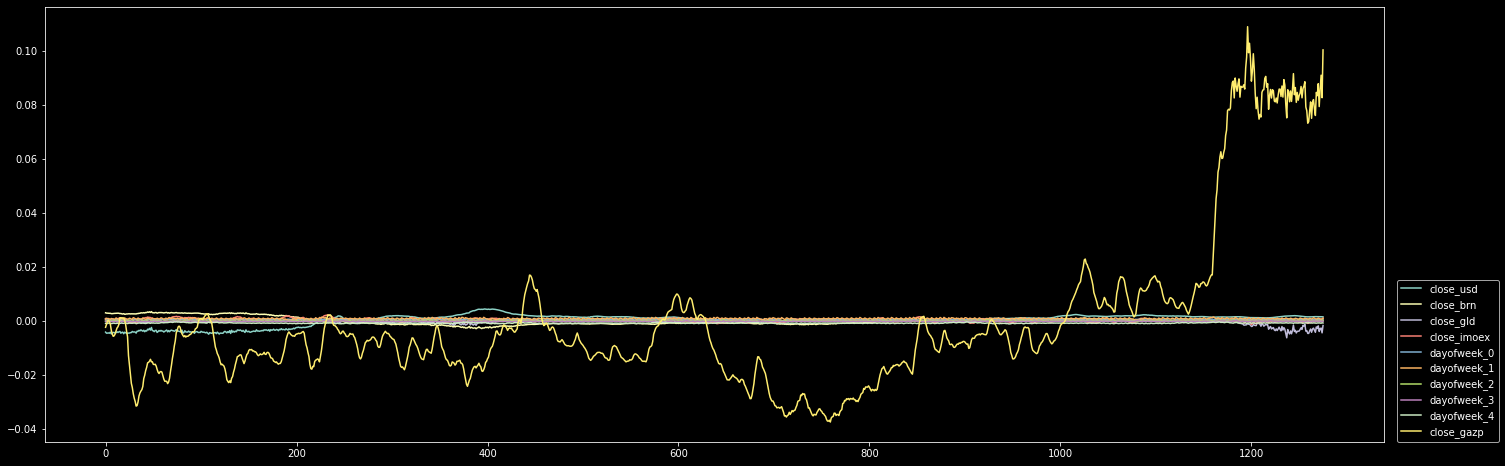

In [267]:
fig = plt.figure(figsize=(24,8))
plt.plot(attr_shap.mean(axis=1))
plt.legend(feature_names, loc=[1.01, 0])

# grid search

In [289]:
class Searcher():
    def __init__(self, train_loader, val_loader, default_model_params={}, default_optimizer_params={}, epochs=50):
        self.epochs = epochs
        self.train_loader, self.val_loader = train_loader, val_loader
        self.default_model_params = default_model_params
        self.default_optimizer_params = default_optimizer_params
    
    def configure_grid(self, grid_dict):
        import itertools
        keys, values = zip(*grid_dict.items())
        return [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    def log(self, res):
        file = 'logs/log_table.txt'
        with open(file, 'a') as f:
            f.write(','.join(res.to_numpy().astype(np.str)))
            f.write('\n')
        
    def trial(self, model_params={}, optimizer_params={}):
        model = VanillaLSTM(
            input_size=config['input_size'], 
            output_size=config['output_size'],
            seq_length=config['seq_length'],
            steps=config['steps'],
            **self.default_model_params,
            **model_params
        )
        trainer = LSTMTrainer(model, criterion=criterion, task=config['task'], metric=metric)
        trainer.optimizer = torch.optim.Adam(trainer.model.parameters(), **self.default_optimizer_params, **optimizer_params) #0.001
        trainer.sceduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=1)

        trainer.fit(self.train_loader, val_loader=None, epochs=self.epochs, save_logs=True)
        ret = trainer.predict(self.val_loader)
        
        res = pd.Series(trainer.model.params)
        res['metric'] = metric(ret['y_true'], ret['y_pred'])
        res['starttime'] = trainer.starttime
        res['idx'] = config['idx']
        return res
    
    def grid_search(self, grid_dict):
        grid = self.configure_grid(grid_dict)
        for d in tqdm(grid):
            res = self.trial(model_params=d)
            print(res)
            self.log(res)

In [290]:
fun = Searcher(
    train_loader, 
    val_loader, 
    epochs=50, 
    default_model_params=dict(
        fc_layers=None,
        fc_hidden_size=64,
        dropout=0),
    default_optimizer_params=dict(
        lr=0.0001,
        weight_decay=0.001
    )
)

In [291]:
grid_dict = dict(
        lstm_layers=[1,2], 
        lstm_hidden_size=[2**x for x in range(6,11)],
        bidirectional=[True, False]
    )

fun.grid_search(grid_dict)

  0%|          | 0/20 [00:00<?, ?it/s]

{'bidirectional': True,
 'dropout': 0,
 'fc_hidden_size': 64,
 'fc_layers': None,
 'hidden_size': 64,
 'input_size': 30,
 'model': 'VanillaLSTM',
 'num_layers': 1,
 'output_size': 1,
 'seq_length': 30,
 'stateful': True,
 'steps': 1}


  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.1480043143965304
train <lambda> 14.800431730691344
--------------------------------------------------------------------------------
2 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.06434718752279878
train <lambda> 6.434718787204474
--------------------------------------------------------------------------------
3 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.04311016376595944
train <lambda> 4.311016405699775
--------------------------------------------------------------------------------
4 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0311197733390145
train <lambda> 3.111977275693789
--------------------------------------------------------------------------------
5 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.023571884084958583
train <lambda> 2.3571884375996888
--------------------------------------------------------------------------------
6 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.019051658047828823
train <lambda> 1.9051657756790519
--------------------------------------------------------------------------------
7 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.015422035212395713
train <lambda> 1.5422035357914865
--------------------------------------------------------------------------------
8 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.012840811628848314
train <lambda> 1.2840811716159806
--------------------------------------------------------------------------------
9 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.011223529785638675
train <lambda> 1.1223529814742506
--------------------------------------------------------------------------------
10 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.009983475094486494
train <lambda> 0.9983475138142239
--------------------------------------------------------------------------------
11 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.009042484045494348
train <lambda> 0.9042483972734772
--------------------------------------------------------------------------------
12 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.008269210549769923
train <lambda> 0.826921065163333
--------------------------------------------------------------------------------
13 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.007856059666664805
train <lambda> 0.7856059659388848
--------------------------------------------------------------------------------
14 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.007369605889834929
train <lambda> 0.7369605838903226
--------------------------------------------------------------------------------
15 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0069562063363264315
train <lambda> 0.695620637270622
--------------------------------------------------------------------------------
16 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006622959575906862
train <lambda> 0.6622959568630904
--------------------------------------------------------------------------------
17 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006361970510624815
train <lambda> 0.6361970619764179
--------------------------------------------------------------------------------
18 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0061975088028702885
train <lambda> 0.6197508933837526
--------------------------------------------------------------------------------
19 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0058428700067452155
train <lambda> 0.5842869955813512
--------------------------------------------------------------------------------
20 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005756094076787122
train <lambda> 0.5756094098614994
--------------------------------------------------------------------------------
21 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005543531020521186
train <lambda> 0.5543530896829907
--------------------------------------------------------------------------------
22 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005398115499701817
train <lambda> 0.5398115565185435
--------------------------------------------------------------------------------
23 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005404030489444267
train <lambda> 0.5404030453064479
--------------------------------------------------------------------------------
24 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0052952306941733696
train <lambda> 0.5295230657793581
--------------------------------------------------------------------------------
25 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005210600786085706
train <lambda> 0.5210600822465494
--------------------------------------------------------------------------------
26 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005033162240579259
train <lambda> 0.5033162138715852
--------------------------------------------------------------------------------
27 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004829340643482283
train <lambda> 0.48293406071024947
--------------------------------------------------------------------------------
28 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004815032058104407
train <lambda> 0.4815032138139941
--------------------------------------------------------------------------------
29 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00472869736404391
train <lambda> 0.47286973749578465
--------------------------------------------------------------------------------
30 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004568200049106963
train <lambda> 0.4568200081848772
--------------------------------------------------------------------------------
31 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004528363126155455
train <lambda> 0.45283631261554547
--------------------------------------------------------------------------------
32 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004415850373334251
train <lambda> 0.4415850431541912
--------------------------------------------------------------------------------
33 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004359182112239068
train <lambda> 0.43591820685833227
--------------------------------------------------------------------------------
34 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004299589716538321
train <lambda> 0.4299589701986406
--------------------------------------------------------------------------------
35 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00426578050974058
train <lambda> 0.42657805388444103
--------------------------------------------------------------------------------
36 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0041970805868913885
train <lambda> 0.41970805468736216
--------------------------------------------------------------------------------
37 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004200534265692113
train <lambda> 0.42005342547781765
--------------------------------------------------------------------------------
38 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004172539378487272
train <lambda> 0.4172539454884827
--------------------------------------------------------------------------------
39 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004057767630001763
train <lambda> 0.4057767648191657
--------------------------------------------------------------------------------
40 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003991604928160086
train <lambda> 0.39916049645398743
--------------------------------------------------------------------------------
41 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00399637929876917
train <lambda> 0.39963793351489585
--------------------------------------------------------------------------------
42 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004067062785907183
train <lambda> 0.40670628295629285
--------------------------------------------------------------------------------
43 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004022256922326051
train <lambda> 0.40222569441539235
--------------------------------------------------------------------------------
44 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004059267015691148
train <lambda> 0.4059267055708915
--------------------------------------------------------------------------------
45 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0038076898381405044
train <lambda> 0.3807689805398695
--------------------------------------------------------------------------------
46 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003808622765063774
train <lambda> 0.38086228123574983
--------------------------------------------------------------------------------
47 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003825204723398201
train <lambda> 0.38252047015703283
--------------------------------------------------------------------------------
48 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0038670082358294167
train <lambda> 0.3867008137603989
--------------------------------------------------------------------------------
49 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0037448370130732656
train <lambda> 0.3744837064004969
--------------------------------------------------------------------------------
50 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003927312642190373
train <lambda> 0.3927312656742288
--------------------------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

model                        VanillaLSTM
input_size                            30
seq_length                            30
output_size                            1
steps                                  1
num_layers                             1
hidden_size                           64
bidirectional                       True
fc_hidden_size                        64
fc_layers                           None
dropout                                0
stateful                            True
metric                          1.695599
starttime                  220421_114005
idx               gazp,usd,brn,gld,imoex
dtype: object
{'bidirectional': False,
 'dropout': 0,
 'fc_hidden_size': 64,
 'fc_layers': None,
 'hidden_size': 64,
 'input_size': 30,
 'model': 'VanillaLSTM',
 'num_layers': 1,
 'output_size': 1,
 'seq_length': 30,
 'stateful': True,
 'steps': 1}


  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.1876104928087443
train <lambda> 18.761049234308302
--------------------------------------------------------------------------------
2 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.09211029496509582
train <lambda> 9.21102954307571
--------------------------------------------------------------------------------
3 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.06140442774631083
train <lambda> 6.140442797914147
--------------------------------------------------------------------------------
4 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.045973742206115276
train <lambda> 4.597374203149229
--------------------------------------------------------------------------------
5 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.035254893417004496
train <lambda> 3.525489295134321
--------------------------------------------------------------------------------
6 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.027985702647129074
train <lambda> 2.7985702676232904
--------------------------------------------------------------------------------
7 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.02346939968992956
train <lambda> 2.3469399253372103
--------------------------------------------------------------------------------
8 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.020187863148748875
train <lambda> 2.0187863236060366
--------------------------------------------------------------------------------
9 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.017637625089264475
train <lambda> 1.763762476912234
--------------------------------------------------------------------------------
10 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.01574521925067529
train <lambda> 1.5745219323434867
--------------------------------------------------------------------------------
11 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.014091489370912313
train <lambda> 1.4091489400016144
--------------------------------------------------------------------------------
12 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.013022671191720292
train <lambda> 1.3022671191720292
--------------------------------------------------------------------------------
13 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.01202853344148025
train <lambda> 1.2028533368720673
--------------------------------------------------------------------------------
14 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0111236629600171
train <lambda> 1.1123662945465185
--------------------------------------------------------------------------------
15 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.010379515661043115
train <lambda> 1.0379515544627793
--------------------------------------------------------------------------------
16 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.009870808207779191
train <lambda> 0.9870808324194513
--------------------------------------------------------------------------------
17 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.009327330131782219
train <lambda> 0.9327330233645625
--------------------------------------------------------------------------------
18 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.008818556874757633
train <lambda> 0.8818556831101887
--------------------------------------------------------------------------------
19 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.008356599661055952
train <lambda> 0.8356599588296376
--------------------------------------------------------------------------------
20 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0080653987970436
train <lambda> 0.8065398695180193
--------------------------------------------------------------------------------
21 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.007860030636948068
train <lambda> 0.7860030491428915
--------------------------------------------------------------------------------
22 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.007456569619535003
train <lambda> 0.7456569619535003
--------------------------------------------------------------------------------
23 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.007186243536125403
train <lambda> 0.7186243463365827
--------------------------------------------------------------------------------
24 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00690149769798154
train <lambda> 0.6901497799844947
--------------------------------------------------------------------------------
25 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006670040093013085
train <lambda> 0.6670040107565001
--------------------------------------------------------------------------------
26 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006435557676013559
train <lambda> 0.6435557668737601
--------------------------------------------------------------------------------
27 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0063291985061368905
train <lambda> 0.6329198608000297
--------------------------------------------------------------------------------
28 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006153873313451186
train <lambda> 0.6153873328003101
--------------------------------------------------------------------------------
29 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0060037261646357365
train <lambda> 0.6003726106428076
--------------------------------------------------------------------------------
30 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0058881192962871864
train <lambda> 0.5888119361770805
--------------------------------------------------------------------------------
31 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005692563681805041
train <lambda> 0.5692563638149295
--------------------------------------------------------------------------------
32 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005591437824477907
train <lambda> 0.5591437897237483
--------------------------------------------------------------------------------
33 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005467446564580314
train <lambda> 0.5467446469992865
--------------------------------------------------------------------------------
34 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005545701053051744
train <lambda> 0.5545701053051744
--------------------------------------------------------------------------------
35 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00534006769885309
train <lambda> 0.5340067727956921
--------------------------------------------------------------------------------
36 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005150231780135073
train <lambda> 0.5150231751031242
--------------------------------------------------------------------------------
37 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005044554272899404
train <lambda> 0.5044554272899404
--------------------------------------------------------------------------------
38 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005009024607716128
train <lambda> 0.5009024614992086
--------------------------------------------------------------------------------
39 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004913337390462402
train <lambda> 0.49133375214296393
--------------------------------------------------------------------------------
40 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004832069906115066
train <lambda> 0.4832069869735278
--------------------------------------------------------------------------------
41 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0048274276705342345
train <lambda> 0.4827427655982319
--------------------------------------------------------------------------------
42 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004690941364970058
train <lambda> 0.46909413977118675
--------------------------------------------------------------------------------
43 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0045922095159767196
train <lambda> 0.45922094795969315
--------------------------------------------------------------------------------
44 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004652060059015639
train <lambda> 0.46520600881194696
--------------------------------------------------------------------------------
45 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004573617530695628
train <lambda> 0.4573617559799459
--------------------------------------------------------------------------------
46 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0044607991294469684
train <lambda> 0.44607991076190956
--------------------------------------------------------------------------------
47 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004424191953148693
train <lambda> 0.44241919240448624
--------------------------------------------------------------------------------
48 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0043691302635124885
train <lambda> 0.4369130248960573
--------------------------------------------------------------------------------
49 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0043196058068133425
train <lambda> 0.4319605868658982
--------------------------------------------------------------------------------
50 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004310123193135951
train <lambda> 0.4310123171308078
--------------------------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

model                        VanillaLSTM
input_size                            30
seq_length                            30
output_size                            1
steps                                  1
num_layers                             1
hidden_size                           64
bidirectional                      False
fc_hidden_size                        64
fc_layers                           None
dropout                                0
stateful                            True
metric                          3.188092
starttime                  220421_114133
idx               gazp,usd,brn,gld,imoex
dtype: object
{'bidirectional': True,
 'dropout': 0,
 'fc_hidden_size': 64,
 'fc_layers': None,
 'hidden_size': 128,
 'input_size': 30,
 'model': 'VanillaLSTM',
 'num_layers': 1,
 'output_size': 1,
 'seq_length': 30,
 'stateful': True,
 'steps': 1}


  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.13089456968009472
train <lambda> 13.089457352180034
--------------------------------------------------------------------------------
2 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.04747504642000422
train <lambda> 4.747504531405866
--------------------------------------------------------------------------------
3 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.027155146468430758
train <lambda> 2.7155146904988214
--------------------------------------------------------------------------------
4 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.018888991558924317
train <lambda> 1.8888991849962622
--------------------------------------------------------------------------------
5 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.013803566456772387
train <lambda> 1.3803566413116641
--------------------------------------------------------------------------------
6 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.01118784242135007
train <lambda> 1.1187842304934748
--------------------------------------------------------------------------------
7 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.009800890358746983
train <lambda> 0.9800890402402729
--------------------------------------------------------------------------------
8 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.008765389429754578
train <lambda> 0.8765389342443086
--------------------------------------------------------------------------------
9 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.008056381135247648
train <lambda> 0.8056381106143817
--------------------------------------------------------------------------------
10 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.007482417990104295
train <lambda> 0.748241797555238
--------------------------------------------------------------------------------
11 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0068842302716802806
train <lambda> 0.6884230184368789
--------------------------------------------------------------------------------
12 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006625847308896482
train <lambda> 0.6625847177929245
--------------------------------------------------------------------------------
13 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006452414134400897
train <lambda> 0.6452414083469193
--------------------------------------------------------------------------------
14 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006166413819300942
train <lambda> 0.6166413935716264
--------------------------------------------------------------------------------
15 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00601837869908195
train <lambda> 0.6018378750013653
--------------------------------------------------------------------------------
16 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00593208192003658
train <lambda> 0.5932081781793386
--------------------------------------------------------------------------------
17 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005897859075048473
train <lambda> 0.5897858936805278
--------------------------------------------------------------------------------
18 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005481736065121368
train <lambda> 0.5481736079673283
--------------------------------------------------------------------------------
19 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00535645514173666
train <lambda> 0.5356455134460703
--------------------------------------------------------------------------------
20 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005189053081267048
train <lambda> 0.5189053110370878
--------------------------------------------------------------------------------
21 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004913522621791344
train <lambda> 0.49135225417558104
--------------------------------------------------------------------------------
22 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004901969019556418
train <lambda> 0.49019689759006724
--------------------------------------------------------------------------------
23 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00479868684487883
train <lambda> 0.479868684487883
--------------------------------------------------------------------------------
24 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00478515203576535
train <lambda> 0.4785151977557689
--------------------------------------------------------------------------------
25 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00473682647862006
train <lambda> 0.4736826420412399
--------------------------------------------------------------------------------
26 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004653626077924855
train <lambda> 0.4653626099752728
--------------------------------------------------------------------------------
27 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004666491680836771
train <lambda> 0.4666491746320389
--------------------------------------------------------------------------------
28 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004391274094814435
train <lambda> 0.4391274102090392
--------------------------------------------------------------------------------
29 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004457659837498795
train <lambda> 0.44576598120329436
--------------------------------------------------------------------------------
30 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004317290589824552
train <lambda> 0.4317290637118276
--------------------------------------------------------------------------------
31 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004263910224835854
train <lambda> 0.426391014480032
--------------------------------------------------------------------------------
32 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004294054589990992
train <lambda> 0.4294054539059289
--------------------------------------------------------------------------------
33 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0042640554456738755
train <lambda> 0.4264055547537282
--------------------------------------------------------------------------------
34 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004246644864906557
train <lambda> 0.42466448758204933
--------------------------------------------------------------------------------
35 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0042399682133691385
train <lambda> 0.4239968220645096
--------------------------------------------------------------------------------
36 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004133995302254334
train <lambda> 0.4133995280426461
--------------------------------------------------------------------------------
37 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0041200950035999995
train <lambda> 0.41200949126505293
--------------------------------------------------------------------------------
38 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003991951234638691
train <lambda> 0.3991951198258903
--------------------------------------------------------------------------------
39 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00414525711312308
train <lambda> 0.4145257222262444
--------------------------------------------------------------------------------
40 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003938473833841272
train <lambda> 0.3938473848393187
--------------------------------------------------------------------------------
41 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00402101348299766
train <lambda> 0.402101357394713
--------------------------------------------------------------------------------
42 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003878446099406574
train <lambda> 0.38784461285104044
--------------------------------------------------------------------------------
43 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0038715709779353347
train <lambda> 0.3871570988849271
--------------------------------------------------------------------------------
44 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003805732081673341
train <lambda> 0.38057320525695104
--------------------------------------------------------------------------------
45 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004186307640338782
train <lambda> 0.41863076767185703
--------------------------------------------------------------------------------
46 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004076268905919278
train <lambda> 0.4076268924109172
--------------------------------------------------------------------------------
47 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003871812019497156
train <lambda> 0.387181194673758
--------------------------------------------------------------------------------
48 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003719231262948597
train <lambda> 0.37192312302067876
--------------------------------------------------------------------------------
49 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003909524770278949
train <lambda> 0.3909524722985225
--------------------------------------------------------------------------------
50 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003803547220741166
train <lambda> 0.3803547220741166
--------------------------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

model                        VanillaLSTM
input_size                            30
seq_length                            30
output_size                            1
steps                                  1
num_layers                             1
hidden_size                          128
bidirectional                       True
fc_hidden_size                        64
fc_layers                           None
dropout                                0
stateful                            True
metric                          1.451176
starttime                  220421_114220
idx               gazp,usd,brn,gld,imoex
dtype: object
{'bidirectional': False,
 'dropout': 0,
 'fc_hidden_size': 64,
 'fc_layers': None,
 'hidden_size': 128,
 'input_size': 30,
 'model': 'VanillaLSTM',
 'num_layers': 1,
 'output_size': 1,
 'seq_length': 30,
 'stateful': True,
 'steps': 1}


  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.14939230936579406
train <lambda> 14.93923095986247
--------------------------------------------------------------------------------
2 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.07305361155886203
train <lambda> 7.305361097678542
--------------------------------------------------------------------------------
3 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.05105718015693128
train <lambda> 5.105717945843935
--------------------------------------------------------------------------------
4 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0363759578904137
train <lambda> 3.6375957948621362
--------------------------------------------------------------------------------
5 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.027510318672284484
train <lambda> 2.7510318817803636
--------------------------------------------------------------------------------
6 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.021432634472148493
train <lambda> 2.1432634472148493
--------------------------------------------------------------------------------
7 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.017253508733119816
train <lambda> 1.725350896595046
--------------------------------------------------------------------------------
8 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.014520089243887924
train <lambda> 1.4520089331199415
--------------------------------------------------------------------------------
9 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.012341958747128956
train <lambda> 1.2341958747128956
--------------------------------------------------------------------------------
10 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.011203617752471473
train <lambda> 1.1203617716091685
--------------------------------------------------------------------------------
11 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.009949295243131928
train <lambda> 0.9949295170372352
--------------------------------------------------------------------------------
12 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.009206563539919443
train <lambda> 0.9206563452607952
--------------------------------------------------------------------------------
13 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.008542610026779585
train <lambda> 0.8542609954020008
--------------------------------------------------------------------------------
14 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.008034750913793687
train <lambda> 0.8034750899241772
--------------------------------------------------------------------------------
15 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0076269243581919
train <lambda> 0.7626924438227434
--------------------------------------------------------------------------------
16 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.007399687892757356
train <lambda> 0.7399687878205441
--------------------------------------------------------------------------------
17 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.007068356084346306
train <lambda> 0.7068356055242475
--------------------------------------------------------------------------------
18 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006718829754390754
train <lambda> 0.671882970345905
--------------------------------------------------------------------------------
19 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00655227462266339
train <lambda> 0.6552274608111475
--------------------------------------------------------------------------------
20 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006441561163228471
train <lambda> 0.6441561214160174
--------------------------------------------------------------------------------
21 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006137691991170868
train <lambda> 0.6137691998446826
--------------------------------------------------------------------------------
22 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005858786811586469
train <lambda> 0.58587868406903
--------------------------------------------------------------------------------
23 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00590409852884477
train <lambda> 0.5904098456085194
--------------------------------------------------------------------------------
24 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005749446208938025
train <lambda> 0.5749446208938025
--------------------------------------------------------------------------------
25 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005502928834175691
train <lambda> 0.5502928812347818
--------------------------------------------------------------------------------
26 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005374562519136816
train <lambda> 0.5374562577344477
--------------------------------------------------------------------------------
27 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00519369150424609
train <lambda> 0.5193691453314386
--------------------------------------------------------------------------------
28 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0051771440339507535
train <lambda> 0.5177144077606499
--------------------------------------------------------------------------------
29 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005114103048981633
train <lambda> 0.5114103085361421
--------------------------------------------------------------------------------
30 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0049398765549995005
train <lambda> 0.49398765331716277
--------------------------------------------------------------------------------
31 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005000296157959383
train <lambda> 0.5000296150683425
--------------------------------------------------------------------------------
32 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004742800672829617
train <lambda> 0.47428006582777016
--------------------------------------------------------------------------------
33 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0048074968290166
train <lambda> 0.4807496785360854
--------------------------------------------------------------------------------
34 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004758157403557561
train <lambda> 0.4758157410833519
--------------------------------------------------------------------------------
35 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0046191024739528075
train <lambda> 0.4619102408469189
--------------------------------------------------------------------------------
36 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004532515587925445
train <lambda> 0.4532515617029276
--------------------------------------------------------------------------------
37 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004531909951765556
train <lambda> 0.45319099590415135
--------------------------------------------------------------------------------
38 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004557859356282279
train <lambda> 0.4557859319902491
--------------------------------------------------------------------------------
39 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004544833165709861
train <lambda> 0.4544833238469437
--------------------------------------------------------------------------------
40 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004403922212077305
train <lambda> 0.44039222339051776
--------------------------------------------------------------------------------
41 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0044124339474365115
train <lambda> 0.44124339110567234
--------------------------------------------------------------------------------
42 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004341987500083633
train <lambda> 0.4341987536463421
--------------------------------------------------------------------------------
43 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004298943480534945
train <lambda> 0.4298943415051326
--------------------------------------------------------------------------------
44 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004212422456475906
train <lambda> 0.42124223691644147
--------------------------------------------------------------------------------
45 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004171325592324138
train <lambda> 0.4171325639617862
--------------------------------------------------------------------------------
46 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004243423583830008
train <lambda> 0.4243423645675648
--------------------------------------------------------------------------------
47 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0042815055930987
train <lambda> 0.4281505589460721
--------------------------------------------------------------------------------
48 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004057955782627687
train <lambda> 0.40579557899036445
--------------------------------------------------------------------------------
49 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004073647887707921
train <lambda> 0.40736478731560055
--------------------------------------------------------------------------------
50 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004033861456264276
train <lambda> 0.4033861434436403
--------------------------------------------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

model                        VanillaLSTM
input_size                            30
seq_length                            30
output_size                            1
steps                                  1
num_layers                             1
hidden_size                          128
bidirectional                      False
fc_hidden_size                        64
fc_layers                           None
dropout                                0
stateful                            True
metric                          1.742264
starttime                  220421_114431
idx               gazp,usd,brn,gld,imoex
dtype: object
{'bidirectional': True,
 'dropout': 0,
 'fc_hidden_size': 64,
 'fc_layers': None,
 'hidden_size': 256,
 'input_size': 30,
 'model': 'VanillaLSTM',
 'num_layers': 1,
 'output_size': 1,
 'seq_length': 30,
 'stateful': True,
 'steps': 1}


  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.10071262076962739
train <lambda> 10.071262123528868
--------------------------------------------------------------------------------
2 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.032319975609425455
train <lambda> 3.2319975754944608
--------------------------------------------------------------------------------
3 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.017948576743947342
train <lambda> 1.7948576743947342
--------------------------------------------------------------------------------
4 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.011652261156996246
train <lambda> 1.1652260989649221
--------------------------------------------------------------------------------
5 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.009352512221084908
train <lambda> 0.9352512439363636
--------------------------------------------------------------------------------
6 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.008003260714758653
train <lambda> 0.8003260772966314
--------------------------------------------------------------------------------
7 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.007599623000714928
train <lambda> 0.7599622986163013
--------------------------------------------------------------------------------
8 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006784153840271756
train <lambda> 0.6784153883927502
--------------------------------------------------------------------------------
9 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006554357139975764
train <lambda> 0.6554357081768103
--------------------------------------------------------------------------------
10 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.006180760043207556
train <lambda> 0.6180760072311386
--------------------------------------------------------------------------------
11 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005921113224758301
train <lambda> 0.592111313744681
--------------------------------------------------------------------------------
12 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005826197048008908
train <lambda> 0.5826197120768484
--------------------------------------------------------------------------------
13 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0054245090068434365
train <lambda> 0.5424509021395352
--------------------------------------------------------------------------------
14 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005501463863765821
train <lambda> 0.5501463892869651
--------------------------------------------------------------------------------
15 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005083759278932121
train <lambda> 0.5083759206172545
--------------------------------------------------------------------------------
16 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004931986091833096
train <lambda> 0.49319859681418166
--------------------------------------------------------------------------------
17 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005051024629210588
train <lambda> 0.50510245928308
--------------------------------------------------------------------------------
18 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00543213823766564
train <lambda> 0.5432138266769471
--------------------------------------------------------------------------------
19 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00469506158697186
train <lambda> 0.4695061688835267
--------------------------------------------------------------------------------
20 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005189032221096568
train <lambda> 0.5189032242924441
--------------------------------------------------------------------------------
21 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.005413088816567324
train <lambda> 0.5413088823843282
--------------------------------------------------------------------------------
22 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004716130453743972
train <lambda> 0.4716130599263124
--------------------------------------------------------------------------------
23 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004482788532186532
train <lambda> 0.44827885139966384
--------------------------------------------------------------------------------
24 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004490181847359054
train <lambda> 0.4490181992878206
--------------------------------------------------------------------------------
25 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004364429747511167
train <lambda> 0.4364429791166913
--------------------------------------------------------------------------------
26 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004411989459185861
train <lambda> 0.4411989481013734
--------------------------------------------------------------------------------
27 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004288672636903357
train <lambda> 0.4288672731490806
--------------------------------------------------------------------------------
28 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0041587846135371365
train <lambda> 0.415878466446884
--------------------------------------------------------------------------------
29 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004179182193183806
train <lambda> 0.41791821786318906
--------------------------------------------------------------------------------
30 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004264858638634905
train <lambda> 0.4264858696842566
--------------------------------------------------------------------------------
31 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004315664657042362
train <lambda> 0.4315664617024595
--------------------------------------------------------------------------------
32 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0042712173162726685
train <lambda> 0.4271217265340965
--------------------------------------------------------------------------------
33 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.00413402931735618
train <lambda> 0.41340293901157565
--------------------------------------------------------------------------------
34 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004234503576299176
train <lambda> 0.4234503488987684
--------------------------------------------------------------------------------
35 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003954396946937777
train <lambda> 0.3954397005145438
--------------------------------------------------------------------------------
36 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0039723736845189705
train <lambda> 0.3972373713622801
--------------------------------------------------------------------------------
37 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004068332520546392
train <lambda> 0.40683325642021373
--------------------------------------------------------------------------------
38 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004084332373167854
train <lambda> 0.4084332314960193
--------------------------------------------------------------------------------
39 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003906496789568337
train <lambda> 0.3906496767740464
--------------------------------------------------------------------------------
40 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003937449349905364
train <lambda> 0.39374493426294066
--------------------------------------------------------------------------------
41 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0040447307874273974
train <lambda> 0.4044730812893249
--------------------------------------------------------------------------------
42 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004170469488599338
train <lambda> 0.41704695104272105
--------------------------------------------------------------------------------
43 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004296188097214326
train <lambda> 0.42961881117662415
--------------------------------------------------------------------------------
44 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004035555502923671
train <lambda> 0.4035555510199629
--------------------------------------------------------------------------------
45 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.0039806886852602474
train <lambda> 0.3980688656156417
--------------------------------------------------------------------------------
46 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.003961463793530129
train <lambda> 0.3961463866289705
--------------------------------------------------------------------------------
47 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004068424997967668
train <lambda> 0.40684249324840494
--------------------------------------------------------------------------------
48 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

train loss 0.004017270541226026
train <lambda> 0.4017270533950068
--------------------------------------------------------------------------------
49 epoch:


  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 

# bayesian

In [353]:
class Wrapper():
    def __init__(self, train_loader, val_loader, default_model_params={}, default_optimizer_params={}, epochs=50):
        self.epochs = epochs
        self.train_loader, self.val_loader = train_loader, val_loader
        self.default_model_params = default_model_params
        self.default_optimizer_params = default_optimizer_params
        
    def __call__(self, params):        
        self.model = VanillaLSTM(
            input_size=config['input_size'], 
            output_size=config['output_size'],
            seq_length=config['seq_length'],
            steps=config['steps'],
            **self.default_model_params,
        )
        self.trainer = LSTMTrainer(self.model, criterion=nn.BCELoss(), task='classification', metric=auto_accuracy)
        self.trainer.optimizer = torch.optim.Adam(self.trainer.model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'], **self.default_optimizer_params) #0.001
        self.trainer.sceduler = torch.optim.lr_scheduler.ExponentialLR(self.trainer.optimizer, gamma=1)

        self.trainer.fit(self.train_loader, val_loader=None, epochs=self.epochs)
        ret = self.trainer.predict(self.val_loader)
        return auto_accuracy(ret['y_true'], ret['y_pred'])

In [351]:
class Wrapper():
    def __init__(self, model_class, trainer_class, train_loader, val_loader, epochs=50, **kwargs):
        self.epochs = epochs
        self.train_loader, self.val_loader = train_loader, val_loader
        self.model_class = model_class
        self.trainer_class = trainer_class
        
    def __call__(self, kwargs):
        print(kwargs)
        
        self.model = self.model_class(
            input_size=dataset.data.shape[1]+(len(dataset.y_idx) if isinstance(dataset.y_idx, list) else 1), 
            seq_length=config['seq_length'],
            steps=config['steps'],
            fc_layers=None,
            lstm_layers=kwargs['lstm_layers'], 
            lstm_hidden_size=kwargs['lstm_hidden_size'],
            fc_hidden_size=1,
            dropout=0,
            bidirectional=kwargs['bidirectional'])
        self.trainer = self.trainer_class(self.model)
        self.trainer.optimizer = torch.optim.Adam(self.trainer.model.parameters(), lr=kwargs['lr'], weight_decay=kwargs['weight_decay']) #0.001
        self.trainer.sceduler = torch.optim.lr_scheduler.ExponentialLR(self.trainer.optimizer, gamma=1)

        self.trainer.fit(self.train_loader, val_loader=None, epochs=self.epochs)
        ret = self.trainer.predict(self.val_loader)
        return mean_squared_error(ret['y_pred'], ret['y_true'])

In [354]:
fun = Wrapper(
    train_loader, 
    val_loader, 
    epochs=50, 
    default_model_params=dict(
        lstm_layers=2, 
        lstm_hidden_size=64,
        bidirectional=True,
        fc_layers=None,
        fc_hidden_size=64,
        dropout=0),
    default_optimizer_params=dict()
)

In [272]:
import hyperopt
from hyperopt import hp

In [267]:
import hyperopt.pyll
from hyperopt import hp
from hyperopt.pyll import scope

@scope.define
def powerof2(x):
    return int(2**x)

In [348]:
space = {
    'lr': hp.loguniform('lr', 1e-5, 1e-3)-1,
    'weight_decay': hp.loguniform('weight_decay', 1e-5, 1e-3)-1,
    # 'lstm_layers': hp.randint('lstm_layers', 4)+1,
    # 'lstm_hidden_size': scope.powerof2(hp.randint('lstm_hidden_size', 10)),
    # #'dropout': hp.uniform('dropuot', 0, 0.5),
    # 'bidirectional': hp.choice('bidirectional', [True, False]),
}

In [355]:
tpe_trials = hyperopt.Trials()
tpe_best = hyperopt.fmin(
    fn=fun, 
    space=space, 
    algo=hyperopt.tpe.suggest, 
    trials=tpe_trials, 
    max_evals=1000
)

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  0%|                                                                         | 0/1000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6965976804494858                                                                                          
train auto_accuracy 0.4866963370901639                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  0%|                                                                         | 0/1000 [00:03<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6939197480678558                                                                                          
train auto_accuracy 0.5093493852459017                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  0%|                                                                         | 0/1000 [00:06<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6880174949765205                                                                                          
train auto_accuracy 0.5476274334016393                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  0%|                                                                         | 0/1000 [00:09<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6845670267939568                                                                                          
train auto_accuracy 0.5638928022540983                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  0%|                                                                         | 0/1000 [00:12<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6812579818069935                                                                                          
train auto_accuracy 0.5740426485655737                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  0%|                                                                         | 0/1000 [00:15<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6759263873100281                                                                                          
train auto_accuracy 0.5877145235655737                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  0%|                                                                         | 0/1000 [00:17<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6738573499023914                                                                                          
train auto_accuracy 0.5924052254098361                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  0%|                                                                         | 0/1000 [00:20<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6679050028324127                                                                                          
train auto_accuracy 0.5945504610655737                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  0%|                                                                         | 0/1000 [00:23<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6663458496332169                                                                                          
train auto_accuracy 0.6034355788934427                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:26<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6647320911288261                                                                                          
train auto_accuracy 0.6056288422131147                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:29<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6564891189336777                                                                                          
train auto_accuracy 0.6192526895491803                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:32<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6560683846473694                                                                                          
train auto_accuracy 0.6071497182377049                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:35<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6503452658653259                                                                                          
train auto_accuracy 0.6180840163934427                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:38<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.643557783216238                                                                                           
train auto_accuracy 0.6151063012295082                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:40<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6401202417910099                                                                                          
train auto_accuracy 0.6247278432377049                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:43<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6362287327647209                                                                                          
train auto_accuracy 0.6127209272540983                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:46<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6287163868546486                                                                                          
train auto_accuracy 0.634733606557377                                                                                  
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:49<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6198762692511082                                                                                          
train auto_accuracy 0.6553855020491803                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:52<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6110153496265411                                                                                          
train auto_accuracy 0.6709144467213115                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:54<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.602895338088274                                                                                           
train auto_accuracy 0.672819544057377                                                                                  
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [00:57<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5907775051891804                                                                                          
train auto_accuracy 0.6984022797131147                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:00<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5820233933627605                                                                                          
train auto_accuracy 0.7067590932377049                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:03<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5750329606235027                                                                                          
train auto_accuracy 0.7013799948770492                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:06<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5650196932256222                                                                                          
train auto_accuracy 0.7030449538934427                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:09<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5552523415535688                                                                                          
train auto_accuracy 0.7137871413934427                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:11<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5471560005098581                                                                                          
train auto_accuracy 0.7333183913934427                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:14<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5378174819052219                                                                                          
train auto_accuracy 0.7302926485655737                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:17<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5269806627184153                                                                                          
train auto_accuracy 0.7362000512295082                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:20<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5083109680563211                                                                                          
train auto_accuracy 0.7641681608606558                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:23<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5115125440061092                                                                                          
train auto_accuracy 0.744108606557377                                                                                  
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:26<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5035728961229324                                                                                          
train auto_accuracy 0.7569480020491803                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:28<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4953707065433264                                                                                          
train auto_accuracy 0.7582127305327868                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:31<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4766074325889349                                                                                          
train auto_accuracy 0.7933689805327868                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:34<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4671593550592661                                                                                          
train auto_accuracy 0.7830750512295082                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:37<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4616291429847479                                                                                          
train auto_accuracy 0.7768154456967213                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:40<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.45202968642115593                                                                                         
train auto_accuracy 0.7974193135245902                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:42<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4466897174715996                                                                                          
train auto_accuracy 0.7893186475409836                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:46<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4483909383416176                                                                                          
train auto_accuracy 0.7787205430327868                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:48<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4490271136164665                                                                                          
train auto_accuracy 0.7933689805327868                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:51<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41971555538475513                                                                                         
train auto_accuracy 0.802061987704918                                                                                  
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:54<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40726456977427006                                                                                         
train auto_accuracy 0.8078733350409836                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [01:57<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4016266502439976                                                                                          
train auto_accuracy 0.809234118852459                                                                                  
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [02:00<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3843184094876051                                                                                          
train auto_accuracy 0.8245709528688525                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [02:02<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.39033042825758457                                                                                         
train auto_accuracy 0.8138767930327868                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [02:05<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3943160641938448                                                                                          
train auto_accuracy 0.8207607581967213                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [02:08<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3751730266958475                                                                                          
train auto_accuracy 0.8283811475409836                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [02:11<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3580634333193302                                                                                          
train auto_accuracy 0.8382908555327868                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [02:14<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3426866102963686                                                                                          
train auto_accuracy 0.853819800204918                                                                                  
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [02:16<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34008140303194523                                                                                         
train auto_accuracy 0.8439581198770492                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  0%|                                                                         | 0/1000 [02:19<?, ?trial/s, best loss=?]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3447327995672822                                                                                          
train auto_accuracy 0.859679175204918                                                                                  
--------------------------------------------------------------------------------                                       
  0%|                                                                         | 0/1000 [02:22<?, ?trial/s, best loss=?]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  0%|                                          | 1/1000 [02:22<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6964506730437279                                                                                          
train auto_accuracy 0.4819576075819672                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  0%|                                          | 1/1000 [02:25<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6922456845641136                                                                                          
train auto_accuracy 0.4925557120901639                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  0%|                                          | 1/1000 [02:28<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6904368028044701                                                                                          
train auto_accuracy 0.5188748719262295                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  0%|                                          | 1/1000 [02:31<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6855876967310905                                                                                          
train auto_accuracy 0.5447938012295082                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  0%|                                          | 1/1000 [02:34<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6847910955548286                                                                                          
train auto_accuracy 0.5754194415983607                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  0%|                                          | 1/1000 [02:36<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6785719804465771                                                                                          
train auto_accuracy 0.5986488217213115                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  0%|                                          | 1/1000 [02:39<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6760167852044106                                                                                          
train auto_accuracy 0.5688236424180328                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  0%|                                          | 1/1000 [02:42<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6734354346990585                                                                                          
train auto_accuracy 0.5818071209016393                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  0%|                                          | 1/1000 [02:45<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6704830825328827                                                                                          
train auto_accuracy 0.6090548155737705                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  0%|                                          | 1/1000 [02:48<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6643358319997787                                                                                          
train auto_accuracy 0.6112480788934427                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  0%|                                          | 1/1000 [02:50<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6628500781953335                                                                                          
train auto_accuracy 0.602507044057377                                                                                  
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  0%|                                          | 1/1000 [02:53<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6604840382933617                                                                                          
train auto_accuracy 0.5983606557377049                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  0%|                                          | 1/1000 [02:56<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6593350470066071                                                                                          
train auto_accuracy 0.5950467469262295                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  0%|                                          | 1/1000 [02:59<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6555233709514141                                                                                          
train auto_accuracy 0.6056288422131147                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:02<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6504740118980408                                                                                          
train auto_accuracy 0.6065573770491803                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:04<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6463637091219425                                                                                          
train auto_accuracy 0.6202772797131147                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:07<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6434621885418892                                                                                          
train auto_accuracy 0.6217021004098361                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:10<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6369917578995228                                                                                          
train auto_accuracy 0.6287301485655737                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:13<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6344831846654415                                                                                          
train auto_accuracy 0.6343493852459017                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:16<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6282516308128834                                                                                          
train auto_accuracy 0.6521676485655737                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:18<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6230659335851669                                                                                          
train auto_accuracy 0.6539766905737705                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:21<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6158655881881714                                                                                          
train auto_accuracy 0.6685771004098361                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:24<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.609205536544323                                                                                           
train auto_accuracy 0.677702356557377                                                                                  
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:27<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6035624109208584                                                                                          
train auto_accuracy 0.6758933145491803                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:30<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5945005193352699                                                                                          
train auto_accuracy 0.6804879610655737                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:32<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.586261298507452                                                                                           
train auto_accuracy 0.7022605020491803                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:35<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5853136777877808                                                                                          
train auto_accuracy 0.6931352459016393                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:39<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5752734877169132                                                                                          
train auto_accuracy 0.695616675204918                                                                                  
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:42<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5648639127612114                                                                                          
train auto_accuracy 0.7285796618852459                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:45<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5629881769418716                                                                                          
train auto_accuracy 0.7121221823770492                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:47<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5491963066160679                                                                                          
train auto_accuracy 0.7270107581967213                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:50<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5369506161659956                                                                                          
train auto_accuracy 0.7393218493852459                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:53<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5338382963091135                                                                                          
train auto_accuracy 0.7259861680327868                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:56<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5205777063965797                                                                                          
train auto_accuracy 0.7553310706967213                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  0%|                                          | 1/1000 [03:59<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5089149679988623                                                                                          
train auto_accuracy 0.7500640368852459                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:01<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5004525482654572                                                                                          
train auto_accuracy 0.7549948770491803                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:04<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49610577896237373                                                                                         
train auto_accuracy 0.7619268698770492                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:07<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49027223885059357                                                                                         
train auto_accuracy 0.7549948770491803                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:10<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.48619213327765465                                                                                         
train auto_accuracy 0.7650486680327868                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:13<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4734095837920904                                                                                          
train auto_accuracy 0.7795530225409836                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:16<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.458285566419363                                                                                           
train auto_accuracy 0.7787205430327868                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:19<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4540342856198549                                                                                          
train auto_accuracy 0.7865810706967213                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:22<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4409616459161043                                                                                          
train auto_accuracy 0.8002529456967213                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:24<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43036297522485256                                                                                         
train auto_accuracy 0.8031826331967213                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:27<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4321532603353262                                                                                          
train auto_accuracy 0.8096823770491803                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:30<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.414770370349288                                                                                           
train auto_accuracy 0.7962986680327868                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:33<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4083820879459381                                                                                          
train auto_accuracy 0.8099225153688525                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:35<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.401875376701355                                                                                           
train auto_accuracy 0.8117315573770492                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:38<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41017004288733006                                                                                         
train auto_accuracy 0.8056800717213115                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  0%|                                          | 1/1000 [04:41<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3941905088722706                                                                                          
train auto_accuracy 0.8108990778688525                                                                                 
--------------------------------------------------------------------------------                                       
  0%|                                          | 1/1000 [04:44<39:35:54, 142.70s/trial, best loss: 0.48031496062992124]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  0%|                                          | 2/1000 [04:45<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6974119804799557                                                                                          
train auto_accuracy 0.4992955942622951                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  0%|                                          | 2/1000 [04:47<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6885397955775261                                                                                          
train auto_accuracy 0.5531986424180328                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  0%|                                          | 2/1000 [04:50<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6860462874174118                                                                                          
train auto_accuracy 0.5524141905737705                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  0%|                                          | 2/1000 [04:53<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6833009570837021                                                                                          
train auto_accuracy 0.5544633709016393                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  0%|                                          | 2/1000 [04:56<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6786934323608875                                                                                          
train auto_accuracy 0.5748271004098361                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  0%|                                          | 2/1000 [04:59<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6768581308424473                                                                                          
train auto_accuracy 0.5899077868852459                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  0%|                                          | 2/1000 [05:01<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6705725938081741                                                                                          
train auto_accuracy 0.5944544057377049                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  0%|                                          | 2/1000 [05:04<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6669772379100323                                                                                          
train auto_accuracy 0.5973840932377049                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  0%|                                          | 2/1000 [05:07<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.661835327744484                                                                                           
train auto_accuracy 0.6132012038934427                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:10<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6614049933850765                                                                                          
train auto_accuracy 0.6013383709016393                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:13<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6527709029614925                                                                                          
train auto_accuracy 0.6109599129098361                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:15<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6503580510616302                                                                                          
train auto_accuracy 0.6345414959016393                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:18<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6422360502183437                                                                                          
train auto_accuracy 0.6150582735655737                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:21<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6349401138722897                                                                                          
train auto_accuracy 0.6472848360655737                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:24<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6314462907612324                                                                                          
train auto_accuracy 0.6489978227459017                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:27<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6193332634866238                                                                                          
train auto_accuracy 0.6504066342213115                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:30<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6140102371573448                                                                                          
train auto_accuracy 0.6660316342213115                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:32<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6054692156612873                                                                                          
train auto_accuracy 0.6767738217213115                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:35<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5975383706390858                                                                                          
train auto_accuracy 0.6836097592213115                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:38<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.585774976760149                                                                                           
train auto_accuracy 0.6756051485655737                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:41<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.574790433049202                                                                                           
train auto_accuracy 0.7001152663934427                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:44<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5711325071752071                                                                                          
train auto_accuracy 0.7010918288934427                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:47<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5654572769999504                                                                                          
train auto_accuracy 0.7061187243852459                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:49<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5574167966842651                                                                                          
train auto_accuracy 0.7199827100409836                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:52<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5384915564209223                                                                                          
train auto_accuracy 0.7393698770491803                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:55<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5292063057422638                                                                                          
train auto_accuracy 0.7501600922131147                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  0%|                                          | 2/1000 [05:58<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.511254332959652                                                                                           
train auto_accuracy 0.7483030225409836                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:00<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4998356681317091                                                                                          
train auto_accuracy 0.7709560706967213                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:03<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.48950845561921597                                                                                         
train auto_accuracy 0.7649045850409836                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:06<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4897257499396801                                                                                          
train auto_accuracy 0.774718237704918                                                                                  
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:09<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4730031844228506                                                                                          
train auto_accuracy 0.7737897028688525                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:12<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.45122783444821835                                                                                         
train auto_accuracy 0.8019659323770492                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:15<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44546972028911114                                                                                         
train auto_accuracy 0.7954181608606558                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:17<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4428162816911936                                                                                          
train auto_accuracy 0.7774558145491803                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:20<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4354024641215801                                                                                          
train auto_accuracy 0.7962986680327868                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:23<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4061112478375435                                                                                          
train auto_accuracy 0.8127561475409836                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:26<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3938099592924118                                                                                          
train auto_accuracy 0.8194960297131147                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:29<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3983212225139141                                                                                          
train auto_accuracy 0.8062083760245902                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:31<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.39134396240115166                                                                                         
train auto_accuracy 0.8148533555327868                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:34<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.371900649741292                                                                                           
train auto_accuracy 0.8410764600409836                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:37<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3597292210906744                                                                                          
train auto_accuracy 0.8422931608606558                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:40<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.35129272006452084                                                                                         
train auto_accuracy 0.8452708760245902                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:43<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34271233156323433                                                                                         
train auto_accuracy 0.848936987704918                                                                                  
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:46<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34084805101156235                                                                                         
train auto_accuracy 0.8540119108606558                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:48<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34033206291496754                                                                                         
train auto_accuracy 0.846007300204918                                                                                  
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:51<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.31700437515974045                                                                                         
train auto_accuracy 0.8546522797131147                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:54<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.31494526099413633                                                                                         
train auto_accuracy 0.8599673411885246                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  0%|                                          | 2/1000 [06:57<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.30360536091029644                                                                                         
train auto_accuracy 0.864561987704918                                                                                  
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  0%|                                          | 2/1000 [07:00<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.29307990428060293                                                                                         
train auto_accuracy 0.8737352715163934                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  0%|                                          | 2/1000 [07:02<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.28057920560240746                                                                                         
train auto_accuracy 0.8735911885245902                                                                                 
--------------------------------------------------------------------------------                                       
  0%|                                          | 2/1000 [07:05<39:28:01, 142.37s/trial, best loss: 0.48031496062992124]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  0%|▏                                         | 3/1000 [07:06<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.69344562292099                                                                                            
train auto_accuracy 0.5005122950819672                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  0%|▏                                         | 3/1000 [07:08<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.687822550535202                                                                                           
train auto_accuracy 0.5327868852459017                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  0%|▏                                         | 3/1000 [07:11<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6842170096933842                                                                                          
train auto_accuracy 0.5584176485655737                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  0%|▏                                         | 3/1000 [07:14<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6801631972193718                                                                                          
train auto_accuracy 0.5513415727459017                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  0%|▏                                         | 3/1000 [07:17<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6760530360043049                                                                                          
train auto_accuracy 0.5620357325819672                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  0%|▏                                         | 3/1000 [07:20<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6701570563018322                                                                                          
train auto_accuracy 0.5866899334016393                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  0%|▏                                         | 3/1000 [07:22<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6662008166313171                                                                                          
train auto_accuracy 0.6053406762295082                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  0%|▏                                         | 3/1000 [07:25<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6587914153933525                                                                                          
train auto_accuracy 0.6061251280737705                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  0%|▏                                         | 3/1000 [07:28<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6556659862399101                                                                                          
train auto_accuracy 0.604460169057377                                                                                  
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:31<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6533135734498501                                                                                          
train auto_accuracy 0.6022669057377049                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:34<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6437231302261353                                                                                          
train auto_accuracy 0.6250640368852459                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:36<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.634808000177145                                                                                           
train auto_accuracy 0.6329725922131147                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:39<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6337683759629726                                                                                          
train auto_accuracy 0.6403528432377049                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:42<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6212993748486042                                                                                          
train auto_accuracy 0.6491899334016393                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:45<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6100104711949825                                                                                          
train auto_accuracy 0.6719870645491803                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:48<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6033545657992363                                                                                          
train auto_accuracy 0.6873238985655737                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:51<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5879235789179802                                                                                          
train auto_accuracy 0.6898053278688525                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:53<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5788472257554531                                                                                          
train auto_accuracy 0.6876600922131147                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:56<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5663640797138214                                                                                          
train auto_accuracy 0.7189581198770492                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [07:59<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5556928515434265                                                                                          
train auto_accuracy 0.7139792520491803                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:02<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5426057334989309                                                                                          
train auto_accuracy 0.7422995645491803                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:05<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5245563723146915                                                                                          
train auto_accuracy 0.7502561475409836                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:07<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5118335951119661                                                                                          
train auto_accuracy 0.745421362704918                                                                                  
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:10<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49543535336852074                                                                                         
train auto_accuracy 0.7648085297131147                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:13<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4773557726293802                                                                                          
train auto_accuracy 0.7749103483606558                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:16<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4640704356133938                                                                                          
train auto_accuracy 0.7737897028688525                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:19<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4607097990810871                                                                                          
train auto_accuracy 0.779601050204918                                                                                  
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:21<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44948667101562023                                                                                         
train auto_accuracy 0.7816022028688525                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:24<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4304116331040859                                                                                          
train auto_accuracy 0.809874487704918                                                                                  
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:27<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4195648916065693                                                                                          
train auto_accuracy 0.803038550204918                                                                                  
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:30<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.39668750762939453                                                                                         
train auto_accuracy 0.8236424180327868                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:33<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3972570262849331                                                                                          
train auto_accuracy 0.8168545081967213                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:36<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4005168750882149                                                                                          
train auto_accuracy 0.8263319672131147                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:38<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3882397096604109                                                                                          
train auto_accuracy 0.8168064805327868                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:41<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3704394968226552                                                                                          
train auto_accuracy 0.8372662653688525                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:44<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37052957713603973                                                                                         
train auto_accuracy 0.831358862704918                                                                                  
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:47<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34561703354120255                                                                                         
train auto_accuracy 0.8454629866803278                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:50<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3285151068121195                                                                                          
train auto_accuracy 0.8560130635245902                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:53<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3216835195198655                                                                                          
train auto_accuracy 0.8599673411885246                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:55<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3057368407025933                                                                                          
train auto_accuracy 0.873687243852459                                                                                  
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [08:58<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3141850959509611                                                                                          
train auto_accuracy 0.8635373975409836                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [09:01<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.30096769426018                                                                                            
train auto_accuracy 0.8687083760245902                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [09:04<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2792191468179226                                                                                          
train auto_accuracy 0.8813556608606558                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [09:07<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2624074388295412                                                                                          
train auto_accuracy 0.8923379866803278                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [09:09<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.25145432632416487                                                                                         
train auto_accuracy 0.895171618852459                                                                                  
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [09:12<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2696927832439542                                                                                          
train auto_accuracy 0.8716380635245902                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [09:16<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.26743045542389154                                                                                         
train auto_accuracy 0.8776415215163934                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [09:19<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.26831698743626475                                                                                         
train auto_accuracy 0.8677318135245902                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [09:22<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.23857018910348415                                                                                         
train auto_accuracy 0.9050813268442623                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  0%|▏                                         | 3/1000 [09:25<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.23173710517585278                                                                                         
train auto_accuracy 0.9038646260245902                                                                                 
--------------------------------------------------------------------------------                                       
  0%|▏                                         | 3/1000 [09:27<39:15:41, 141.77s/trial, best loss: 0.48031496062992124]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  0%|▏                                         | 4/1000 [09:28<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6942691318690777                                                                                          
train auto_accuracy 0.4807889344262295                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  0%|▏                                         | 4/1000 [09:31<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6919102184474468                                                                                          
train auto_accuracy 0.5034900102459017                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  0%|▏                                         | 4/1000 [09:33<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6882114186882973                                                                                          
train auto_accuracy 0.5340996413934427                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  0%|▏                                         | 4/1000 [09:36<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6847656518220901                                                                                          
train auto_accuracy 0.5623719262295082                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  0%|▏                                         | 4/1000 [09:39<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6836539879441261                                                                                          
train auto_accuracy 0.5522220799180328                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  0%|▏                                         | 4/1000 [09:42<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6798919066786766                                                                                          
train auto_accuracy 0.5630603227459017                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  0%|▏                                         | 4/1000 [09:44<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6748942174017429                                                                                          
train auto_accuracy 0.5867859887295082                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  0%|▏                                         | 4/1000 [09:47<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6714167408645153                                                                                          
train auto_accuracy 0.5885950307377049                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  0%|▏                                         | 4/1000 [09:50<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6667603924870491                                                                                          
train auto_accuracy 0.6045562243852459                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [09:53<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6677651666104794                                                                                          
train auto_accuracy 0.6033875512295082                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [09:56<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6639836169779301                                                                                          
train auto_accuracy 0.5984086834016393                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [09:59<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6573170498013496                                                                                          
train auto_accuracy 0.6121285860655737                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:01<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6566339917480946                                                                                          
train auto_accuracy 0.6217501280737705                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:04<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6568587496876717                                                                                          
train auto_accuracy 0.6189645235655737                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:07<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6478707008063793                                                                                          
train auto_accuracy 0.6176997950819672                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:10<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.640190701931715                                                                                           
train auto_accuracy 0.6308753842213115                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:13<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6364194005727768                                                                                          
train auto_accuracy 0.6298988217213115                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:16<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6303775198757648                                                                                          
train auto_accuracy 0.6443071209016393                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:18<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6211180165410042                                                                                          
train auto_accuracy 0.6510470030737705                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:21<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6197128146886826                                                                                          
train auto_accuracy 0.6500224129098361                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:24<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6071668677031994                                                                                          
train auto_accuracy 0.6660316342213115                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:27<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6005571410059929                                                                                          
train auto_accuracy 0.6778464395491803                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:30<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5931878313422203                                                                                          
train auto_accuracy 0.6862032530737705                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:32<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5859217569231987                                                                                          
train auto_accuracy 0.6923027663934427                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:35<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5831601209938526                                                                                          
train auto_accuracy 0.6984503073770492                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:38<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5641690101474524                                                                                          
train auto_accuracy 0.7071913422131147                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:41<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5565722566097975                                                                                          
train auto_accuracy 0.7239850153688525                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:44<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5502310376614332                                                                                          
train auto_accuracy 0.7247694672131147                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:46<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5393548086285591                                                                                          
train auto_accuracy 0.7332223360655737                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:49<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5328397266566753                                                                                          
train auto_accuracy 0.7494716956967213                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:52<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5143682509660721                                                                                          
train auto_accuracy 0.7529937243852459                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:55<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5116265658289194                                                                                          
train auto_accuracy 0.7549948770491803                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [10:58<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5014094039797783                                                                                          
train auto_accuracy 0.7686667520491803                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:00<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.498116422444582                                                                                           
train auto_accuracy 0.7727170850409836                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:03<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4805222898721695                                                                                          
train auto_accuracy 0.7677862448770492                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:06<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4741872753947973                                                                                          
train auto_accuracy 0.7746221823770492                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:09<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.45970972068607807                                                                                         
train auto_accuracy 0.7794089395491803                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:11<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.445303114131093                                                                                           
train auto_accuracy 0.7990842725409836                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:14<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44169098883867264                                                                                         
train auto_accuracy 0.7922003073770492                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:17<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4345746748149395                                                                                          
train auto_accuracy 0.7885341956967213                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:20<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4181235395371914                                                                                          
train auto_accuracy 0.804015112704918                                                                                  
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:23<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40483207255601883                                                                                         
train auto_accuracy 0.8166143698770492                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:25<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41050100699067116                                                                                         
train auto_accuracy 0.8021580430327868                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:28<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3956782389432192                                                                                          
train auto_accuracy 0.8091860911885246                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:31<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.39108029566705227                                                                                         
train auto_accuracy 0.8273085297131147                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:34<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3936569280922413                                                                                          
train auto_accuracy 0.8129482581967213                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:37<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37512432038784027                                                                                         
train auto_accuracy 0.8218333760245902                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:40<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.365184772759676                                                                                           
train auto_accuracy 0.8332159323770492                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:42<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3555065896362066                                                                                          
train auto_accuracy 0.8285732581967213                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  0%|▏                                         | 4/1000 [11:45<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34719036146998405                                                                                         
train auto_accuracy 0.8442462858606558                                                                                 
--------------------------------------------------------------------------------                                       
  0%|▏                                         | 4/1000 [11:48<39:16:11, 141.94s/trial, best loss: 0.48031496062992124]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  0%|▏                                         | 5/1000 [11:48<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6950559318065643                                                                                          
train auto_accuracy 0.5045146004098361                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  0%|▏                                         | 5/1000 [11:51<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6903148926794529                                                                                          
train auto_accuracy 0.5181864754098361                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  0%|▏                                         | 5/1000 [11:54<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6901460699737072                                                                                          
train auto_accuracy 0.5208279969262295                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  0%|▏                                         | 5/1000 [11:57<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6855891607701778                                                                                          
train auto_accuracy 0.5591540727459017                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  0%|▏                                         | 5/1000 [12:00<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6843189634382725                                                                                          
train auto_accuracy 0.5485559682377049                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  0%|▏                                         | 5/1000 [12:02<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6789223998785019                                                                                          
train auto_accuracy 0.5780449538934427                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  0%|▏                                         | 5/1000 [12:05<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6754180379211903                                                                                          
train auto_accuracy 0.6002657530737705                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  0%|▏                                         | 5/1000 [12:08<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6709286719560623                                                                                          
train auto_accuracy 0.6021708504098361                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  0%|▏                                         | 5/1000 [12:11<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6670867241919041                                                                                          
train auto_accuracy 0.6061731557377049                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:14<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6698961518704891                                                                                          
train auto_accuracy 0.5906922387295082                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:16<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6622325927019119                                                                                          
train auto_accuracy 0.5984086834016393                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:19<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6569959856569767                                                                                          
train auto_accuracy 0.6119364754098361                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:22<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6550031118094921                                                                                          
train auto_accuracy 0.6141297387295082                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:25<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6496234014630318                                                                                          
train auto_accuracy 0.6296586834016393                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:28<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6492434591054916                                                                                          
train auto_accuracy 0.6206775102459017                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:30<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6410999223589897                                                                                          
train auto_accuracy 0.629850794057377                                                                                  
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:33<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6357498839497566                                                                                          
train auto_accuracy 0.6404488985655737                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:36<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6309890560805798                                                                                          
train auto_accuracy 0.6521196209016393                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:39<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6266203671693802                                                                                          
train auto_accuracy 0.6443071209016393                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:42<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6213765852153301                                                                                          
train auto_accuracy 0.6574827100409836                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:44<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6159314848482609                                                                                          
train auto_accuracy 0.6553374743852459                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:47<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6063840128481388                                                                                          
train auto_accuracy 0.6602202868852459                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:50<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5984684228897095                                                                                          
train auto_accuracy 0.680968237704918                                                                                  
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:53<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.589216373860836                                                                                           
train auto_accuracy 0.6943519467213115                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:56<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5795716904103756                                                                                          
train auto_accuracy 0.6984983350409836                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [12:58<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5731116570532322                                                                                          
train auto_accuracy 0.7003073770491803                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:01<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5647857766598463                                                                                          
train auto_accuracy 0.7217437243852459                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:04<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5592156201601028                                                                                          
train auto_accuracy 0.7228643698770492                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:07<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5500579252839088                                                                                          
train auto_accuracy 0.7315093493852459                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:10<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5387994088232517                                                                                          
train auto_accuracy 0.744444800204918                                                                                  
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:12<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5332571901381016                                                                                          
train auto_accuracy 0.7470863217213115                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:15<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5336417201906443                                                                                          
train auto_accuracy 0.7384893698770492                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:18<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5253529325127602                                                                                          
train auto_accuracy 0.7561155225409836                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:21<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5061388853937387                                                                                          
train auto_accuracy 0.7817462858606558                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:24<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4944109134376049                                                                                          
train auto_accuracy 0.7697873975409836                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:26<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.485114473849535                                                                                           
train auto_accuracy 0.7853163422131147                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:29<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4802395273000002                                                                                          
train auto_accuracy 0.7749103483606558                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:32<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47531268931925297                                                                                         
train auto_accuracy 0.7827708760245902                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:35<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.459042614325881                                                                                           
train auto_accuracy 0.7942014600409836                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:38<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46371477097272873                                                                                         
train auto_accuracy 0.7901511270491803                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:41<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4607216324657202                                                                                          
train auto_accuracy 0.7736936475409836                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:43<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4396602902561426                                                                                          
train auto_accuracy 0.7973712858606558                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:46<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.42160582914948463                                                                                         
train auto_accuracy 0.8120197233606558                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:49<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4149582125246525                                                                                          
train auto_accuracy 0.7961545850409836                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:52<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41407150588929653                                                                                         
train auto_accuracy 0.807921362704918                                                                                  
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:55<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4011898301541805                                                                                          
train auto_accuracy 0.8276447233606558                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [13:58<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4098384156823158                                                                                          
train auto_accuracy 0.8179271260245902                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [14:00<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38551867567002773                                                                                         
train auto_accuracy 0.8274045850409836                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [14:03<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37232298217713833                                                                                         
train auto_accuracy 0.8244268698770492                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  0%|▏                                         | 5/1000 [14:06<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3753024209290743                                                                                          
train auto_accuracy 0.8281890368852459                                                                                 
--------------------------------------------------------------------------------                                       
  0%|▏                                         | 5/1000 [14:09<39:05:16, 141.42s/trial, best loss: 0.47244094488188976]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  1%|▎                                          | 6/1000 [14:09<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6966858953237534                                                                                          
train auto_accuracy 0.501921106557377                                                                                  
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  1%|▎                                          | 6/1000 [14:12<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6910218559205532                                                                                          
train auto_accuracy 0.5209720799180328                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  1%|▎                                          | 6/1000 [14:15<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6870889142155647                                                                                          
train auto_accuracy 0.5375736424180328                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  1%|▎                                          | 6/1000 [14:18<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6828643195331097                                                                                          
train auto_accuracy 0.5621317879098361                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  1%|▎                                          | 6/1000 [14:21<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6796457506716251                                                                                          
train auto_accuracy 0.5798059682377049                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  1%|▎                                          | 6/1000 [14:23<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6751978807151318                                                                                          
train auto_accuracy 0.5710649334016393                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  1%|▎                                          | 6/1000 [14:26<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6678770110011101                                                                                          
train auto_accuracy 0.6004578637295082                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  1%|▎                                          | 6/1000 [14:29<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6646879315376282                                                                                          
train auto_accuracy 0.6071497182377049                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  1%|▎                                          | 6/1000 [14:32<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6623671688139439                                                                                          
train auto_accuracy 0.6031474129098361                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [14:35<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6577480025589466                                                                                          
train auto_accuracy 0.6129610655737705                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [14:38<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6480770371854305                                                                                          
train auto_accuracy 0.6170113985655737                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [14:40<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6386331506073475                                                                                          
train auto_accuracy 0.6397605020491803                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [14:43<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6321215927600861                                                                                          
train auto_accuracy 0.6324923155737705                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [14:47<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6227706782519817                                                                                          
train auto_accuracy 0.6391841700819672                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [14:50<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6116584464907646                                                                                          
train auto_accuracy 0.6670562243852459                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [14:52<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6023963317275047                                                                                          
train auto_accuracy 0.6677926485655737                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [14:55<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5832171849906445                                                                                          
train auto_accuracy 0.6875640368852459                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [14:58<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.572463434189558                                                                                           
train auto_accuracy 0.7042616547131147                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:01<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5639778859913349                                                                                          
train auto_accuracy 0.7274590163934427                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:04<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.549892246723175                                                                                           
train auto_accuracy 0.726530481557377                                                                                  
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:06<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5284040812402964                                                                                          
train auto_accuracy 0.738249231557377                                                                                  
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:09<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5238555539399385                                                                                          
train auto_accuracy 0.7384413422131147                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:12<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49598714150488377                                                                                         
train auto_accuracy 0.7598296618852459                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:15<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5024234000593424                                                                                          
train auto_accuracy 0.7540183145491803                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:18<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4915219508111477                                                                                          
train auto_accuracy 0.7638799948770492                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:20<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46744357235729694                                                                                         
train auto_accuracy 0.776335169057377                                                                                  
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:23<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4522766787558794                                                                                          
train auto_accuracy 0.7876056608606558                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:26<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44083811715245247                                                                                         
train auto_accuracy 0.7826267930327868                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:29<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4391857385635376                                                                                          
train auto_accuracy 0.796842981557377                                                                                  
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:32<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4168217722326517                                                                                          
train auto_accuracy 0.8078733350409836                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:34<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.39898730628192425                                                                                         
train auto_accuracy 0.8158299180327868                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:37<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3952239044010639                                                                                          
train auto_accuracy 0.808897925204918                                                                                  
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:40<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4106919392943382                                                                                          
train auto_accuracy 0.8175909323770492                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:43<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.36846601590514183                                                                                         
train auto_accuracy 0.8335040983606558                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:46<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.35457827150821686                                                                                         
train auto_accuracy 0.8414126536885246                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:49<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.33931792713701725                                                                                         
train auto_accuracy 0.8620165215163934                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:52<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.32879741210490465                                                                                         
train auto_accuracy 0.864898181352459                                                                                  
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:54<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3302869563922286                                                                                          
train auto_accuracy 0.8598232581967213                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [15:57<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3191447900608182                                                                                          
train auto_accuracy 0.8550845286885246                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:00<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.30828404426574707                                                                                         
train auto_accuracy 0.8539638831967213                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:03<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2960076332092285                                                                                          
train auto_accuracy 0.8647540983606558                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:06<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3000568328425288                                                                                          
train auto_accuracy 0.8657786885245902                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:08<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2700653551146388                                                                                          
train auto_accuracy 0.8784740010245902                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:11<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2858408344909549                                                                                          
train auto_accuracy 0.867491675204918                                                                                  
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:14<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.27936021983623505                                                                                         
train auto_accuracy 0.8745677510245902                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:17<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2456278121098876                                                                                          
train auto_accuracy 0.8999103483606558                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:20<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.23246140498667955                                                                                         
train auto_accuracy 0.9010790215163934                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:22<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.23565756622701883                                                                                         
train auto_accuracy 0.8958600153688525                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:25<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.21820872649550438                                                                                         
train auto_accuracy 0.9119172643442623                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  1%|▎                                          | 6/1000 [16:28<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2242636950686574                                                                                          
train auto_accuracy 0.9018634733606558                                                                                 
--------------------------------------------------------------------------------                                       
  1%|▎                                          | 6/1000 [16:31<39:00:44, 141.29s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  1%|▎                                          | 7/1000 [16:31<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6933257505297661                                                                                          
train auto_accuracy 0.4770267674180328                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  1%|▎                                          | 7/1000 [16:34<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.692864440381527                                                                                           
train auto_accuracy 0.4967501280737705                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  1%|▎                                          | 7/1000 [16:37<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6926814094185829                                                                                          
train auto_accuracy 0.4976306352459017                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  1%|▎                                          | 7/1000 [16:40<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.692503061145544                                                                                           
train auto_accuracy 0.5082287397540983                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  1%|▎                                          | 7/1000 [16:42<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6922689229249954                                                                                          
train auto_accuracy 0.5093013575819672                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  1%|▎                                          | 7/1000 [16:45<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6921435669064522                                                                                          
train auto_accuracy 0.5101338370901639                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  1%|▎                                          | 7/1000 [16:48<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6920256838202477                                                                                          
train auto_accuracy 0.5111103995901639                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  1%|▎                                          | 7/1000 [16:51<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6918661259114742                                                                                          
train auto_accuracy 0.5181864754098361                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  1%|▎                                          | 7/1000 [16:54<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6918001063168049                                                                                          
train auto_accuracy 0.5236616290983607                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [16:56<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.691669225692749                                                                                           
train auto_accuracy 0.5276639344262295                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [16:59<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6915711089968681                                                                                          
train auto_accuracy 0.5246862192622951                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:02<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6914151981472969                                                                                          
train auto_accuracy 0.5259509477459017                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:05<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6912634447216988                                                                                          
train auto_accuracy 0.5308337602459017                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:08<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6911582052707672                                                                                          
train auto_accuracy 0.5397669057377049                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:10<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6911196522414684                                                                                          
train auto_accuracy 0.5405513575819672                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:13<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6909801252186298                                                                                          
train auto_accuracy 0.5408875512295082                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:16<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6908640302717686                                                                                          
train auto_accuracy 0.5437692110655737                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:19<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.690757904201746                                                                                           
train auto_accuracy 0.5426485655737705                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:22<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6906790733337402                                                                                          
train auto_accuracy 0.5453861424180328                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:25<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6905382610857487                                                                                          
train auto_accuracy 0.5452420594262295                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:27<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6905346848070621                                                                                          
train auto_accuracy 0.5497246413934427                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:30<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6903199851512909                                                                                          
train auto_accuracy 0.5532946977459017                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:33<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6902386099100113                                                                                          
train auto_accuracy 0.5575371413934427                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:36<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6901399977505207                                                                                          
train auto_accuracy 0.5564164959016393                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:39<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6900925263762474                                                                                          
train auto_accuracy 0.5552478227459017                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:41<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6899204552173615                                                                                          
train auto_accuracy 0.5621317879098361                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:44<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6898341178894043                                                                                          
train auto_accuracy 0.5621317879098361                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:47<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6897837184369564                                                                                          
train auto_accuracy 0.5680872182377049                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:50<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6896761804819107                                                                                          
train auto_accuracy 0.5696080942622951                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:53<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6895510032773018                                                                                          
train auto_accuracy 0.5698962602459017                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:56<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6894085370004177                                                                                          
train auto_accuracy 0.5747310450819672                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [17:59<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6893139593303204                                                                                          
train auto_accuracy 0.5697521772540983                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:01<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6892930790781975                                                                                          
train auto_accuracy 0.5756115522540983                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:04<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6890814304351807                                                                                          
train auto_accuracy 0.5753073770491803                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:07<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6889885477721691                                                                                          
train auto_accuracy 0.5757556352459017                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:10<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6888582296669483                                                                                          
train auto_accuracy 0.5679431352459017                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:13<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6888993941247463                                                                                          
train auto_accuracy 0.5764920594262295                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:15<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6886598095297813                                                                                          
train auto_accuracy 0.5786853227459017                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:18<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6886097490787506                                                                                          
train auto_accuracy 0.5688236424180328                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:21<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6884728819131851                                                                                          
train auto_accuracy 0.5797099129098361                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:24<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.688296739012003                                                                                           
train auto_accuracy 0.5845446977459017                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:27<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6881779879331589                                                                                          
train auto_accuracy 0.5857613985655737                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:29<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6880791559815407                                                                                          
train auto_accuracy 0.5799980788934427                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:32<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.68793710693717                                                                                            
train auto_accuracy 0.5805904200819672                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:35<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6878367252647877                                                                                          
train auto_accuracy 0.5797579405737705                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:38<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6876759119331837                                                                                          
train auto_accuracy 0.580046106557377                                                                                  
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:41<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6875784881412983                                                                                          
train auto_accuracy 0.5847368084016393                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:43<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6874252147972584                                                                                          
train auto_accuracy 0.5759957735655737                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:46<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6873607039451599                                                                                          
train auto_accuracy 0.5797579405737705                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  1%|▎                                          | 7/1000 [18:49<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6872180588543415                                                                                          
train auto_accuracy 0.5788774334016393                                                                                 
--------------------------------------------------------------------------------                                       
  1%|▎                                          | 7/1000 [18:52<39:00:24, 141.41s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  1%|▎                                          | 8/1000 [18:52<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6943000331521034                                                                                          
train auto_accuracy 0.4919153432377049                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  1%|▎                                          | 8/1000 [18:55<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6915707215666771                                                                                          
train auto_accuracy 0.5279521004098361                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  1%|▎                                          | 8/1000 [18:58<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6907432377338409                                                                                          
train auto_accuracy 0.5133997182377049                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  1%|▎                                          | 8/1000 [19:01<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.68902887403965                                                                                            
train auto_accuracy 0.5482678022540983                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  1%|▎                                          | 8/1000 [19:04<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6880398355424404                                                                                          
train auto_accuracy 0.537077356557377                                                                                  
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  1%|▎                                          | 8/1000 [19:06<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6876710131764412                                                                                          
train auto_accuracy 0.5366931352459017                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  1%|▎                                          | 8/1000 [19:09<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6852048486471176                                                                                          
train auto_accuracy 0.5726818647540983                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  1%|▎                                          | 8/1000 [19:12<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6839106939733028                                                                                          
train auto_accuracy 0.557585169057377                                                                                  
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  1%|▎                                          | 8/1000 [19:15<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6821688711643219                                                                                          
train auto_accuracy 0.5719454405737705                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:17<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6819966621696949                                                                                          
train auto_accuracy 0.5707767674180328                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:20<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6793564483523369                                                                                          
train auto_accuracy 0.5821433145491803                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:23<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6778010874986649                                                                                          
train auto_accuracy 0.5877625512295082                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:26<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6759218648076057                                                                                          
train auto_accuracy 0.5992891905737705                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:29<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6750051714479923                                                                                          
train auto_accuracy 0.5884029200819672                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:31<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6740026660263538                                                                                          
train auto_accuracy 0.5977202868852459                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:34<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6720383018255234                                                                                          
train auto_accuracy 0.6032434682377049                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:37<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6709061339497566                                                                                          
train auto_accuracy 0.5925973360655737                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:40<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6708326153457165                                                                                          
train auto_accuracy 0.6036276895491803                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:43<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.668201919645071                                                                                           
train auto_accuracy 0.6004098360655737                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:46<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6687550954520702                                                                                          
train auto_accuracy 0.6043160860655737                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:49<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6667215526103973                                                                                          
train auto_accuracy 0.5933337602459017                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:51<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6648716330528259                                                                                          
train auto_accuracy 0.6014344262295082                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:54<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6638257279992104                                                                                          
train auto_accuracy 0.6072457735655737                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [19:57<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6627521999180317                                                                                          
train auto_accuracy 0.6131531762295082                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:00<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.66182029992342                                                                                            
train auto_accuracy 0.6060771004098361                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:03<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6607931591570377                                                                                          
train auto_accuracy 0.6090067879098361                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:05<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6593810021877289                                                                                          
train auto_accuracy 0.6121285860655737                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:08<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6577476970851421                                                                                          
train auto_accuracy 0.6133452868852459                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:11<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6562945991754532                                                                                          
train auto_accuracy 0.6161308913934427                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:14<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6542867831885815                                                                                          
train auto_accuracy 0.6112480788934427                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:17<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.653656680136919                                                                                           
train auto_accuracy 0.6150582735655737                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:20<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6525592431426048                                                                                          
train auto_accuracy 0.6178919057377049                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:22<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6498673222959042                                                                                          
train auto_accuracy 0.6132012038934427                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:26<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6517190486192703                                                                                          
train auto_accuracy 0.6102715163934427                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:29<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6477285921573639                                                                                          
train auto_accuracy 0.6179879610655737                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:31<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6479999609291553                                                                                          
train auto_accuracy 0.6092949538934427                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:34<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6440709829330444                                                                                          
train auto_accuracy 0.6199410860655737                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:37<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.643329132348299                                                                                           
train auto_accuracy 0.6297547387295082                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:40<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6431519575417042                                                                                          
train auto_accuracy 0.6170113985655737                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:43<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6392574161291122                                                                                          
train auto_accuracy 0.6240394467213115                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:46<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6379239223897457                                                                                          
train auto_accuracy 0.637663294057377                                                                                  
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:48<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.636882558465004                                                                                           
train auto_accuracy 0.6229668288934427                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:51<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6382614597678185                                                                                          
train auto_accuracy 0.6305391905737705                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:54<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6343089863657951                                                                                          
train auto_accuracy 0.6316118084016393                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [20:57<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6311006024479866                                                                                          
train auto_accuracy 0.6348296618852459                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [21:00<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6301372833549976                                                                                          
train auto_accuracy 0.6359022797131147                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [21:02<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6293250545859337                                                                                          
train auto_accuracy 0.6505026895491803                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [21:05<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6288955993950367                                                                                          
train auto_accuracy 0.6376152663934427                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [21:08<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.622707687318325                                                                                           
train auto_accuracy 0.6504066342213115                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  1%|▎                                          | 8/1000 [21:11<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6204660721123219                                                                                          
train auto_accuracy 0.6465484118852459                                                                                 
--------------------------------------------------------------------------------                                       
  1%|▎                                          | 8/1000 [21:13<38:57:27, 141.38s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  1%|▍                                          | 9/1000 [21:14<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6948112770915031                                                                                          
train auto_accuracy 0.5004162397540983                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  1%|▍                                          | 9/1000 [21:17<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.692802507430315                                                                                           
train auto_accuracy 0.5198514344262295                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  1%|▍                                          | 9/1000 [21:19<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6896830461919308                                                                                          
train auto_accuracy 0.5151127049180328                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  1%|▍                                          | 9/1000 [21:22<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6828199177980423                                                                                          
train auto_accuracy 0.5854252049180328                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  1%|▍                                          | 9/1000 [21:25<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6783705838024616                                                                                          
train auto_accuracy 0.5740906762295082                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  1%|▍                                          | 9/1000 [21:28<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6711153090000153                                                                                          
train auto_accuracy 0.6003618084016393                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  1%|▍                                          | 9/1000 [21:31<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6666285470128059                                                                                          
train auto_accuracy 0.5981205174180328                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  1%|▍                                          | 9/1000 [21:33<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6613436155021191                                                                                          
train auto_accuracy 0.6002657530737705                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  1%|▍                                          | 9/1000 [21:36<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6568673849105835                                                                                          
train auto_accuracy 0.6229668288934427                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [21:39<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6503798849880695                                                                                          
train auto_accuracy 0.6218461834016393                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [21:42<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6438998058438301                                                                                          
train auto_accuracy 0.6345895235655737                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [21:45<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6354687549173832                                                                                          
train auto_accuracy 0.6377113217213115                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [21:47<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6252531819045544                                                                                          
train auto_accuracy 0.6628618084016393                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [21:50<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.617523018270731                                                                                           
train auto_accuracy 0.656554175204918                                                                                  
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [21:53<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.609192717820406                                                                                           
train auto_accuracy 0.6768698770491803                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [21:56<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5980408303439617                                                                                          
train auto_accuracy 0.6728675717213115                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [21:59<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5853671170771122                                                                                          
train auto_accuracy 0.6925429047131147                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:02<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5678345300257206                                                                                          
train auto_accuracy 0.7060706967213115                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:06<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5578337125480175                                                                                          
train auto_accuracy 0.7285316342213115                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:09<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5462517775595188                                                                                          
train auto_accuracy 0.7209592725409836                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:12<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5369588192552328                                                                                          
train auto_accuracy 0.7156442110655737                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:15<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5139347463846207                                                                                          
train auto_accuracy 0.7578285092213115                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:17<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5057774111628532                                                                                          
train auto_accuracy 0.7556832735655737                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:20<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.48331354558467865                                                                                         
train auto_accuracy 0.7660732581967213                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:23<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46776718087494373                                                                                         
train auto_accuracy 0.7794089395491803                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:26<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.459943450987339                                                                                           
train auto_accuracy 0.7774077868852459                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:29<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4630929194390774                                                                                          
train auto_accuracy 0.7696913422131147                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:31<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.443209033459425                                                                                           
train auto_accuracy 0.7892706198770492                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:34<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.42491909861564636                                                                                         
train auto_accuracy 0.7933689805327868                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:37<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41318427212536335                                                                                         
train auto_accuracy 0.8165183145491803                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:40<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4032827951014042                                                                                          
train auto_accuracy 0.8189036885245902                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:43<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3996555805206299                                                                                          
train auto_accuracy 0.814757300204918                                                                                  
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:46<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.39635271951556206                                                                                         
train auto_accuracy 0.814757300204918                                                                                  
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:48<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3754504844546318                                                                                          
train auto_accuracy 0.8329117571721312                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:51<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37689726799726486                                                                                         
train auto_accuracy 0.8336001536885246                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:54<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.36317736841738224                                                                                         
train auto_accuracy 0.8401959528688525                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:57<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.35735188610851765                                                                                         
train auto_accuracy 0.8352170850409836                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [22:59<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.35236495453864336                                                                                         
train auto_accuracy 0.8432697233606558                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:02<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34782986529171467                                                                                         
train auto_accuracy 0.841124487704918                                                                                  
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:05<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.31785517558455467                                                                                         
train auto_accuracy 0.8558209528688525                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:08<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3155266810208559                                                                                          
train auto_accuracy 0.8606077100409836                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:11<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3027033731341362                                                                                          
train auto_accuracy 0.873687243852459                                                                                  
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:13<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2989802798256278                                                                                          
train auto_accuracy 0.869780993852459                                                                                  
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:16<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2948505589738488                                                                                          
train auto_accuracy 0.8647540983606558                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:19<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3063296927139163                                                                                          
train auto_accuracy 0.8568455430327868                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:22<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.28148611169308424                                                                                         
train auto_accuracy 0.8714939805327868                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:25<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.27354080229997635                                                                                         
train auto_accuracy 0.8697329661885246                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:27<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.26651599630713463                                                                                         
train auto_accuracy 0.8834048411885246                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:30<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2463654326274991                                                                                          
train auto_accuracy 0.8933145491803278                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  1%|▍                                          | 9/1000 [23:33<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.23510790895670652                                                                                         
train auto_accuracy 0.9099161116803278                                                                                 
--------------------------------------------------------------------------------                                       
  1%|▍                                          | 9/1000 [23:36<38:55:50, 141.42s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  1%|▍                                         | 10/1000 [23:36<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6932200603187084                                                                                          
train auto_accuracy 0.5093013575819672                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  1%|▍                                         | 10/1000 [23:39<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6921966075897217                                                                                          
train auto_accuracy 0.5121830174180328                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  1%|▍                                         | 10/1000 [23:42<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6920232065021992                                                                                          
train auto_accuracy 0.5079886014344263                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  1%|▍                                         | 10/1000 [23:45<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6912738382816315                                                                                          
train auto_accuracy 0.5365970799180328                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  1%|▍                                         | 10/1000 [23:48<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6908101439476013                                                                                          
train auto_accuracy 0.5389344262295082                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  1%|▍                                         | 10/1000 [23:50<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.690265953540802                                                                                           
train auto_accuracy 0.5495805584016393                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  1%|▍                                         | 10/1000 [23:53<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6897807978093624                                                                                          
train auto_accuracy 0.5405513575819672                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  1%|▍                                         | 10/1000 [23:56<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6893325038254261                                                                                          
train auto_accuracy 0.5456262807377049                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  1%|▍                                         | 10/1000 [23:59<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6888450980186462                                                                                          
train auto_accuracy 0.5582735655737705                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:02<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6883307695388794                                                                                          
train auto_accuracy 0.5573450307377049                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:05<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6880031228065491                                                                                          
train auto_accuracy 0.5590580174180328                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:07<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.687225766479969                                                                                           
train auto_accuracy 0.5633965163934427                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:10<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6865487173199654                                                                                          
train auto_accuracy 0.5721375512295082                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:13<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6860156022012234                                                                                          
train auto_accuracy 0.5600826075819672                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:16<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6854671239852905                                                                                          
train auto_accuracy 0.5608190317622951                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:19<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6844999007880688                                                                                          
train auto_accuracy 0.5653016137295082                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:21<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6839433796703815                                                                                          
train auto_accuracy 0.5733062243852459                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:24<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6833020485937595                                                                                          
train auto_accuracy 0.5769243084016393                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:27<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6824360117316246                                                                                          
train auto_accuracy 0.5787813780737705                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:30<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6818122193217278                                                                                          
train auto_accuracy 0.5708728227459017                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:33<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6816322579979897                                                                                          
train auto_accuracy 0.5787813780737705                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:35<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6800382062792778                                                                                          
train auto_accuracy 0.5763799948770492                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:38<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6792848743498325                                                                                          
train auto_accuracy 0.5875224129098361                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:41<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6782695949077606                                                                                          
train auto_accuracy 0.5848808913934427                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:44<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6778581514954567                                                                                          
train auto_accuracy 0.5728739754098361                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:47<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6770394779741764                                                                                          
train auto_accuracy 0.584928919057377                                                                                  
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:50<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6761100068688393                                                                                          
train auto_accuracy 0.5858094262295082                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:52<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6757554784417152                                                                                          
train auto_accuracy 0.5857613985655737                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:55<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6748760975897312                                                                                          
train auto_accuracy 0.5896676485655737                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [24:58<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6745192855596542                                                                                          
train auto_accuracy 0.5896196209016393                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:01<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6732770539820194                                                                                          
train auto_accuracy 0.5837602459016393                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:04<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6725788488984108                                                                                          
train auto_accuracy 0.5847848360655737                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:07<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6719943322241306                                                                                          
train auto_accuracy 0.5825435450819672                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:09<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6716584265232086                                                                                          
train auto_accuracy 0.5826396004098361                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:12<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6707795299589634                                                                                          
train auto_accuracy 0.587858606557377                                                                                  
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:15<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6701152138411999                                                                                          
train auto_accuracy 0.5889312243852459                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:18<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6695568971335888                                                                                          
train auto_accuracy 0.5845927254098361                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:20<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6686528734862804                                                                                          
train auto_accuracy 0.5878105788934427                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:23<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6682203859090805                                                                                          
train auto_accuracy 0.5920530225409836                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:26<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6680087335407734                                                                                          
train auto_accuracy 0.5968878073770492                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:29<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6674064546823502                                                                                          
train auto_accuracy 0.5926933913934427                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:32<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6662353649735451                                                                                          
train auto_accuracy 0.6003618084016393                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:34<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.666310828179121                                                                                           
train auto_accuracy 0.5933817879098361                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:37<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6646017096936703                                                                                          
train auto_accuracy 0.5945504610655737                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:40<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6647040620446205                                                                                          
train auto_accuracy 0.5990970799180328                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:43<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6638415455818176                                                                                          
train auto_accuracy 0.5984086834016393                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:46<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6630610078573227                                                                                          
train auto_accuracy 0.597624231557377                                                                                  
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:48<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6628039255738258                                                                                          
train auto_accuracy 0.6033875512295082                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:51<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6620895527303219                                                                                          
train auto_accuracy 0.6006980020491803                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  1%|▍                                         | 10/1000 [25:54<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.66126449406147                                                                                            
train auto_accuracy 0.6028912653688525                                                                                 
--------------------------------------------------------------------------------                                       
  1%|▍                                         | 10/1000 [25:57<38:58:49, 141.75s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  1%|▍                                         | 11/1000 [25:57<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6946457251906395                                                                                          
train auto_accuracy 0.5047547387295082                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  1%|▍                                         | 11/1000 [26:00<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6923508420586586                                                                                          
train auto_accuracy 0.5209240522540983                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  1%|▍                                         | 11/1000 [26:03<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6866994611918926                                                                                          
train auto_accuracy 0.5622278432377049                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  1%|▍                                         | 11/1000 [26:06<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6817234195768833                                                                                          
train auto_accuracy 0.5786372950819672                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  1%|▍                                         | 11/1000 [26:09<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6757202818989754                                                                                          
train auto_accuracy 0.5895715932377049                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  1%|▍                                         | 11/1000 [26:12<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6711065769195557                                                                                          
train auto_accuracy 0.5867859887295082                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  1%|▍                                         | 11/1000 [26:14<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6676858179271221                                                                                          
train auto_accuracy 0.5888831967213115                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  1%|▍                                         | 11/1000 [26:17<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6576339043676853                                                                                          
train auto_accuracy 0.6159387807377049                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  1%|▍                                         | 11/1000 [26:20<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6504681594669819                                                                                          
train auto_accuracy 0.6199410860655737                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:23<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6446622498333454                                                                                          
train auto_accuracy 0.6151543288934427                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:26<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6347065232694149                                                                                          
train auto_accuracy 0.6502625512295082                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:28<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6207178384065628                                                                                          
train auto_accuracy 0.6492859887295082                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:31<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6099571101367474                                                                                          
train auto_accuracy 0.6718910092213115                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:34<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5957639440894127                                                                                          
train auto_accuracy 0.6922547387295082                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:37<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5802787002176046                                                                                          
train auto_accuracy 0.7050941342213115                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:40<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5678526684641838                                                                                          
train auto_accuracy 0.7187660092213115                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:42<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5634872782975435                                                                                          
train auto_accuracy 0.715788294057377                                                                                  
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:45<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5378472227603197                                                                                          
train auto_accuracy 0.7325339395491803                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:48<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.51721909083426                                                                                            
train auto_accuracy 0.7502081198770492                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:51<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4977174773812294                                                                                          
train auto_accuracy 0.764952612704918                                                                                  
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:54<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.482650576159358                                                                                           
train auto_accuracy 0.7708600153688525                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:56<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.464379059150815                                                                                           
train auto_accuracy 0.7675941342213115                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [26:59<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4611512366682291                                                                                          
train auto_accuracy 0.7817462858606558                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:02<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4376017637550831                                                                                          
train auto_accuracy 0.8040631403688525                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:05<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.42051437869668007                                                                                         
train auto_accuracy 0.8070408555327868                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:08<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40645647794008255                                                                                         
train auto_accuracy 0.8042072233606558                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:10<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3885176070034504                                                                                          
train auto_accuracy 0.8316470286885246                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:13<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3796173594892025                                                                                          
train auto_accuracy 0.8314068903688525                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:16<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37040137127041817                                                                                         
train auto_accuracy 0.840484118852459                                                                                  
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:19<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.36564934998750687                                                                                         
train auto_accuracy 0.8345767161885246                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:22<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34045890159904957                                                                                         
train auto_accuracy 0.854155993852459                                                                                  
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:24<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.32997570745646954                                                                                         
train auto_accuracy 0.8540119108606558                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:28<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3200239846482873                                                                                          
train auto_accuracy 0.8608958760245902                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:31<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3094994071871042                                                                                          
train auto_accuracy 0.8579661885245902                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:34<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2893119854852557                                                                                          
train auto_accuracy 0.8733990778688525                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:36<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.28495880402624607                                                                                         
train auto_accuracy 0.8686603483606558                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:39<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2950389040634036                                                                                          
train auto_accuracy 0.872710681352459                                                                                  
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:42<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.28558260202407837                                                                                         
train auto_accuracy 0.876616931352459                                                                                  
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:45<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2806129800155759                                                                                          
train auto_accuracy 0.8835008965163934                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:48<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2589797219261527                                                                                          
train auto_accuracy 0.894195056352459                                                                                  
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:50<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2439376674592495                                                                                          
train auto_accuracy 0.899077868852459                                                                                  
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:53<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.24033249262720346                                                                                         
train auto_accuracy 0.9089395491803278                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:56<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.23067050985991955                                                                                         
train auto_accuracy 0.9067943135245902                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [27:59<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.22178527247160673                                                                                         
train auto_accuracy 0.9022476946721312                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [28:02<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.20555248763412237                                                                                         
train auto_accuracy 0.9196337090163934                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [28:05<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.18903594184666872                                                                                         
train auto_accuracy 0.9295434170081966                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [28:08<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.19227062864229083                                                                                         
train auto_accuracy 0.9214907786885246                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [28:10<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.19123149570077658                                                                                         
train auto_accuracy 0.9196817366803278                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [28:13<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.18976839212700725                                                                                         
train auto_accuracy 0.9235879866803278                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  1%|▍                                         | 11/1000 [28:16<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.19219522457569838                                                                                         
train auto_accuracy 0.9206582991803278                                                                                 
--------------------------------------------------------------------------------                                       
  1%|▍                                         | 11/1000 [28:18<38:52:42, 141.52s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  1%|▌                                         | 12/1000 [28:19<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.69389533624053                                                                                            
train auto_accuracy 0.5034419825819672                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  1%|▌                                         | 12/1000 [28:22<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6913881897926331                                                                                          
train auto_accuracy 0.5268314549180328                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  1%|▌                                         | 12/1000 [28:25<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6903131231665611                                                                                          
train auto_accuracy 0.5265432889344263                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  1%|▌                                         | 12/1000 [28:27<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6893938854336739                                                                                          
train auto_accuracy 0.5622278432377049                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  1%|▌                                         | 12/1000 [28:30<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6883177757263184                                                                                          
train auto_accuracy 0.5563204405737705                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  1%|▌                                         | 12/1000 [28:33<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6874062195420265                                                                                          
train auto_accuracy 0.5638928022540983                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  1%|▌                                         | 12/1000 [28:36<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6861475072801113                                                                                          
train auto_accuracy 0.5563684682377049                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  1%|▌                                         | 12/1000 [28:39<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.685169517993927                                                                                           
train auto_accuracy 0.5601306352459017                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  1%|▌                                         | 12/1000 [28:42<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6841147392988205                                                                                          
train auto_accuracy 0.5815669825819672                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [28:45<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.682475171983242                                                                                           
train auto_accuracy 0.5815669825819672                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [28:47<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6809742376208305                                                                                          
train auto_accuracy 0.5877625512295082                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [28:50<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6803912296891212                                                                                          
train auto_accuracy 0.5775646772540983                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [28:53<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6788556054234505                                                                                          
train auto_accuracy 0.5731621413934427                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [28:56<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6791700609028339                                                                                          
train auto_accuracy 0.5731141137295082                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [28:59<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6770206913352013                                                                                          
train auto_accuracy 0.5809746413934427                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:01<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.675298061221838                                                                                           
train auto_accuracy 0.5896196209016393                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:04<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6742341220378876                                                                                          
train auto_accuracy 0.5836641905737705                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:07<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6732091717422009                                                                                          
train auto_accuracy 0.5857133709016393                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:10<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6733640022575855                                                                                          
train auto_accuracy 0.5817110655737705                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:13<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6706746444106102                                                                                          
train auto_accuracy 0.5978643698770492                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:15<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6705761849880219                                                                                          
train auto_accuracy 0.5912845799180328                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:18<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6688375696539879                                                                                          
train auto_accuracy 0.5911885245901639                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:21<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6684240289032459                                                                                          
train auto_accuracy 0.5915727459016393                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:24<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.667781375348568                                                                                           
train auto_accuracy 0.6014824538934427                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:27<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6658654548227787                                                                                          
train auto_accuracy 0.6015785092213115                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:30<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6652828603982925                                                                                          
train auto_accuracy 0.6020747950819672                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:32<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6635248772799969                                                                                          
train auto_accuracy 0.6033875512295082                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:35<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6643809750676155                                                                                          
train auto_accuracy 0.6065573770491803                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:38<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6621249876916409                                                                                          
train auto_accuracy 0.5944544057377049                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:41<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6623170897364616                                                                                          
train auto_accuracy 0.6031954405737705                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:44<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6607279628515244                                                                                          
train auto_accuracy 0.5903560450819672                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:47<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6583697274327278                                                                                          
train auto_accuracy 0.6113441342213115                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:49<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6575060933828354                                                                                          
train auto_accuracy 0.6152984118852459                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:52<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6569336466491222                                                                                          
train auto_accuracy 0.6120805584016393                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:55<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6571541428565979                                                                                          
train auto_accuracy 0.6088627049180328                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [29:58<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.65530975908041                                                                                            
train auto_accuracy 0.6102234887295082                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:01<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6530446745455265                                                                                          
train auto_accuracy 0.6209176485655737                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:04<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6536601856350899                                                                                          
train auto_accuracy 0.623991419057377                                                                                  
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:07<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6504426598548889                                                                                          
train auto_accuracy 0.6140336834016393                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:09<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6502089351415634                                                                                          
train auto_accuracy 0.6219422387295082                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:12<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6489252634346485                                                                                          
train auto_accuracy 0.6217501280737705                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:15<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6478228345513344                                                                                          
train auto_accuracy 0.626921106557377                                                                                  
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:18<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6461481526494026                                                                                          
train auto_accuracy 0.6239433913934427                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:21<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6450245417654514                                                                                          
train auto_accuracy 0.6258965163934427                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:23<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6419446878135204                                                                                          
train auto_accuracy 0.6257524334016393                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:26<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6430368945002556                                                                                          
train auto_accuracy 0.6306352459016393                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:29<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6406068056821823                                                                                          
train auto_accuracy 0.6217501280737705                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:32<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6389721632003784                                                                                          
train auto_accuracy 0.6209176485655737                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:35<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.637082364410162                                                                                           
train auto_accuracy 0.6357581967213115                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  1%|▌                                         | 12/1000 [30:37<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6351464986801147                                                                                          
train auto_accuracy 0.6286821209016393                                                                                 
--------------------------------------------------------------------------------                                       
  1%|▌                                         | 12/1000 [30:40<38:50:30, 141.53s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  1%|▌                                         | 13/1000 [30:41<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6955328918993473                                                                                          
train auto_accuracy 0.4974865522540983                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  1%|▌                                         | 13/1000 [30:43<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6924068257212639                                                                                          
train auto_accuracy 0.5046106557377049                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  1%|▌                                         | 13/1000 [30:46<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6909378468990326                                                                                          
train auto_accuracy 0.5211641905737705                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  1%|▌                                         | 13/1000 [30:49<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6899175643920898                                                                                          
train auto_accuracy 0.5356685450819672                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  1%|▌                                         | 13/1000 [30:52<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6897567920386791                                                                                          
train auto_accuracy 0.5359567110655737                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  1%|▌                                         | 13/1000 [30:55<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6867250464856625                                                                                          
train auto_accuracy 0.5632044057377049                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  1%|▌                                         | 13/1000 [30:57<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6861275918781757                                                                                          
train auto_accuracy 0.5610591700819672                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  1%|▌                                         | 13/1000 [31:00<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6845679357647896                                                                                          
train auto_accuracy 0.5628201844262295                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  1%|▌                                         | 13/1000 [31:03<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6842602714896202                                                                                          
train auto_accuracy 0.5639888575819672                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:06<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6810732930898666                                                                                          
train auto_accuracy 0.5700883709016393                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:09<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6796072013676167                                                                                          
train auto_accuracy 0.5874263575819672                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:11<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6785026825964451                                                                                          
train auto_accuracy 0.5780449538934427                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:14<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6783185675740242                                                                                          
train auto_accuracy 0.5864017674180328                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:17<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6748582012951374                                                                                          
train auto_accuracy 0.5900678790983607                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:20<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6742458119988441                                                                                          
train auto_accuracy 0.6041720030737705                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:23<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6728203557431698                                                                                          
train auto_accuracy 0.6008580942622951                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:25<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6703803241252899                                                                                          
train auto_accuracy 0.6082223360655737                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:28<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6702799908816814                                                                                          
train auto_accuracy 0.6071497182377049                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:31<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6694664992392063                                                                                          
train auto_accuracy 0.5978803790983607                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:34<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6675404570996761                                                                                          
train auto_accuracy 0.5926933913934427                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:37<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6658973395824432                                                                                          
train auto_accuracy 0.6070536629098361                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:39<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6656431555747986                                                                                          
train auto_accuracy 0.6062692110655737                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:42<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6646488420665264                                                                                          
train auto_accuracy 0.6190125512295082                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:45<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6630458198487759                                                                                          
train auto_accuracy 0.6175076844262295                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:48<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6614871472120285                                                                                          
train auto_accuracy 0.6188684682377049                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:51<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6610660068690777                                                                                          
train auto_accuracy 0.6105116547131147                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:54<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6595864444971085                                                                                          
train auto_accuracy 0.6054847592213115                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:56<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6587636135518551                                                                                          
train auto_accuracy 0.6161308913934427                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [31:59<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6554341651499271                                                                                          
train auto_accuracy 0.6179879610655737                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:02<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6535539366304874                                                                                          
train auto_accuracy 0.6232549948770492                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:05<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6531065031886101                                                                                          
train auto_accuracy 0.6161308913934427                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:08<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6520960554480553                                                                                          
train auto_accuracy 0.6199410860655737                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:10<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6495608724653721                                                                                          
train auto_accuracy 0.6258484887295082                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:13<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.649231780320406                                                                                           
train auto_accuracy 0.621061731557377                                                                                  
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:16<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6487074419856071                                                                                          
train auto_accuracy 0.6151543288934427                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:19<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6444100104272366                                                                                          
train auto_accuracy 0.6298027663934427                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:22<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6416334174573421                                                                                          
train auto_accuracy 0.6309234118852459                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:24<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6406157910823822                                                                                          
train auto_accuracy 0.6334688780737705                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:27<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6382068730890751                                                                                          
train auto_accuracy 0.6335649334016393                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:30<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6363269351422787                                                                                          
train auto_accuracy 0.639952612704918                                                                                  
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:33<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6385710053145885                                                                                          
train auto_accuracy 0.6355180584016393                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:36<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6367377042770386                                                                                          
train auto_accuracy 0.6365906762295082                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:39<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.629963792860508                                                                                           
train auto_accuracy 0.6382556352459017                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:41<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6278180480003357                                                                                          
train auto_accuracy 0.6327324538934427                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:44<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6257905662059784                                                                                          
train auto_accuracy 0.6562660092213115                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:47<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6245165392756462                                                                                          
train auto_accuracy 0.6445472592213115                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:50<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6192062832415104                                                                                          
train auto_accuracy 0.6493340163934427                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:53<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6162230186164379                                                                                          
train auto_accuracy 0.6579789959016393                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:55<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6141153313219547                                                                                          
train auto_accuracy 0.6477170850409836                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  1%|▌                                         | 13/1000 [32:58<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6159046106040478                                                                                          
train auto_accuracy 0.6598840932377049                                                                                 
--------------------------------------------------------------------------------                                       
  1%|▌                                         | 13/1000 [33:01<38:49:28, 141.61s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  1%|▌                                         | 14/1000 [33:01<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6929510943591595                                                                                          
train auto_accuracy 0.4977747182377049                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  1%|▌                                         | 14/1000 [33:05<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.691954743117094                                                                                           
train auto_accuracy 0.5231173155737705                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  1%|▌                                         | 14/1000 [33:08<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6913713663816452                                                                                          
train auto_accuracy 0.5396228227459017                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  1%|▌                                         | 14/1000 [33:11<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6906620003283024                                                                                          
train auto_accuracy 0.5346439549180328                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  1%|▌                                         | 14/1000 [33:13<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6904010362923145                                                                                          
train auto_accuracy 0.5378137807377049                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  1%|▌                                         | 14/1000 [33:16<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6897946707904339                                                                                          
train auto_accuracy 0.5385502049180328                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  1%|▌                                         | 14/1000 [33:19<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6889825873076916                                                                                          
train auto_accuracy 0.5562243852459017                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  1%|▌                                         | 14/1000 [33:22<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6884942203760147                                                                                          
train auto_accuracy 0.5622278432377049                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  1%|▌                                         | 14/1000 [33:24<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6880982033908367                                                                                          
train auto_accuracy 0.5720414959016393                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:27<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6872945167124271                                                                                          
train auto_accuracy 0.5768282530737705                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:30<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6867677010595798                                                                                          
train auto_accuracy 0.5590580174180328                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:33<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6858334355056286                                                                                          
train auto_accuracy 0.5651575307377049                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:36<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6850898861885071                                                                                          
train auto_accuracy 0.5787813780737705                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:38<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.684232197701931                                                                                           
train auto_accuracy 0.5759957735655737                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:41<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6832093559205532                                                                                          
train auto_accuracy 0.582975794057377                                                                                  
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:44<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6824561916291714                                                                                          
train auto_accuracy 0.5876664959016393                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:47<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6814959533512592                                                                                          
train auto_accuracy 0.5808785860655737                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:50<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6802743077278137                                                                                          
train auto_accuracy 0.5845446977459017                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:53<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6794821992516518                                                                                          
train auto_accuracy 0.5912365522540983                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:55<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6781141832470894                                                                                          
train auto_accuracy 0.5876184682377049                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [33:58<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6775918714702129                                                                                          
train auto_accuracy 0.5872822745901639                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:01<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6754149906337261                                                                                          
train auto_accuracy 0.5984567110655737                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:04<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6745853647589684                                                                                          
train auto_accuracy 0.5943103227459017                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:07<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6731146275997162                                                                                          
train auto_accuracy 0.5997214395491803                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:09<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6722474917769432                                                                                          
train auto_accuracy 0.5962634477459017                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:12<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6707655750215054                                                                                          
train auto_accuracy 0.6051965932377049                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:15<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6701682880520821                                                                                          
train auto_accuracy 0.6024109887295082                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:18<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6700015552341938                                                                                          
train auto_accuracy 0.6075339395491803                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:21<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6676550805568695                                                                                          
train auto_accuracy 0.5993372182377049                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:24<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6666010655462742                                                                                          
train auto_accuracy 0.6129130379098361                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:26<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6652643047273159                                                                                          
train auto_accuracy 0.6128169825819672                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:29<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6642910875380039                                                                                          
train auto_accuracy 0.6150102459016393                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:32<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.662722509354353                                                                                           
train auto_accuracy 0.6092949538934427                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:35<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6616203784942627                                                                                          
train auto_accuracy 0.6131531762295082                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:38<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6616702787578106                                                                                          
train auto_accuracy 0.6110079405737705                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:40<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6601175516843796                                                                                          
train auto_accuracy 0.6192046618852459                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:43<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.658576425164938                                                                                           
train auto_accuracy 0.6197489754098361                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:46<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6576969474554062                                                                                          
train auto_accuracy 0.6200371413934427                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:49<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6571826636791229                                                                                          
train auto_accuracy 0.6210137038934427                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:52<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.65586793795228                                                                                            
train auto_accuracy 0.6277055584016393                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:54<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6552999280393124                                                                                          
train auto_accuracy 0.6250160092213115                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [34:57<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6536357812583447                                                                                          
train auto_accuracy 0.6241835297131147                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [35:00<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6519895680248737                                                                                          
train auto_accuracy 0.6307313012295082                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [35:03<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6519565917551517                                                                                          
train auto_accuracy 0.6211577868852459                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [35:06<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6528555564582348                                                                                          
train auto_accuracy 0.6277055584016393                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [35:09<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6507827416062355                                                                                          
train auto_accuracy 0.6237512807377049                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [35:11<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6512256637215614                                                                                          
train auto_accuracy 0.6272092725409836                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [35:14<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6464061327278614                                                                                          
train auto_accuracy 0.6299468493852459                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [35:17<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.646510973572731                                                                                           
train auto_accuracy 0.6298988217213115                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  1%|▌                                         | 14/1000 [35:20<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6458358913660049                                                                                          
train auto_accuracy 0.6305391905737705                                                                                 
--------------------------------------------------------------------------------                                       
  1%|▌                                         | 14/1000 [35:23<38:42:44, 141.34s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|▋                                         | 15/1000 [35:23<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.7017131000757217                                                                                          
train auto_accuracy 0.4914830942622951                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|▋                                         | 15/1000 [35:26<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6892078630626202                                                                                          
train auto_accuracy 0.5196593237704918                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|▋                                         | 15/1000 [35:29<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6853688359260559                                                                                          
train auto_accuracy 0.5601786629098361                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|▋                                         | 15/1000 [35:32<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6801391392946243                                                                                          
train auto_accuracy 0.5550557120901639                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|▋                                         | 15/1000 [35:35<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6774491593241692                                                                                          
train auto_accuracy 0.5789254610655737                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|▋                                         | 15/1000 [35:37<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6728383228182793                                                                                          
train auto_accuracy 0.5875224129098361                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|▋                                         | 15/1000 [35:40<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6656574495136738                                                                                          
train auto_accuracy 0.593717981557377                                                                                  
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|▋                                         | 15/1000 [35:43<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6614188104867935                                                                                          
train auto_accuracy 0.6021708504098361                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|▋                                         | 15/1000 [35:46<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6562989577651024                                                                                          
train auto_accuracy 0.5934778432377049                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [35:49<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6514883525669575                                                                                          
train auto_accuracy 0.6149141905737705                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [35:52<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6432478427886963                                                                                          
train auto_accuracy 0.621061731557377                                                                                  
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [35:54<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6344344057142735                                                                                          
train auto_accuracy 0.6288262038934427                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [35:57<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6278783343732357                                                                                          
train auto_accuracy 0.6377113217213115                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:00<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6192097067832947                                                                                          
train auto_accuracy 0.666960169057377                                                                                  
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:03<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6094578020274639                                                                                          
train auto_accuracy 0.6660316342213115                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:06<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5982967168092728                                                                                          
train auto_accuracy 0.6670081967213115                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:09<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5850861072540283                                                                                          
train auto_accuracy 0.6904937243852459                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:11<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5840015523135662                                                                                          
train auto_accuracy 0.6941598360655737                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:14<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5644158367067575                                                                                          
train auto_accuracy 0.7191022028688525                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:17<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.550502847880125                                                                                           
train auto_accuracy 0.7236488217213115                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:20<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5338343884795904                                                                                          
train auto_accuracy 0.7345831198770492                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:23<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.513785956427455                                                                                           
train auto_accuracy 0.7514248206967213                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:25<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4978239219635725                                                                                          
train auto_accuracy 0.7570920850409836                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:28<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49197052605450153                                                                                         
train auto_accuracy 0.7591412653688525                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:31<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47816057316958904                                                                                         
train auto_accuracy 0.7700275358606558                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:34<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4645544532686472                                                                                          
train auto_accuracy 0.7814100922131147                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:37<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43635923601686954                                                                                         
train auto_accuracy 0.8039670850409836                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:39<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43911596573889256                                                                                         
train auto_accuracy 0.7963466956967213                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:42<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4215858094394207                                                                                          
train auto_accuracy 0.7962986680327868                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:45<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4143619555979967                                                                                          
train auto_accuracy 0.7992283555327868                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:48<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38990993797779083                                                                                         
train auto_accuracy 0.8244748975409836                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:51<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3832531962543726                                                                                          
train auto_accuracy 0.8156858350409836                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:53<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3716485146433115                                                                                          
train auto_accuracy 0.829741931352459                                                                                  
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:56<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3548797518014908                                                                                          
train auto_accuracy 0.840484118852459                                                                                  
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [36:59<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.35493963584303856                                                                                         
train auto_accuracy 0.845030737704918                                                                                  
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:02<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.32769520580768585                                                                                         
train auto_accuracy 0.8502977715163934                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:05<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.31547870486974716                                                                                         
train auto_accuracy 0.8697329661885246                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:08<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3013286842033267                                                                                          
train auto_accuracy 0.866851306352459                                                                                  
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:10<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3014037972316146                                                                                          
train auto_accuracy 0.862608862704918                                                                                  
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:13<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.283127068541944                                                                                           
train auto_accuracy 0.8822841956967213                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:16<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.27790491189807653                                                                                         
train auto_accuracy 0.875640368852459                                                                                  
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:19<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.27708219550549984                                                                                         
train auto_accuracy 0.8875032018442623                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:21<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2637281594797969                                                                                          
train auto_accuracy 0.8904809170081966                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:24<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.25237202644348145                                                                                         
train auto_accuracy 0.8871189805327868                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:27<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.24396559689193964                                                                                         
train auto_accuracy 0.9027439805327868                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:30<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.24136243294924498                                                                                         
train auto_accuracy 0.9001504866803278                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:33<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.24039614386856556                                                                                         
train auto_accuracy 0.8931224385245902                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:36<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.22895320691168308                                                                                         
train auto_accuracy 0.9028880635245902                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:38<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2173625910654664                                                                                          
train auto_accuracy 0.909820056352459                                                                                  
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|▋                                         | 15/1000 [37:41<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.20444508269429207                                                                                         
train auto_accuracy 0.9195376536885246                                                                                 
--------------------------------------------------------------------------------                                       
  2%|▋                                         | 15/1000 [37:44<38:42:12, 141.45s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|▋                                         | 16/1000 [37:45<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6969631388783455                                                                                          
train auto_accuracy 0.4750256147540983                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|▋                                         | 16/1000 [37:48<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6902482397854328                                                                                          
train auto_accuracy 0.5159932120901639                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|▋                                         | 16/1000 [37:51<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6869028061628342                                                                                          
train auto_accuracy 0.5394307120901639                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|▋                                         | 16/1000 [37:54<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6819299384951591                                                                                          
train auto_accuracy 0.5727298924180328                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|▋                                         | 16/1000 [37:57<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6737427711486816                                                                                          
train auto_accuracy 0.5886910860655737                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|▋                                         | 16/1000 [38:00<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6680848598480225                                                                                          
train auto_accuracy 0.6030993852459017                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|▋                                         | 16/1000 [38:03<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6605443730950356                                                                                          
train auto_accuracy 0.624967981557377                                                                                  
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|▋                                         | 16/1000 [38:06<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.657430425286293                                                                                           
train auto_accuracy 0.6073418288934427                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|▋                                         | 16/1000 [38:09<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6525119692087173                                                                                          
train auto_accuracy 0.6172035092213115                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:12<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6429276950657368                                                                                          
train auto_accuracy 0.6343974129098361                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:15<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6362885944545269                                                                                          
train auto_accuracy 0.6248238985655737                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:18<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6237624324858189                                                                                          
train auto_accuracy 0.6404969262295082                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:21<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6099386475980282                                                                                          
train auto_accuracy 0.6671042520491803                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:24<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5983246900141239                                                                                          
train auto_accuracy 0.6651511270491803                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:27<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5924106054008007                                                                                          
train auto_accuracy 0.6824891137295082                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:30<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5782063081860542                                                                                          
train auto_accuracy 0.6971855788934427                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:33<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5612509772181511                                                                                          
train auto_accuracy 0.7024045850409836                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:35<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.54305000603199                                                                                            
train auto_accuracy 0.7335585297131147                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:38<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5415023099631071                                                                                          
train auto_accuracy 0.7256980020491803                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:41<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5196832977235317                                                                                          
train auto_accuracy 0.7374167520491803                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:44<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5027648210525513                                                                                          
train auto_accuracy 0.7580206198770492                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:47<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4859965145587921                                                                                          
train auto_accuracy 0.7634957735655737                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:49<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4802156612277031                                                                                          
train auto_accuracy 0.7658811475409836                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:52<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4637870155274868                                                                                          
train auto_accuracy 0.7904873206967213                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:56<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4417509287595749                                                                                          
train auto_accuracy 0.7806736680327868                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [38:59<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4374382421374321                                                                                          
train auto_accuracy 0.795226050204918                                                                                  
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:01<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4209413658827543                                                                                          
train auto_accuracy 0.8087058145491803                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:04<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.401812132447958                                                                                           
train auto_accuracy 0.8069928278688525                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:07<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3948761746287346                                                                                          
train auto_accuracy 0.8195920850409836                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:10<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3866172358393669                                                                                          
train auto_accuracy 0.8303342725409836                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:13<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3763285633176565                                                                                          
train auto_accuracy 0.8237384733606558                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:16<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3541114581748843                                                                                          
train auto_accuracy 0.8403880635245902                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:18<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34198894165456295                                                                                         
train auto_accuracy 0.8509381403688525                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:21<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.33839884027838707                                                                                         
train auto_accuracy 0.8548924180327868                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:24<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.32016670517623425                                                                                         
train auto_accuracy 0.8628490010245902                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:27<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3189966809004545                                                                                          
train auto_accuracy 0.854796362704918                                                                                  
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:30<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3117707809433341                                                                                          
train auto_accuracy 0.8539158555327868                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:32<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.296190126799047                                                                                           
train auto_accuracy 0.8716860911885246                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:35<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.31509491614997387                                                                                         
train auto_accuracy 0.8607037653688525                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:38<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2914098361507058                                                                                          
train auto_accuracy 0.8659707991803278                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:41<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2807691264897585                                                                                          
train auto_accuracy 0.8734471055327868                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:44<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2572942478582263                                                                                          
train auto_accuracy 0.8989337858606558                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:46<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.26028502359986305                                                                                         
train auto_accuracy 0.8834048411885246                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:49<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.24702493101358414                                                                                         
train auto_accuracy 0.8891201331967213                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:52<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.23084965255111456                                                                                         
train auto_accuracy 0.9047451331967213                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:55<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.22271798737347126                                                                                         
train auto_accuracy 0.9079149590163934                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [39:58<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.22020054329186678                                                                                         
train auto_accuracy 0.9165119108606558                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [40:01<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.21183889638632536                                                                                         
train auto_accuracy 0.9146068135245902                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [40:03<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2074587056413293                                                                                          
train auto_accuracy 0.922515368852459                                                                                  
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|▋                                         | 16/1000 [40:06<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2001534653827548                                                                                          
train auto_accuracy 0.9235879866803278                                                                                 
--------------------------------------------------------------------------------                                       
  2%|▋                                         | 16/1000 [40:09<38:41:21, 141.55s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|▋                                         | 17/1000 [40:09<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6940715126693249                                                                                          
train auto_accuracy 0.5044665727459017                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|▋                                         | 17/1000 [40:12<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6912698559463024                                                                                          
train auto_accuracy 0.5251184682377049                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|▋                                         | 17/1000 [40:15<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6890420541167259                                                                                          
train auto_accuracy 0.5269275102459017                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|▋                                         | 17/1000 [40:18<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6848069205880165                                                                                          
train auto_accuracy 0.567350794057377                                                                                  
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|▋                                         | 17/1000 [40:21<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6816876605153084                                                                                          
train auto_accuracy 0.5716572745901639                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|▋                                         | 17/1000 [40:24<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6767010800540447                                                                                          
train auto_accuracy 0.6031474129098361                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|▋                                         | 17/1000 [40:26<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6748182103037834                                                                                          
train auto_accuracy 0.5917168288934427                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|▋                                         | 17/1000 [40:29<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6738536804914474                                                                                          
train auto_accuracy 0.5779008709016393                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|▋                                         | 17/1000 [40:32<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6683411151170731                                                                                          
train auto_accuracy 0.5955750512295082                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [40:35<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.666894469410181                                                                                           
train auto_accuracy 0.5992891905737705                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [40:38<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6621368192136288                                                                                          
train auto_accuracy 0.6169633709016393                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [40:40<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6587350182235241                                                                                          
train auto_accuracy 0.6030513575819672                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [40:43<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6553170382976532                                                                                          
train auto_accuracy 0.610319544057377                                                                                  
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [40:46<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6537275910377502                                                                                          
train auto_accuracy 0.6154905225409836                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [40:49<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6481711268424988                                                                                          
train auto_accuracy 0.6189645235655737                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [40:52<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6447021551430225                                                                                          
train auto_accuracy 0.6159868084016393                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [40:54<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.642420656979084                                                                                           
train auto_accuracy 0.621061731557377                                                                                  
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [40:57<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6326733194291592                                                                                          
train auto_accuracy 0.6393762807377049                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:00<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6255701594054699                                                                                          
train auto_accuracy 0.6591956967213115                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:03<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6213587522506714                                                                                          
train auto_accuracy 0.6453317110655737                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:06<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6143084838986397                                                                                          
train auto_accuracy 0.6641265368852459                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:08<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6060564741492271                                                                                          
train auto_accuracy 0.673796106557377                                                                                  
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:11<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6074497923254967                                                                                          
train auto_accuracy 0.6639824538934427                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:14<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5919249206781387                                                                                          
train auto_accuracy 0.684538294057377                                                                                  
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:17<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5862926971167326                                                                                          
train auto_accuracy 0.697233606557377                                                                                  
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:20<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5806769840419292                                                                                          
train auto_accuracy 0.7170049948770492                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:23<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5678776185959578                                                                                          
train auto_accuracy 0.7109535092213115                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:25<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5619516856968403                                                                                          
train auto_accuracy 0.7119780993852459                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:28<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5571516659110785                                                                                          
train auto_accuracy 0.7288678278688525                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:31<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5456514414399862                                                                                          
train auto_accuracy 0.7247694672131147                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:34<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5390700586140156                                                                                          
train auto_accuracy 0.7374167520491803                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:37<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5370242353528738                                                                                          
train auto_accuracy 0.725890112704918                                                                                  
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:40<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5159087870270014                                                                                          
train auto_accuracy 0.751280737704918                                                                                  
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:42<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5051644556224346                                                                                          
train auto_accuracy 0.7529456967213115                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:45<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49106779135763645                                                                                         
train auto_accuracy 0.7596855788934427                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:48<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4880210720002651                                                                                          
train auto_accuracy 0.7650966956967213                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:51<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47700378485023975                                                                                         
train auto_accuracy 0.7750064036885246                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:54<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46579374745488167                                                                                         
train auto_accuracy 0.7855564805327868                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:56<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.454944996163249                                                                                           
train auto_accuracy 0.7893186475409836                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [41:59<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4531696382910013                                                                                          
train auto_accuracy 0.7883420850409836                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [42:02<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44286649487912655                                                                                         
train auto_accuracy 0.7833632172131147                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [42:05<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.42563878931105137                                                                                         
train auto_accuracy 0.8023021260245902                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [42:08<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41105204075574875                                                                                         
train auto_accuracy 0.8175909323770492                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [42:11<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4216188546270132                                                                                          
train auto_accuracy 0.7983478483606558                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [42:13<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4045922737568617                                                                                          
train auto_accuracy 0.8217853483606558                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [42:16<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40027596056461334                                                                                         
train auto_accuracy 0.8203765368852459                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [42:19<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3955551031976938                                                                                          
train auto_accuracy 0.8273565573770492                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [42:22<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38594305515289307                                                                                         
train auto_accuracy 0.8226178278688525                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [42:25<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3699039164930582                                                                                          
train auto_accuracy 0.8315509733606558                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|▋                                         | 17/1000 [42:28<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3770252373069525                                                                                          
train auto_accuracy 0.8244268698770492                                                                                 
--------------------------------------------------------------------------------                                       
  2%|▋                                         | 17/1000 [42:31<38:54:10, 142.47s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|▊                                         | 18/1000 [42:31<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6934100911021233                                                                                          
train auto_accuracy 0.4966060450819672                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|▊                                         | 18/1000 [42:34<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6922032348811626                                                                                          
train auto_accuracy 0.5126793032786885                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|▊                                         | 18/1000 [42:37<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6904100775718689                                                                                          
train auto_accuracy 0.5327388575819672                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|▊                                         | 18/1000 [42:40<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.689908180385828                                                                                           
train auto_accuracy 0.5404553022540983                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|▊                                         | 18/1000 [42:42<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6893117763102055                                                                                          
train auto_accuracy 0.5486520235655737                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|▊                                         | 18/1000 [42:45<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6880290061235428                                                                                          
train auto_accuracy 0.5581775102459017                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|▊                                         | 18/1000 [42:48<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6862344183027744                                                                                          
train auto_accuracy 0.5632044057377049                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|▊                                         | 18/1000 [42:51<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6852032989263535                                                                                          
train auto_accuracy 0.5630122950819672                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|▊                                         | 18/1000 [42:54<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6838589124381542                                                                                          
train auto_accuracy 0.5503650102459017                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [42:57<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6821900680661201                                                                                          
train auto_accuracy 0.5720414959016393                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [42:59<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6815552525222301                                                                                          
train auto_accuracy 0.5699923155737705                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:02<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6789118833839893                                                                                          
train auto_accuracy 0.5884989754098361                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:05<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6777331456542015                                                                                          
train auto_accuracy 0.5934778432377049                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:08<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6752920001745224                                                                                          
train auto_accuracy 0.596647669057377                                                                                  
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:11<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6736716777086258                                                                                          
train auto_accuracy 0.6035796618852459                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:13<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6730148494243622                                                                                          
train auto_accuracy 0.5916207735655737                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:16<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6711217500269413                                                                                          
train auto_accuracy 0.5981205174180328                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:19<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6694490611553192                                                                                          
train auto_accuracy 0.5980724897540983                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:22<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6699596717953682                                                                                          
train auto_accuracy 0.5925493084016393                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:25<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6665273532271385                                                                                          
train auto_accuracy 0.6080302254098361                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:27<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6657923422753811                                                                                          
train auto_accuracy 0.6055327868852459                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:30<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6659018285572529                                                                                          
train auto_accuracy 0.5953349129098361                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:33<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6624770723283291                                                                                          
train auto_accuracy 0.6023629610655737                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:36<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6610256470739841                                                                                          
train auto_accuracy 0.6161308913934427                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:39<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6611431017518044                                                                                          
train auto_accuracy 0.6083183913934427                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:42<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6596086248755455                                                                                          
train auto_accuracy 0.615202356557377                                                                                  
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:45<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6569175459444523                                                                                          
train auto_accuracy 0.606749487704918                                                                                  
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:48<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6551059409976006                                                                                          
train auto_accuracy 0.6075819672131147                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:50<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6536902412772179                                                                                          
train auto_accuracy 0.6197970030737705                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:53<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.652602307498455                                                                                           
train auto_accuracy 0.6187243852459017                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:56<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6508896164596081                                                                                          
train auto_accuracy 0.6129130379098361                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [43:59<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6486542150378227                                                                                          
train auto_accuracy 0.6148181352459017                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:02<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6490447446703911                                                                                          
train auto_accuracy 0.6132972592213115                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:05<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6466197855770588                                                                                          
train auto_accuracy 0.6072457735655737                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:07<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6465039476752281                                                                                          
train auto_accuracy 0.6183721823770492                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:10<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6426784619688988                                                                                          
train auto_accuracy 0.6209176485655737                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:13<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.64058992639184                                                                                            
train auto_accuracy 0.6239433913934427                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:16<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6390292607247829                                                                                          
train auto_accuracy 0.6275614754098361                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:19<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6385519802570343                                                                                          
train auto_accuracy 0.6267289959016393                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:21<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6370814070105553                                                                                          
train auto_accuracy 0.6327324538934427                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:24<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6356714591383934                                                                                          
train auto_accuracy 0.6260886270491803                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:27<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6317139491438866                                                                                          
train auto_accuracy 0.6297067110655737                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:30<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6292579099535942                                                                                          
train auto_accuracy 0.6398085297131147                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:33<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6274081580340862                                                                                          
train auto_accuracy 0.6345895235655737                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:36<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6289396472275257                                                                                          
train auto_accuracy 0.643522669057377                                                                                  
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:39<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6264682598412037                                                                                          
train auto_accuracy 0.6298988217213115                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:41<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.62711988016963                                                                                            
train auto_accuracy 0.6398565573770492                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:44<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6196386329829693                                                                                          
train auto_accuracy 0.6492859887295082                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:47<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6168374344706535                                                                                          
train auto_accuracy 0.6475249743852459                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|▊                                         | 18/1000 [44:50<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6140127293765545                                                                                          
train auto_accuracy 0.6404488985655737                                                                                 
--------------------------------------------------------------------------------                                       
  2%|▊                                         | 18/1000 [44:53<38:46:52, 142.17s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|▊                                         | 19/1000 [44:53<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6937553472816944                                                                                          
train auto_accuracy 0.4936763575819672                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|▊                                         | 19/1000 [44:56<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6915535070002079                                                                                          
train auto_accuracy 0.5163294057377049                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|▊                                         | 19/1000 [44:59<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6903973408043385                                                                                          
train auto_accuracy 0.5336673924180328                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|▊                                         | 19/1000 [45:02<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6893226988613605                                                                                          
train auto_accuracy 0.5475794057377049                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|▊                                         | 19/1000 [45:05<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6875537745654583                                                                                          
train auto_accuracy 0.5614433913934427                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|▊                                         | 19/1000 [45:07<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6862048096954823                                                                                          
train auto_accuracy 0.5582735655737705                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|▊                                         | 19/1000 [45:10<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6847991868853569                                                                                          
train auto_accuracy 0.5719934682377049                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|▊                                         | 19/1000 [45:13<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6825231611728668                                                                                          
train auto_accuracy 0.5651095030737705                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|▊                                         | 19/1000 [45:16<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6818143501877785                                                                                          
train auto_accuracy 0.5592021004098361                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:19<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6782462894916534                                                                                          
train auto_accuracy 0.5862576844262295                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:22<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6762884147465229                                                                                          
train auto_accuracy 0.5875224129098361                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:24<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6731387935578823                                                                                          
train auto_accuracy 0.6033395235655737                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:27<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6715171560645103                                                                                          
train auto_accuracy 0.5916207735655737                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:30<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6705718152225018                                                                                          
train auto_accuracy 0.5990490522540983                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:33<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6674550622701645                                                                                          
train auto_accuracy 0.6014344262295082                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:36<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6660217270255089                                                                                          
train auto_accuracy 0.6105596823770492                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:38<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6661173179745674                                                                                          
train auto_accuracy 0.5994813012295082                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:41<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6642664521932602                                                                                          
train auto_accuracy 0.6004578637295082                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:44<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6606716699898243                                                                                          
train auto_accuracy 0.602507044057377                                                                                  
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:47<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6586450077593327                                                                                          
train auto_accuracy 0.6073418288934427                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:50<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6551501750946045                                                                                          
train auto_accuracy 0.6219902663934427                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:52<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6529436521232128                                                                                          
train auto_accuracy 0.619108606557377                                                                                  
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:55<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6508347392082214                                                                                          
train auto_accuracy 0.6189645235655737                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [45:58<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.651399303227663                                                                                           
train auto_accuracy 0.621397925204918                                                                                  
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:01<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6468562856316566                                                                                          
train auto_accuracy 0.6279456967213115                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:04<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6431078612804413                                                                                          
train auto_accuracy 0.6338530993852459                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:07<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6403076164424419                                                                                          
train auto_accuracy 0.6386878842213115                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:09<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6367684304714203                                                                                          
train auto_accuracy 0.6436667520491803                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:12<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6375109441578388                                                                                          
train auto_accuracy 0.636046362704918                                                                                  
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:15<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.634753480553627                                                                                           
train auto_accuracy 0.642546106557377                                                                                  
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:18<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6285577192902565                                                                                          
train auto_accuracy 0.6453797387295082                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:21<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6240517050027847                                                                                          
train auto_accuracy 0.6541207735655737                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:23<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6196537353098392                                                                                          
train auto_accuracy 0.6550493084016393                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:26<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6170749850571156                                                                                          
train auto_accuracy 0.6608606557377049                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:29<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6121155731379986                                                                                          
train auto_accuracy 0.6649590163934427                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:32<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6105207838118076                                                                                          
train auto_accuracy 0.6777984118852459                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:35<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6066948436200619                                                                                          
train auto_accuracy 0.670866419057377                                                                                  
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:38<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.601358562707901                                                                                           
train auto_accuracy 0.6697457735655737                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:40<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5941244773566723                                                                                          
train auto_accuracy 0.693327356557377                                                                                  
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:43<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5908052269369364                                                                                          
train auto_accuracy 0.6874199538934427                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:46<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5868269354104996                                                                                          
train auto_accuracy 0.6971375512295082                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:49<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.578168410807848                                                                                           
train auto_accuracy 0.6982581967213115                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:52<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5743615254759789                                                                                          
train auto_accuracy 0.7033331198770492                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:54<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5677770432084799                                                                                          
train auto_accuracy 0.7139792520491803                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [46:57<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5610981099307537                                                                                          
train auto_accuracy 0.7216956967213115                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [47:00<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5588910765945911                                                                                          
train auto_accuracy 0.7314613217213115                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [47:03<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.553004302084446                                                                                           
train auto_accuracy 0.7248655225409836                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [47:06<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5471778381615877                                                                                          
train auto_accuracy 0.7433241547131147                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [47:08<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5578066203743219                                                                                          
train auto_accuracy 0.7276991547131147                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|▊                                         | 19/1000 [47:11<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.558743804693222                                                                                           
train auto_accuracy 0.7101210297131147                                                                                 
--------------------------------------------------------------------------------                                       
  2%|▊                                         | 19/1000 [47:14<38:45:37, 142.24s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|▊                                         | 20/1000 [47:14<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6977789476513863                                                                                          
train auto_accuracy 0.48459912909836067                                                                                
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|▊                                         | 20/1000 [47:17<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6911204978823662                                                                                          
train auto_accuracy 0.5160892674180328                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|▊                                         | 20/1000 [47:20<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.687181830406189                                                                                           
train auto_accuracy 0.5358606557377049                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|▊                                         | 20/1000 [47:23<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6847956590354443                                                                                          
train auto_accuracy 0.5553919057377049                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|▊                                         | 20/1000 [47:26<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6816530339419842                                                                                          
train auto_accuracy 0.5699442879098361                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|▊                                         | 20/1000 [47:28<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6780994944274426                                                                                          
train auto_accuracy 0.5857613985655737                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|▊                                         | 20/1000 [47:31<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6738554388284683                                                                                          
train auto_accuracy 0.5818071209016393                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|▊                                         | 20/1000 [47:34<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6710008606314659                                                                                          
train auto_accuracy 0.5825915727459017                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|▊                                         | 20/1000 [47:37<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6693998426198959                                                                                          
train auto_accuracy 0.603483606557377                                                                                  
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [47:40<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6642545871436596                                                                                          
train auto_accuracy 0.6101754610655737                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [47:43<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6592514552175999                                                                                          
train auto_accuracy 0.6049564549180328                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [47:45<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6588246077299118                                                                                          
train auto_accuracy 0.6023629610655737                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [47:48<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6534083187580109                                                                                          
train auto_accuracy 0.6168192879098361                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [47:51<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6461408585309982                                                                                          
train auto_accuracy 0.6227747182377049                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [47:54<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6385322250425816                                                                                          
train auto_accuracy 0.6317078637295082                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [47:57<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6304171271622181                                                                                          
train auto_accuracy 0.634733606557377                                                                                  
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:00<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6270242221653461                                                                                          
train auto_accuracy 0.6461641905737705                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:02<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6172861382365227                                                                                          
train auto_accuracy 0.6624615778688525                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:05<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6070118173956871                                                                                          
train auto_accuracy 0.6676965932377049                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:08<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.600249245762825                                                                                           
train auto_accuracy 0.6845863217213115                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:11<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5828534625470638                                                                                          
train auto_accuracy 0.6924468493852459                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:14<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5879592038691044                                                                                          
train auto_accuracy 0.6933753842213115                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:17<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5710525922477245                                                                                          
train auto_accuracy 0.7110015368852459                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:20<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5656539984047413                                                                                          
train auto_accuracy 0.706022669057377                                                                                  
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:22<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5497787371277809                                                                                          
train auto_accuracy 0.7208151895491803                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:25<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5427448190748692                                                                                          
train auto_accuracy 0.7216956967213115                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:28<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5428749676793814                                                                                          
train auto_accuracy 0.7253618084016393                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:31<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5272866897284985                                                                                          
train auto_accuracy 0.7335105020491803                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:34<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5108408890664577                                                                                          
train auto_accuracy 0.7618788422131147                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:37<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5049757268279791                                                                                          
train auto_accuracy 0.7521132172131147                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:40<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4991314057260752                                                                                          
train auto_accuracy 0.7578765368852459                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:43<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.475062420591712                                                                                           
train auto_accuracy 0.7765272797131147                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:45<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4788079019635916                                                                                          
train auto_accuracy 0.7739337858606558                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:48<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4619569405913353                                                                                          
train auto_accuracy 0.773741675204918                                                                                  
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:51<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44857838563621044                                                                                         
train auto_accuracy 0.7891265368852459                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:54<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43793894350528717                                                                                         
train auto_accuracy 0.7913678278688525                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:56<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4315458033233881                                                                                          
train auto_accuracy 0.8022540983606558                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [48:59<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.42274993658065796                                                                                         
train auto_accuracy 0.794249487704918                                                                                  
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:02<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4067643880844116                                                                                          
train auto_accuracy 0.8106589395491803                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:05<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.410663777962327                                                                                           
train auto_accuracy 0.8109951331967213                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:08<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40764029137790203                                                                                         
train auto_accuracy 0.8120197233606558                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:11<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3877723775804043                                                                                          
train auto_accuracy 0.8218333760245902                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:13<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37109350599348545                                                                                         
train auto_accuracy 0.823546362704918                                                                                  
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:16<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37030733935534954                                                                                         
train auto_accuracy 0.8226178278688525                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:19<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3583832383155823                                                                                          
train auto_accuracy 0.828429175204918                                                                                  
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:22<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3640318540856242                                                                                          
train auto_accuracy 0.8355532786885246                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:25<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.35400793701410294                                                                                         
train auto_accuracy 0.8363857581967213                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:27<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3326250286772847                                                                                          
train auto_accuracy 0.8473680840163934                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:30<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3349139355123043                                                                                          
train auto_accuracy 0.8540119108606558                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|▊                                         | 20/1000 [49:33<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3343047555536032                                                                                          
train auto_accuracy 0.8421490778688525                                                                                 
--------------------------------------------------------------------------------                                       
  2%|▊                                         | 20/1000 [49:36<38:37:10, 141.87s/trial, best loss: 0.4566929133858268]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|▉                                         | 21/1000 [49:36<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6970428302884102                                                                                          
train auto_accuracy 0.5016809682377049                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|▉                                         | 21/1000 [49:39<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6917172074317932                                                                                          
train auto_accuracy 0.5358126280737705                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|▉                                         | 21/1000 [49:42<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6876024529337883                                                                                          
train auto_accuracy 0.5494845030737705                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|▉                                         | 21/1000 [49:45<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6846167705953121                                                                                          
train auto_accuracy 0.5432889344262295                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|▉                                         | 21/1000 [49:48<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6803282685577869                                                                                          
train auto_accuracy 0.5892353995901639                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|▉                                         | 21/1000 [49:51<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6786022186279297                                                                                          
train auto_accuracy 0.5767802254098361                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|▉                                         | 21/1000 [49:54<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6765524819493294                                                                                          
train auto_accuracy 0.5788774334016393                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|▉                                         | 21/1000 [49:56<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6733146458864212                                                                                          
train auto_accuracy 0.5908363217213115                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|▉                                         | 21/1000 [49:59<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6689311303198338                                                                                          
train auto_accuracy 0.6023629610655737                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:02<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6646456867456436                                                                                          
train auto_accuracy 0.6034355788934427                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:05<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6629401445388794                                                                                          
train auto_accuracy 0.6128650102459017                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:08<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6563614644110203                                                                                          
train auto_accuracy 0.6258965163934427                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:10<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6505063101649284                                                                                          
train auto_accuracy 0.6349257172131147                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:13<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6489715129137039                                                                                          
train auto_accuracy 0.6199410860655737                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:16<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6440946832299232                                                                                          
train auto_accuracy 0.6318519467213115                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:19<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6389786824584007                                                                                          
train auto_accuracy 0.6287301485655737                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:22<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6374270021915436                                                                                          
train auto_accuracy 0.6452836834016393                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:24<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6242652833461761                                                                                          
train auto_accuracy 0.6476210297131147                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:27<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6183560602366924                                                                                          
train auto_accuracy 0.6585553278688525                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:30<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6077253147959709                                                                                          
train auto_accuracy 0.6769179047131147                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:34<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6030091717839241                                                                                          
train auto_accuracy 0.677702356557377                                                                                  
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:37<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5920280180871487                                                                                          
train auto_accuracy 0.6874199538934427                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:40<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5861727856099606                                                                                          
train auto_accuracy 0.6943999743852459                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:42<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5752759091556072                                                                                          
train auto_accuracy 0.6926389600409836                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:45<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5646848902106285                                                                                          
train auto_accuracy 0.710905481557377                                                                                  
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:48<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5583806149661541                                                                                          
train auto_accuracy 0.7168128842213115                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:51<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5410653464496136                                                                                          
train auto_accuracy 0.7287717725409836                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:54<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.543830718845129                                                                                           
train auto_accuracy 0.7298443903688525                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:56<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5259185470640659                                                                                          
train auto_accuracy 0.738249231557377                                                                                  
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [50:59<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5121056642383337                                                                                          
train auto_accuracy 0.7600217725409836                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:02<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5093726888298988                                                                                          
train auto_accuracy 0.7519691342213115                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:05<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49036148004233837                                                                                         
train auto_accuracy 0.7608542520491803                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:08<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4803969729691744                                                                                          
train auto_accuracy 0.7694512038934427                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:10<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4874542076140642                                                                                          
train auto_accuracy 0.7709560706967213                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:13<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46655074693262577                                                                                         
train auto_accuracy 0.7697393698770492                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:16<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4493498932570219                                                                                          
train auto_accuracy 0.7964427510245902                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:19<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.438379243016243                                                                                           
train auto_accuracy 0.795226050204918                                                                                  
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:22<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43270042538642883                                                                                         
train auto_accuracy 0.7875096055327868                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:25<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41986296884715557                                                                                         
train auto_accuracy 0.8039670850409836                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:27<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4051329027861357                                                                                          
train auto_accuracy 0.8149013831967213                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:30<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40865199640393257                                                                                         
train auto_accuracy 0.8147092725409836                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:33<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4010388944298029                                                                                          
train auto_accuracy 0.8099225153688525                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:36<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38243087008595467                                                                                         
train auto_accuracy 0.8315990010245902                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:39<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38174705766141415                                                                                         
train auto_accuracy 0.8248110911885246                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:41<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.36493184976279736                                                                                         
train auto_accuracy 0.840147925204918                                                                                  
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:44<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.372947683557868                                                                                           
train auto_accuracy 0.8296458760245902                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:47<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3610688913613558                                                                                          
train auto_accuracy 0.840484118852459                                                                                  
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:50<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3736140448600054                                                                                          
train auto_accuracy 0.8304303278688525                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:53<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34545727726072073                                                                                         
train auto_accuracy 0.8422931608606558                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|▉                                         | 21/1000 [51:55<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3375604320317507                                                                                          
train auto_accuracy 0.8481045081967213                                                                                 
--------------------------------------------------------------------------------                                       
  2%|▉                                         | 21/1000 [51:58<38:35:01, 141.88s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|▉                                         | 22/1000 [51:59<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6947754621505737                                                                                          
train auto_accuracy 0.4805968237704918                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|▉                                         | 22/1000 [52:01<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6921434551477432                                                                                          
train auto_accuracy 0.5445056352459017                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|▉                                         | 22/1000 [52:04<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.689412321895361                                                                                           
train auto_accuracy 0.5574891137295082                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|▉                                         | 22/1000 [52:07<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6876843981444836                                                                                          
train auto_accuracy 0.5650614754098361                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|▉                                         | 22/1000 [52:10<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6864568404853344                                                                                          
train auto_accuracy 0.5641809682377049                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|▉                                         | 22/1000 [52:13<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6841503717005253                                                                                          
train auto_accuracy 0.5647733094262295                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|▉                                         | 22/1000 [52:15<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6844522543251514                                                                                          
train auto_accuracy 0.569303919057377                                                                                  
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|▉                                         | 22/1000 [52:18<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6794611774384975                                                                                          
train auto_accuracy 0.5649654200819672                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|▉                                         | 22/1000 [52:21<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.675976425409317                                                                                           
train auto_accuracy 0.5923091700819672                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:24<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6737560890614986                                                                                          
train auto_accuracy 0.5995293288934427                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:26<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6738458685576916                                                                                          
train auto_accuracy 0.5896676485655737                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:29<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6698008961975574                                                                                          
train auto_accuracy 0.6189645235655737                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:32<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6678839288651943                                                                                          
train auto_accuracy 0.6003618084016393                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:35<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6643763408064842                                                                                          
train auto_accuracy 0.6149622182377049                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:38<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6621812172234058                                                                                          
train auto_accuracy 0.6044121413934427                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:41<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.660606361925602                                                                                           
train auto_accuracy 0.5964555584016393                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:44<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6597593314945698                                                                                          
train auto_accuracy 0.6031474129098361                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:46<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6557626836001873                                                                                          
train auto_accuracy 0.6201812243852459                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:49<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6526282019913197                                                                                          
train auto_accuracy 0.6180359887295082                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:52<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6482697352766991                                                                                          
train auto_accuracy 0.6338530993852459                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:55<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6472405306994915                                                                                          
train auto_accuracy 0.6211097592213115                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [52:58<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6436159387230873                                                                                          
train auto_accuracy 0.6324923155737705                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:00<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6399368047714233                                                                                          
train auto_accuracy 0.6335649334016393                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:03<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.635453924536705                                                                                           
train auto_accuracy 0.6393762807377049                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:06<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6321012116968632                                                                                          
train auto_accuracy 0.6392321977459017                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:09<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6296337842941284                                                                                          
train auto_accuracy 0.6395203637295082                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:11<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6257384158670902                                                                                          
train auto_accuracy 0.646452356557377                                                                                  
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:14<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6198871023952961                                                                                          
train auto_accuracy 0.6554815573770492                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:17<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6140027269721031                                                                                          
train auto_accuracy 0.653288294057377                                                                                  
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:20<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6089758574962616                                                                                          
train auto_accuracy 0.6632460297131147                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:23<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6048851870000362                                                                                          
train auto_accuracy 0.667936731557377                                                                                  
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:25<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6009614020586014                                                                                          
train auto_accuracy 0.6736520235655737                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:28<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5897910110652447                                                                                          
train auto_accuracy 0.6947841956967213                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:31<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5854197330772877                                                                                          
train auto_accuracy 0.6923988217213115                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:34<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5771166980266571                                                                                          
train auto_accuracy 0.7049020235655737                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:37<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5749256312847137                                                                                          
train auto_accuracy 0.7022605020491803                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:40<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5701026655733585                                                                                          
train auto_accuracy 0.7086641905737705                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:42<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5678301565349102                                                                                          
train auto_accuracy 0.701139856557377                                                                                  
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:45<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5593978781253099                                                                                          
train auto_accuracy 0.7316054047131147                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:48<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5485260095447302                                                                                          
train auto_accuracy 0.7325339395491803                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:51<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5416853781789541                                                                                          
train auto_accuracy 0.728819800204918                                                                                  
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:54<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5309153571724892                                                                                          
train auto_accuracy 0.747374487704918                                                                                  
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:56<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5290001276880503                                                                                          
train auto_accuracy 0.7406826331967213                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [53:59<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5232224110513926                                                                                          
train auto_accuracy 0.7404424948770492                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [54:02<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5101751107722521                                                                                          
train auto_accuracy 0.759733606557377                                                                                  
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [54:05<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5061316154897213                                                                                          
train auto_accuracy 0.7512327100409836                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [54:08<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4982195608317852                                                                                          
train auto_accuracy 0.7689549180327868                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [54:10<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49144031293690205                                                                                         
train auto_accuracy 0.7611424180327868                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [54:13<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4798230975866318                                                                                          
train auto_accuracy 0.7706679047131147                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|▉                                         | 22/1000 [54:16<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47566276229918003                                                                                         
train auto_accuracy 0.7726210297131147                                                                                 
--------------------------------------------------------------------------------                                       
  2%|▉                                         | 22/1000 [54:19<38:34:53, 142.02s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|▉                                         | 23/1000 [54:19<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6962769739329815                                                                                          
train auto_accuracy 0.5110623719262295                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|▉                                         | 23/1000 [54:22<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6903359889984131                                                                                          
train auto_accuracy 0.5623719262295082                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|▉                                         | 23/1000 [54:25<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6880037896335125                                                                                          
train auto_accuracy 0.5394307120901639                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|▉                                         | 23/1000 [54:28<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6848158203065395                                                                                          
train auto_accuracy 0.5521260245901639                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|▉                                         | 23/1000 [54:30<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6832638382911682                                                                                          
train auto_accuracy 0.5604668288934427                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|▉                                         | 23/1000 [54:33<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.679642092436552                                                                                           
train auto_accuracy 0.5604668288934427                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|▉                                         | 23/1000 [54:36<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6773240938782692                                                                                          
train auto_accuracy 0.5669665727459017                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|▉                                         | 23/1000 [54:39<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6715089865028858                                                                                          
train auto_accuracy 0.5857133709016393                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|▉                                         | 23/1000 [54:42<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6705801039934158                                                                                          
train auto_accuracy 0.6013863985655737                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [54:45<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.664570290595293                                                                                           
train auto_accuracy 0.5991451075819672                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [54:48<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.664937898516655                                                                                           
train auto_accuracy 0.6004578637295082                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [54:51<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6592603363096714                                                                                          
train auto_accuracy 0.6052926485655737                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [54:53<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6558932550251484                                                                                          
train auto_accuracy 0.6074859118852459                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [54:56<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6512696333229542                                                                                          
train auto_accuracy 0.6110559682377049                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [54:59<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6488535962998867                                                                                          
train auto_accuracy 0.6130090932377049                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:02<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6434789635241032                                                                                          
train auto_accuracy 0.626921106557377                                                                                  
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:04<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6377238519489765                                                                                          
train auto_accuracy 0.6431864754098361                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:07<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6300880797207355                                                                                          
train auto_accuracy 0.6417616547131147                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:10<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6236556209623814                                                                                          
train auto_accuracy 0.6564581198770492                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:13<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6189030185341835                                                                                          
train auto_accuracy 0.6412333504098361                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:16<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6138011701405048                                                                                          
train auto_accuracy 0.6617891905737705                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:19<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6074012704193592                                                                                          
train auto_accuracy 0.6716988985655737                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:21<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5963872447609901                                                                                          
train auto_accuracy 0.6836097592213115                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:24<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.589646402746439                                                                                           
train auto_accuracy 0.6874199538934427                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:27<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5799054186791182                                                                                          
train auto_accuracy 0.7080718493852459                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:30<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.578623540699482                                                                                           
train auto_accuracy 0.680968237704918                                                                                  
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:33<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5648519806563854                                                                                          
train auto_accuracy 0.7195984887295082                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:35<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5575534291565418                                                                                          
train auto_accuracy 0.7315093493852459                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:38<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.551370657980442                                                                                           
train auto_accuracy 0.7159804047131147                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:41<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5381045620888472                                                                                          
train auto_accuracy 0.7420594262295082                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:44<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5267888531088829                                                                                          
train auto_accuracy 0.7512327100409836                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:47<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5182930268347263                                                                                          
train auto_accuracy 0.741515112704918                                                                                  
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:49<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5146424639970064                                                                                          
train auto_accuracy 0.7401543288934427                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:52<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4988864343613386                                                                                          
train auto_accuracy 0.7540183145491803                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:55<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49258169904351234                                                                                         
train auto_accuracy 0.7628073770491803                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [55:58<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47999086417257786                                                                                         
train auto_accuracy 0.774382044057377                                                                                  
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:00<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4733288437128067                                                                                          
train auto_accuracy 0.7677382172131147                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:03<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4601665362715721                                                                                          
train auto_accuracy 0.7728611680327868                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:06<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44700027629733086                                                                                         
train auto_accuracy 0.7796490778688525                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:09<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43884493596851826                                                                                         
train auto_accuracy 0.7918641137295082                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:12<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4332419466227293                                                                                          
train auto_accuracy 0.787413550204918                                                                                  
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:14<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4221813287585974                                                                                          
train auto_accuracy 0.7951780225409836                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:17<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41717134416103363                                                                                         
train auto_accuracy 0.8048956198770492                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:20<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4134376756846905                                                                                          
train auto_accuracy 0.813780737704918                                                                                  
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:23<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40943380258977413                                                                                         
train auto_accuracy 0.8166143698770492                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:26<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3934866115450859                                                                                          
train auto_accuracy 0.8127561475409836                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:28<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3801418114453554                                                                                          
train auto_accuracy 0.827788806352459                                                                                  
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:31<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38137066178023815                                                                                         
train auto_accuracy 0.8256915983606558                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:34<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3755159229040146                                                                                          
train auto_accuracy 0.820616675204918                                                                                  
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|▉                                         | 23/1000 [56:38<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3637235797941685                                                                                          
train auto_accuracy 0.8336001536885246                                                                                 
--------------------------------------------------------------------------------                                       
  2%|▉                                         | 23/1000 [56:41<38:25:42, 141.60s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|█                                         | 24/1000 [56:41<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6964659579098225                                                                                          
train auto_accuracy 0.4937243852459017                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|█                                         | 24/1000 [56:44<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6906948573887348                                                                                          
train auto_accuracy 0.5013928022540983                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|█                                         | 24/1000 [56:47<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6884746290743351                                                                                          
train auto_accuracy 0.5601786629098361                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|█                                         | 24/1000 [56:50<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6835504807531834                                                                                          
train auto_accuracy 0.5691118084016393                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|█                                         | 24/1000 [56:53<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6823665015399456                                                                                          
train auto_accuracy 0.5708728227459017                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|█                                         | 24/1000 [56:55<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6754557751119137                                                                                          
train auto_accuracy 0.5884989754098361                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|█                                         | 24/1000 [56:58<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6716218404471874                                                                                          
train auto_accuracy 0.5915247182377049                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|█                                         | 24/1000 [57:01<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6643257588148117                                                                                          
train auto_accuracy 0.6159387807377049                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|█                                         | 24/1000 [57:04<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6649933680891991                                                                                          
train auto_accuracy 0.592741419057377                                                                                  
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:07<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.658572506159544                                                                                           
train auto_accuracy 0.6216540727459017                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:09<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6557096801698208                                                                                          
train auto_accuracy 0.6197970030737705                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:12<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6498079150915146                                                                                          
train auto_accuracy 0.6222304047131147                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:15<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6467003896832466                                                                                          
train auto_accuracy 0.6228227459016393                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:18<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6406940184533596                                                                                          
train auto_accuracy 0.6235591700819672                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:21<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6345944702625275                                                                                          
train auto_accuracy 0.6522637038934427                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:24<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6281494610011578                                                                                          
train auto_accuracy 0.6406890368852459                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:26<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6204475462436676                                                                                          
train auto_accuracy 0.6524558145491803                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:29<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6111414507031441                                                                                          
train auto_accuracy 0.6749647797131147                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:32<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6040545962750912                                                                                          
train auto_accuracy 0.6785828637295082                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:35<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5988033972680569                                                                                          
train auto_accuracy 0.6778944672131147                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:38<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5917785950005054                                                                                          
train auto_accuracy 0.6853227459016393                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:40<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5797242149710655                                                                                          
train auto_accuracy 0.6935194672131147                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:43<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5826803911477327                                                                                          
train auto_accuracy 0.7002113217213115                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:46<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5623238775879145                                                                                          
train auto_accuracy 0.7191502305327868                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:49<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5513553377240896                                                                                          
train auto_accuracy 0.740538550204918                                                                                  
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:52<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5456977188587189                                                                                          
train auto_accuracy 0.7248174948770492                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:54<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.543806903064251                                                                                           
train auto_accuracy 0.7237929047131147                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|█                                         | 24/1000 [57:57<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.532140089198947                                                                                           
train auto_accuracy 0.7297003073770492                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:00<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5250257235020399                                                                                          
train auto_accuracy 0.7394659323770492                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:03<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.519026380032301                                                                                           
train auto_accuracy 0.7365842725409836                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:06<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5007834397256374                                                                                          
train auto_accuracy 0.7609983350409836                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:08<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.48513379506766796                                                                                         
train auto_accuracy 0.7560674948770492                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:11<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4745927844196558                                                                                          
train auto_accuracy 0.7681224385245902                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:14<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4653695486485958                                                                                          
train auto_accuracy 0.7666655993852459                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:17<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4558023680001497                                                                                          
train auto_accuracy 0.777647925204918                                                                                  
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:20<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43801633082330227                                                                                         
train auto_accuracy 0.796202612704918                                                                                  
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:23<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43965175189077854                                                                                         
train auto_accuracy 0.787413550204918                                                                                  
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:26<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44424370490014553                                                                                         
train auto_accuracy 0.7847720286885246                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:29<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43899630568921566                                                                                         
train auto_accuracy 0.7982517930327868                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:32<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41531298495829105                                                                                         
train auto_accuracy 0.8060162653688525                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:35<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4072510413825512                                                                                          
train auto_accuracy 0.8088498975409836                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:38<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.39672210067510605                                                                                         
train auto_accuracy 0.8165663422131147                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:40<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38913039304316044                                                                                         
train auto_accuracy 0.8147092725409836                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:45<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38709997572004795                                                                                         
train auto_accuracy 0.811827612704918                                                                                  
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:48<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37330885604023933                                                                                         
train auto_accuracy 0.8226658555327868                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:50<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37681693956255913                                                                                         
train auto_accuracy 0.8208568135245902                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:53<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3726659771054983                                                                                          
train auto_accuracy 0.8343846055327868                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:56<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3579438216984272                                                                                          
train auto_accuracy 0.833311987704918                                                                                  
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|█                                         | 24/1000 [58:59<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34743769094347954                                                                                         
train auto_accuracy 0.8393154456967213                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|█                                         | 24/1000 [59:01<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.33364658057689667                                                                                         
train auto_accuracy 0.8521548411885246                                                                                 
--------------------------------------------------------------------------------                                       
  2%|█                                         | 24/1000 [59:04<38:26:23, 141.79s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  2%|█                                         | 25/1000 [59:05<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6944220438599586                                                                                          
train auto_accuracy 0.4985111424180328                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  2%|█                                         | 25/1000 [59:08<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6975332349538803                                                                                          
train auto_accuracy 0.4847432120901639                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  2%|█                                         | 25/1000 [59:10<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6869181804358959                                                                                          
train auto_accuracy 0.5457703637295082                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  2%|█                                         | 25/1000 [59:13<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6837770715355873                                                                                          
train auto_accuracy 0.5670146004098361                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  2%|█                                         | 25/1000 [59:16<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6784175224602222                                                                                          
train auto_accuracy 0.5760438012295082                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  2%|█                                         | 25/1000 [59:19<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6717301532626152                                                                                          
train auto_accuracy 0.5974321209016393                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  2%|█                                         | 25/1000 [59:21<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6683844067156315                                                                                          
train auto_accuracy 0.6013383709016393                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  2%|█                                         | 25/1000 [59:24<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6652664914727211                                                                                          
train auto_accuracy 0.6091988985655737                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  2%|█                                         | 25/1000 [59:27<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6586660034954548                                                                                          
train auto_accuracy 0.6158907530737705                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:30<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.650371614843607                                                                                           
train auto_accuracy 0.6212538422131147                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:33<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6491117775440216                                                                                          
train auto_accuracy 0.6189164959016393                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:36<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6364345923066139                                                                                          
train auto_accuracy 0.6250160092213115                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:39<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6294552199542522                                                                                          
train auto_accuracy 0.6325883709016393                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:41<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6178528144955635                                                                                          
train auto_accuracy 0.651335169057377                                                                                  
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:44<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6075624190270901                                                                                          
train auto_accuracy 0.6573866547131147                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:47<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5984709728509188                                                                                          
train auto_accuracy 0.6680808145491803                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:50<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5897621661424637                                                                                          
train auto_accuracy 0.688444544057377                                                                                  
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:53<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5760255008935928                                                                                          
train auto_accuracy 0.705046106557377                                                                                  
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:55<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5583224669098854                                                                                          
train auto_accuracy 0.7051421618852459                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  2%|█                                         | 25/1000 [59:58<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.549642039462924                                                                                           
train auto_accuracy 0.7178855020491803                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:01<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5397176556289196                                                                                          
train auto_accuracy 0.7268186475409836                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:04<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5268469154834747                                                                                          
train auto_accuracy 0.7333183913934427                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:07<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5193527489900589                                                                                          
train auto_accuracy 0.741515112704918                                                                                  
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:10<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5070723555982113                                                                                          
train auto_accuracy 0.7618308145491803                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:13<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49176807701587677                                                                                         
train auto_accuracy 0.767241931352459                                                                                  
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:15<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47980768606066704                                                                                         
train auto_accuracy 0.7631915983606558                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:18<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46981315314769745                                                                                         
train auto_accuracy 0.7680263831967213                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:21<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46449962817132473                                                                                         
train auto_accuracy 0.7707159323770492                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:24<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44790883734822273                                                                                         
train auto_accuracy 0.7963947233606558                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:27<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4328784476965666                                                                                          
train auto_accuracy 0.7923443903688525                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:29<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4269706606864929                                                                                          
train auto_accuracy 0.7972272028688525                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:32<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4165838621556759                                                                                          
train auto_accuracy 0.807921362704918                                                                                  
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:35<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41008012369275093                                                                                         
train auto_accuracy 0.8020139600409836                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:38<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.39622173085808754                                                                                         
train auto_accuracy 0.8187115778688525                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:41<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.390095341950655                                                                                           
train auto_accuracy 0.8216412653688525                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:44<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37028229236602783                                                                                         
train auto_accuracy 0.8343365778688525                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:47<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.35055471397936344                                                                                         
train auto_accuracy 0.8384349385245902                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:49<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3585360646247864                                                                                          
train auto_accuracy 0.8432697233606558                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:52<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34870844800025225                                                                                         
train auto_accuracy 0.8521548411885246                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:55<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.353572104126215                                                                                           
train auto_accuracy 0.825835681352459                                                                                  
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:00:58<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3198137851431966                                                                                          
train auto_accuracy 0.8549404456967213                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:01:01<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3183926148340106                                                                                          
train auto_accuracy 0.8579181608606558                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:01:03<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3139362456277013                                                                                          
train auto_accuracy 0.8618244108606558                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:01:06<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.29155046585947275                                                                                         
train auto_accuracy 0.8774013831967213                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:01:09<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.28718506917357445                                                                                         
train auto_accuracy 0.8726146260245902                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:01:12<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2749429186806083                                                                                          
train auto_accuracy 0.8812115778688525                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:01:14<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.26421754620969296                                                                                         
train auto_accuracy 0.8861904456967213                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:01:17<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.26558855827897787                                                                                         
train auto_accuracy 0.881499743852459                                                                                  
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:01:20<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2532031573355198                                                                                          
train auto_accuracy 0.905913806352459                                                                                  
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  2%|█                                       | 25/1000 [1:01:23<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.24126628506928682                                                                                         
train auto_accuracy 0.8971727715163934                                                                                 
--------------------------------------------------------------------------------                                       
  2%|█                                       | 25/1000 [1:01:26<38:31:04, 142.22s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  3%|█                                       | 26/1000 [1:01:26<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6945160143077374                                                                                          
train auto_accuracy 0.4936283299180328                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  3%|█                                       | 26/1000 [1:01:29<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6899560205638409                                                                                          
train auto_accuracy 0.5487480788934427                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  3%|█                                       | 26/1000 [1:01:32<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6884750537574291                                                                                          
train auto_accuracy 0.5515336834016393                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  3%|█                                       | 26/1000 [1:01:35<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6869134902954102                                                                                          
train auto_accuracy 0.5552958504098361                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  3%|█                                       | 26/1000 [1:01:38<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6820222474634647                                                                                          
train auto_accuracy 0.5729700307377049                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  3%|█                                       | 26/1000 [1:01:40<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6792191155254841                                                                                          
train auto_accuracy 0.5799500512295082                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  3%|█                                       | 26/1000 [1:01:43<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6751203648746014                                                                                          
train auto_accuracy 0.5942622950819672                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  3%|█                                       | 26/1000 [1:01:46<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6719912998378277                                                                                          
train auto_accuracy 0.5947425717213115                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  3%|█                                       | 26/1000 [1:01:49<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6682468727231026                                                                                          
train auto_accuracy 0.5965996413934427                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:01:52<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6649804934859276                                                                                          
train auto_accuracy 0.6153464395491803                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:01:54<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6631538607180119                                                                                          
train auto_accuracy 0.6071016905737705                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:01:57<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6591389216482639                                                                                          
train auto_accuracy 0.6102715163934427                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:00<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6488219983875751                                                                                          
train auto_accuracy 0.6227747182377049                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:03<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6444590911269188                                                                                          
train auto_accuracy 0.6188684682377049                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:05<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6432911790907383                                                                                          
train auto_accuracy 0.632780481557377                                                                                  
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:08<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6361881718039513                                                                                          
train auto_accuracy 0.6345414959016393                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:11<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.631375826895237                                                                                           
train auto_accuracy 0.6415215163934427                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:14<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6249180324375629                                                                                          
train auto_accuracy 0.6583632172131147                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:17<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6200447231531143                                                                                          
train auto_accuracy 0.6486936475409836                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:20<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6110193580389023                                                                                          
train auto_accuracy 0.6727234887295082                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:23<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6028968393802643                                                                                          
train auto_accuracy 0.6757972592213115                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:25<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5970087684690952                                                                                          
train auto_accuracy 0.6786308913934427                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:28<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5903044901788235                                                                                          
train auto_accuracy 0.6893730788934427                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:31<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5881628543138504                                                                                          
train auto_accuracy 0.7042616547131147                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:34<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5746973641216755                                                                                          
train auto_accuracy 0.7110975922131147                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:37<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5663252137601376                                                                                          
train auto_accuracy 0.7116899334016393                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:40<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.561338497325778                                                                                           
train auto_accuracy 0.7248655225409836                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:43<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5501288324594498                                                                                          
train auto_accuracy 0.724913550204918                                                                                  
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:45<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5458550900220871                                                                                          
train auto_accuracy 0.734679175204918                                                                                  
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:48<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5408728942275047                                                                                          
train auto_accuracy 0.731749487704918                                                                                  
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:51<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.525912769138813                                                                                           
train auto_accuracy 0.7406346055327868                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:54<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5172941610217094                                                                                          
train auto_accuracy 0.755186987704918                                                                                  
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:02:57<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.515452841296792                                                                                           
train auto_accuracy 0.7412269467213115                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:00<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5062537118792534                                                                                          
train auto_accuracy 0.7521132172131147                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:03<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.48829915560781956                                                                                         
train auto_accuracy 0.7690029456967213                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:06<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4824425410479307                                                                                          
train auto_accuracy 0.7738377305327868                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:08<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47821290232241154                                                                                         
train auto_accuracy 0.7620709528688525                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:11<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4718307387083769                                                                                          
train auto_accuracy 0.7663774334016393                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:14<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4831413011997938                                                                                          
train auto_accuracy 0.7675941342213115                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:17<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4607850331813097                                                                                          
train auto_accuracy 0.7775518698770492                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:20<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4454042725265026                                                                                          
train auto_accuracy 0.7915599385245902                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:23<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44373057410120964                                                                                         
train auto_accuracy 0.7734535092213115                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:26<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43558143824338913                                                                                         
train auto_accuracy 0.802061987704918                                                                                  
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:28<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43265302665531635                                                                                         
train auto_accuracy 0.788390112704918                                                                                  
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:31<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4107573516666889                                                                                          
train auto_accuracy 0.8216412653688525                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:34<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4025205262005329                                                                                          
train auto_accuracy 0.8107549948770492                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:37<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40756085328757763                                                                                         
train auto_accuracy 0.8129962858606558                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:40<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.392488868907094                                                                                           
train auto_accuracy 0.8157818903688525                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:43<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37883215583860874                                                                                         
train auto_accuracy 0.8257876536885246                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  3%|█                                       | 26/1000 [1:03:46<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3971479441970587                                                                                          
train auto_accuracy 0.8109951331967213                                                                                 
--------------------------------------------------------------------------------                                       
  3%|█                                       | 26/1000 [1:03:49<38:24:25, 141.96s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  3%|█                                       | 27/1000 [1:03:49<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6944275610148907                                                                                          
train auto_accuracy 0.4886974897540983                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  3%|█                                       | 27/1000 [1:03:52<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6921406015753746                                                                                          
train auto_accuracy 0.5192590932377049                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  3%|█                                       | 27/1000 [1:03:55<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6899854280054569                                                                                          
train auto_accuracy 0.5405033299180328                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  3%|█                                       | 27/1000 [1:03:58<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6885251887142658                                                                                          
train auto_accuracy 0.5208760245901639                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  3%|█                                       | 27/1000 [1:04:01<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6856549568474293                                                                                          
train auto_accuracy 0.5526543288934427                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  3%|█                                       | 27/1000 [1:04:03<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6848705597221851                                                                                          
train auto_accuracy 0.5658459272540983                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  3%|█                                       | 27/1000 [1:04:06<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6826725490391254                                                                                          
train auto_accuracy 0.5700403432377049                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  3%|█                                       | 27/1000 [1:04:09<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6799690015614033                                                                                          
train auto_accuracy 0.5802382172131147                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  3%|█                                       | 27/1000 [1:04:12<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6755647100508213                                                                                          
train auto_accuracy 0.5902119620901639                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:15<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6736599132418633                                                                                          
train auto_accuracy 0.5904040727459017                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:17<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6691525317728519                                                                                          
train auto_accuracy 0.6032434682377049                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:20<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6672035753726959                                                                                          
train auto_accuracy 0.5925012807377049                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:23<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6654255948960781                                                                                          
train auto_accuracy 0.6062211834016393                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:27<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6597485467791557                                                                                          
train auto_accuracy 0.6222304047131147                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:30<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6563349887728691                                                                                          
train auto_accuracy 0.6179879610655737                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:33<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6549040265381336                                                                                          
train auto_accuracy 0.6102234887295082                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:36<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6504883617162704                                                                                          
train auto_accuracy 0.6185322745901639                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:39<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6467571780085564                                                                                          
train auto_accuracy 0.6377113217213115                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:42<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6435953788459301                                                                                          
train auto_accuracy 0.6344454405737705                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:44<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6408162601292133                                                                                          
train auto_accuracy 0.6294665727459017                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:47<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6371217630803585                                                                                          
train auto_accuracy 0.6324923155737705                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:50<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6335354149341583                                                                                          
train auto_accuracy 0.6306832735655737                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:53<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6270744018256664                                                                                          
train auto_accuracy 0.6443551485655737                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:56<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6229459829628468                                                                                          
train auto_accuracy 0.6465003842213115                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:04:59<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6184104196727276                                                                                          
train auto_accuracy 0.6510950307377049                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:01<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6147097051143646                                                                                          
train auto_accuracy 0.6598360655737705                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:04<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6055757626891136                                                                                          
train auto_accuracy 0.6757012038934427                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:07<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5996297411620617                                                                                          
train auto_accuracy 0.6712986680327868                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:10<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5944100879132748                                                                                          
train auto_accuracy 0.6884925717213115                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:13<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5917068049311638                                                                                          
train auto_accuracy 0.6886366547131147                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:15<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5809252765029669                                                                                          
train auto_accuracy 0.7071913422131147                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:18<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5785649158060551                                                                                          
train auto_accuracy 0.6945920850409836                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:21<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5732885040342808                                                                                          
train auto_accuracy 0.6984022797131147                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:24<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5780818369239569                                                                                          
train auto_accuracy 0.6942558913934427                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:26<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5703396685421467                                                                                          
train auto_accuracy 0.6984503073770492                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:29<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5644119717180729                                                                                          
train auto_accuracy 0.7209112448770492                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:32<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5460749175399542                                                                                          
train auto_accuracy 0.7383452868852459                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:35<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5439195111393929                                                                                          
train auto_accuracy 0.7286276895491803                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:38<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5365102626383305                                                                                          
train auto_accuracy 0.7383452868852459                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:41<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5284987986087799                                                                                          
train auto_accuracy 0.7479668288934427                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:44<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5311678759753704                                                                                          
train auto_accuracy 0.7396100153688525                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:46<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5223548300564289                                                                                          
train auto_accuracy 0.7562115778688525                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:49<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5174690783023834                                                                                          
train auto_accuracy 0.7483990778688525                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:52<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5073333643376827                                                                                          
train auto_accuracy 0.7658811475409836                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:55<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4968617334961891                                                                                          
train auto_accuracy 0.7737897028688525                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:05:58<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4905599635094404                                                                                          
train auto_accuracy 0.7736936475409836                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:06:00<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4813795741647482                                                                                          
train auto_accuracy 0.7776959528688525                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:06:03<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4820425547659397                                                                                          
train auto_accuracy 0.7788165983606558                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:06:06<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46486301720142365                                                                                         
train auto_accuracy 0.7876536885245902                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  3%|█                                       | 27/1000 [1:06:09<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4585653208196163                                                                                          
train auto_accuracy 0.7881980020491803                                                                                 
--------------------------------------------------------------------------------                                       
  3%|█                                       | 27/1000 [1:06:11<38:27:26, 142.29s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  3%|█                                       | 28/1000 [1:06:12<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6955736838281155                                                                                          
train auto_accuracy 0.4821497182377049                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  3%|█                                       | 28/1000 [1:06:15<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6916344612836838                                                                                          
train auto_accuracy 0.5190189549180328                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  3%|█                                       | 28/1000 [1:06:18<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6899804323911667                                                                                          
train auto_accuracy 0.5308817879098361                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  3%|█                                       | 28/1000 [1:06:20<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6870419085025787                                                                                          
train auto_accuracy 0.5582735655737705                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  3%|█                                       | 28/1000 [1:06:23<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.683928843587637                                                                                           
train auto_accuracy 0.5708728227459017                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  3%|█                                       | 28/1000 [1:06:26<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6799841895699501                                                                                          
train auto_accuracy 0.5807345030737705                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  3%|█                                       | 28/1000 [1:06:29<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6774558871984482                                                                                          
train auto_accuracy 0.5884989754098361                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  3%|█                                       | 28/1000 [1:06:31<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6721380390226841                                                                                          
train auto_accuracy 0.596647669057377                                                                                  
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  3%|█                                       | 28/1000 [1:06:34<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6706284619867802                                                                                          
train auto_accuracy 0.5907402663934427                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:06:37<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6676836311817169                                                                                          
train auto_accuracy 0.5964075307377049                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:06:40<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6642866171896458                                                                                          
train auto_accuracy 0.6118884477459017                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:06:43<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6606002785265446                                                                                          
train auto_accuracy 0.6032434682377049                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:06:45<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6581624187529087                                                                                          
train auto_accuracy 0.5993372182377049                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:06:48<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6569720171391964                                                                                          
train auto_accuracy 0.6072938012295082                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:06:51<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6518842205405235                                                                                          
train auto_accuracy 0.5963114754098361                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:06:54<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.649268951267004                                                                                           
train auto_accuracy 0.6089587602459017                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:06:57<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6422277763485909                                                                                          
train auto_accuracy 0.6247278432377049                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:00<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6387130655348301                                                                                          
train auto_accuracy 0.6289702868852459                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:02<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.633474163711071                                                                                           
train auto_accuracy 0.6336609887295082                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:05<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6311872899532318                                                                                          
train auto_accuracy 0.6424980788934427                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:08<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6282803528010845                                                                                          
train auto_accuracy 0.6406410092213115                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:11<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6179802492260933                                                                                          
train auto_accuracy 0.650358606557377                                                                                  
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:14<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6147380024194717                                                                                          
train auto_accuracy 0.6406410092213115                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:16<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6125002726912498                                                                                          
train auto_accuracy 0.6628618084016393                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:19<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.607270136475563                                                                                           
train auto_accuracy 0.6638863985655737                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:22<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5951312333345413                                                                                          
train auto_accuracy 0.6757972592213115                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:25<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5910117700695992                                                                                          
train auto_accuracy 0.686827612704918                                                                                  
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:27<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5852710120379925                                                                                          
train auto_accuracy 0.7070472592213115                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:30<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5812458097934723                                                                                          
train auto_accuracy 0.7022124743852459                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:33<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5643393155187368                                                                                          
train auto_accuracy 0.7092405225409836                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:36<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5657607316970825                                                                                          
train auto_accuracy 0.7042136270491803                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:39<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5559027381241322                                                                                          
train auto_accuracy 0.7326780225409836                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:41<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5472450871020555                                                                                          
train auto_accuracy 0.7308209528688525                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:44<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5360318962484598                                                                                          
train auto_accuracy 0.7425397028688525                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:47<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.522714227437973                                                                                           
train auto_accuracy 0.7501120645491803                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:50<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5256014261394739                                                                                          
train auto_accuracy 0.736632300204918                                                                                  
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:52<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5154623743146658                                                                                          
train auto_accuracy 0.7522092725409836                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:55<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5030516684055328                                                                                          
train auto_accuracy 0.765592981557377                                                                                  
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:07:58<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4948589000850916                                                                                          
train auto_accuracy 0.7597816342213115                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:01<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4871668256819248                                                                                          
train auto_accuracy 0.7637359118852459                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:03<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47774601727724075                                                                                         
train auto_accuracy 0.766905737704918                                                                                  
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:06<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46823228150606155                                                                                         
train auto_accuracy 0.7827708760245902                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:09<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46123084612190723                                                                                         
train auto_accuracy 0.7797931608606558                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:12<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.45084473490715027                                                                                         
train auto_accuracy 0.786436987704918                                                                                  
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:15<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44016723707318306                                                                                         
train auto_accuracy 0.8013735911885246                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:17<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4479477573186159                                                                                          
train auto_accuracy 0.7863409323770492                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:20<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4340284001082182                                                                                          
train auto_accuracy 0.7876536885245902                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:23<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.42595613561570644                                                                                         
train auto_accuracy 0.7991803278688525                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:26<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.42738386429846287                                                                                         
train auto_accuracy 0.7990842725409836                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  3%|█                                       | 28/1000 [1:08:29<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4158656783401966                                                                                          
train auto_accuracy 0.8149013831967213                                                                                 
--------------------------------------------------------------------------------                                       
  3%|█                                       | 28/1000 [1:08:32<38:27:17, 142.43s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  3%|█▏                                      | 29/1000 [1:08:32<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6962104216217995                                                                                          
train auto_accuracy 0.4908907530737705                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  3%|█▏                                      | 29/1000 [1:08:35<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6918008029460907                                                                                          
train auto_accuracy 0.5109182889344263                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  3%|█▏                                      | 29/1000 [1:08:38<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6902745291590691                                                                                          
train auto_accuracy 0.5330270235655737                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  3%|█▏                                      | 29/1000 [1:08:41<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6876216493546963                                                                                          
train auto_accuracy 0.5564645235655737                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  3%|█▏                                      | 29/1000 [1:08:43<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6840097792446613                                                                                          
train auto_accuracy 0.5730180584016393                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  3%|█▏                                      | 29/1000 [1:08:46<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6810201965272427                                                                                          
train auto_accuracy 0.5757556352459017                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  3%|█▏                                      | 29/1000 [1:08:49<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6775484904646873                                                                                          
train auto_accuracy 0.5808785860655737                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  3%|█▏                                      | 29/1000 [1:08:52<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6751250922679901                                                                                          
train auto_accuracy 0.5779488985655737                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  3%|█▏                                      | 29/1000 [1:08:55<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6713692732155323                                                                                          
train auto_accuracy 0.6017706198770492                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:08:58<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6698010228574276                                                                                          
train auto_accuracy 0.5868340163934427                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:01<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6644760072231293                                                                                          
train auto_accuracy 0.6024109887295082                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:03<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6616842374205589                                                                                          
train auto_accuracy 0.6119364754098361                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:06<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6591087877750397                                                                                          
train auto_accuracy 0.6100313780737705                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:09<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6568083763122559                                                                                          
train auto_accuracy 0.607389856557377                                                                                  
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:12<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6554097309708595                                                                                          
train auto_accuracy 0.6100794057377049                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:15<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6518621854484081                                                                                          
train auto_accuracy 0.6218461834016393                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:17<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.647284097969532                                                                                           
train auto_accuracy 0.6233190317622951                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:20<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6445324532687664                                                                                          
train auto_accuracy 0.6278496413934427                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:23<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6367545537650585                                                                                          
train auto_accuracy 0.6367347592213115                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:26<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6307429820299149                                                                                          
train auto_accuracy 0.6494300717213115                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:29<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6277325190603733                                                                                          
train auto_accuracy 0.6455238217213115                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:31<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6195959039032459                                                                                          
train auto_accuracy 0.6690573770491803                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:34<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6143561862409115                                                                                          
train auto_accuracy 0.6666720030737705                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:37<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6051221527159214                                                                                          
train auto_accuracy 0.6864433913934427                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:40<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.604593675583601                                                                                           
train auto_accuracy 0.6804879610655737                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:43<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5961211863905191                                                                                          
train auto_accuracy 0.6750128073770492                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:45<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5874612741172314                                                                                          
train auto_accuracy 0.7061667520491803                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:48<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5827876888215542                                                                                          
train auto_accuracy 0.7051421618852459                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:51<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.569881908595562                                                                                           
train auto_accuracy 0.7120741547131147                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:54<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5654913112521172                                                                                          
train auto_accuracy 0.7140753073770492                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:09:57<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5713239889591932                                                                                          
train auto_accuracy 0.7205750512295082                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:00<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5622525848448277                                                                                          
train auto_accuracy 0.722624231557377                                                                                  
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:03<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5472666472196579                                                                                          
train auto_accuracy 0.7296042520491803                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:06<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5360341425985098                                                                                          
train auto_accuracy 0.7432761270491803                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:09<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5236450787633657                                                                                          
train auto_accuracy 0.7433721823770492                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:11<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5126758404076099                                                                                          
train auto_accuracy 0.7513287653688525                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:14<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5093178916722536                                                                                          
train auto_accuracy 0.7591892930327868                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:17<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4953421335667372                                                                                          
train auto_accuracy 0.7606141137295082                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:20<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4923816565424204                                                                                          
train auto_accuracy 0.7707639600409836                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:22<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4877496175467968                                                                                          
train auto_accuracy 0.7647124743852459                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:25<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47415338456630707                                                                                         
train auto_accuracy 0.7636878842213115                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:29<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46754321828484535                                                                                         
train auto_accuracy 0.7804815573770492                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:32<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4536358080804348                                                                                          
train auto_accuracy 0.7905833760245902                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:35<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4520483464002609                                                                                          
train auto_accuracy 0.7891745645491803                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:38<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4355218317359686                                                                                          
train auto_accuracy 0.794249487704918                                                                                  
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:41<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4337253663688898                                                                                          
train auto_accuracy 0.7973712858606558                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:43<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4171811603009701                                                                                          
train auto_accuracy 0.808257556352459                                                                                  
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:46<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4231238719075918                                                                                          
train auto_accuracy 0.7852202868852459                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:49<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4224262945353985                                                                                          
train auto_accuracy 0.8030865778688525                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  3%|█▏                                      | 29/1000 [1:10:52<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.416956702247262                                                                                           
train auto_accuracy 0.8099225153688525                                                                                 
--------------------------------------------------------------------------------                                       
  3%|█▏                                      | 29/1000 [1:10:55<38:13:49, 141.74s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  3%|█▏                                      | 30/1000 [1:10:55<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6953256987035275                                                                                          
train auto_accuracy 0.4780033299180328                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  3%|█▏                                      | 30/1000 [1:10:58<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6909705214202404                                                                                          
train auto_accuracy 0.5239017674180328                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  3%|█▏                                      | 30/1000 [1:11:01<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6888075172901154                                                                                          
train auto_accuracy 0.5344518442622951                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  3%|█▏                                      | 30/1000 [1:11:04<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6859605684876442                                                                                          
train auto_accuracy 0.5506051485655737                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  3%|█▏                                      | 30/1000 [1:11:06<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6841254457831383                                                                                          
train auto_accuracy 0.5661821209016393                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  3%|█▏                                      | 30/1000 [1:11:09<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6792512871325016                                                                                          
train auto_accuracy 0.5876664959016393                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  3%|█▏                                      | 30/1000 [1:11:12<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6748143136501312                                                                                          
train auto_accuracy 0.5994332735655737                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  3%|█▏                                      | 30/1000 [1:11:15<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6709343567490578                                                                                          
train auto_accuracy 0.5915247182377049                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  3%|█▏                                      | 30/1000 [1:11:18<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6696062423288822                                                                                          
train auto_accuracy 0.5877145235655737                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:20<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.665558896958828                                                                                           
train auto_accuracy 0.6095350922131147                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:23<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6583588123321533                                                                                          
train auto_accuracy 0.6160348360655737                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:26<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6590455137193203                                                                                          
train auto_accuracy 0.5914766905737705                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:29<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6554927341639996                                                                                          
train auto_accuracy 0.6247758709016393                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:31<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6510387696325779                                                                                          
train auto_accuracy 0.6199410860655737                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:34<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6471045538783073                                                                                          
train auto_accuracy 0.621061731557377                                                                                  
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:37<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6403045281767845                                                                                          
train auto_accuracy 0.636686731557377                                                                                  
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:40<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6375946290791035                                                                                          
train auto_accuracy 0.6325883709016393                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:43<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6275619901716709                                                                                          
train auto_accuracy 0.6416655993852459                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:45<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.628164891153574                                                                                           
train auto_accuracy 0.6512871413934427                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:48<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6147791184484959                                                                                          
train auto_accuracy 0.6600281762295082                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:51<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6150731146335602                                                                                          
train auto_accuracy 0.6687211834016393                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:54<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6061326675117016                                                                                          
train auto_accuracy 0.6755571209016393                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:57<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5966979116201401                                                                                          
train auto_accuracy 0.6915663422131147                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:11:59<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5915253758430481                                                                                          
train auto_accuracy 0.6798475922131147                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:02<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5782093331217766                                                                                          
train auto_accuracy 0.7071433145491803                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:05<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5732879862189293                                                                                          
train auto_accuracy 0.7025486680327868                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:08<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5628153942525387                                                                                          
train auto_accuracy 0.713835169057377                                                                                  
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:11<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5511549580842257                                                                                          
train auto_accuracy 0.7177894467213115                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:14<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5413195136934519                                                                                          
train auto_accuracy 0.738249231557377                                                                                  
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:16<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.538825199007988                                                                                           
train auto_accuracy 0.7355116547131147                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:19<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5221531875431538                                                                                          
train auto_accuracy 0.760069800204918                                                                                  
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:22<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5082515049725771                                                                                          
train auto_accuracy 0.7620709528688525                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:25<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5062165502458811                                                                                          
train auto_accuracy 0.7588530993852459                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:28<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4904980380088091                                                                                          
train auto_accuracy 0.7630475153688525                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:30<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4822153188288212                                                                                          
train auto_accuracy 0.7696433145491803                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:33<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46563420817255974                                                                                         
train auto_accuracy 0.7796971055327868                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:36<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47109932638704777                                                                                         
train auto_accuracy 0.7697393698770492                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:39<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4649411328136921                                                                                          
train auto_accuracy 0.7884861680327868                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:42<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44407451525330544                                                                                         
train auto_accuracy 0.791319800204918                                                                                  
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:44<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43169727735221386                                                                                         
train auto_accuracy 0.7990842725409836                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:47<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4125922955572605                                                                                          
train auto_accuracy 0.8099225153688525                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:50<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40362475253641605                                                                                         
train auto_accuracy 0.8106589395491803                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:53<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4018502328544855                                                                                          
train auto_accuracy 0.817686987704918                                                                                  
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:55<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4077952019870281                                                                                          
train auto_accuracy 0.8059202100409836                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:12:58<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3980851173400879                                                                                          
train auto_accuracy 0.8158299180327868                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:13:01<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38443768210709095                                                                                         
train auto_accuracy 0.8265240778688525                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:13:04<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37646193616092205                                                                                         
train auto_accuracy 0.8375064036885246                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:13:07<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.36067939177155495                                                                                         
train auto_accuracy 0.8382428278688525                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:13:10<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3605739697813988                                                                                          
train auto_accuracy 0.8471279456967213                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  3%|█▏                                      | 30/1000 [1:13:12<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3803915549069643                                                                                          
train auto_accuracy 0.8217853483606558                                                                                 
--------------------------------------------------------------------------------                                       
  3%|█▏                                      | 30/1000 [1:13:15<38:17:37, 142.12s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  3%|█▏                                      | 31/1000 [1:13:16<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6954310983419418                                                                                          
train auto_accuracy 0.5152567879098361                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  3%|█▏                                      | 31/1000 [1:13:18<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6927732639014721                                                                                          
train auto_accuracy 0.5055391905737705                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  3%|█▏                                      | 31/1000 [1:13:21<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6878459677100182                                                                                          
train auto_accuracy 0.543913294057377                                                                                  
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  3%|█▏                                      | 31/1000 [1:13:24<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6862633489072323                                                                                          
train auto_accuracy 0.5358126280737705                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  3%|█▏                                      | 31/1000 [1:13:27<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6822043396532536                                                                                          
train auto_accuracy 0.5596823770491803                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  3%|█▏                                      | 31/1000 [1:13:30<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6816596500575542                                                                                          
train auto_accuracy 0.5659419825819672                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  3%|█▏                                      | 31/1000 [1:13:33<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6748966760933399                                                                                          
train auto_accuracy 0.5938620645491803                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  3%|█▏                                      | 31/1000 [1:13:35<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6734470836818218                                                                                          
train auto_accuracy 0.595671106557377                                                                                  
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  3%|█▏                                      | 31/1000 [1:13:38<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.671987347304821                                                                                           
train auto_accuracy 0.6004578637295082                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:13:41<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6715978868305683                                                                                          
train auto_accuracy 0.5883548924180328                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:13:44<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6608497425913811                                                                                          
train auto_accuracy 0.6111520235655737                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:13:47<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6573245152831078                                                                                          
train auto_accuracy 0.6140817110655737                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:13:50<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6538941338658333                                                                                          
train auto_accuracy 0.6242795850409836                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:13:52<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6503491923213005                                                                                          
train auto_accuracy 0.6326363985655737                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:13:55<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6467685475945473                                                                                          
train auto_accuracy 0.622038294057377                                                                                  
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:13:58<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6388478204607964                                                                                          
train auto_accuracy 0.6363985655737705                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:01<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6324885450303555                                                                                          
train auto_accuracy 0.6452836834016393                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:04<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6279072649776936                                                                                          
train auto_accuracy 0.6493340163934427                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:06<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6192232891917229                                                                                          
train auto_accuracy 0.6589075307377049                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:09<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6113079525530338                                                                                          
train auto_accuracy 0.6786308913934427                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:12<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6076811924576759                                                                                          
train auto_accuracy 0.6473328637295082                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:15<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5968719571828842                                                                                          
train auto_accuracy 0.698210169057377                                                                                  
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:18<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5878146402537823                                                                                          
train auto_accuracy 0.6935674948770492                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:20<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.57729172706604                                                                                            
train auto_accuracy 0.706358862704918                                                                                  
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:23<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5777496304363012                                                                                          
train auto_accuracy 0.6882524334016393                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:26<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5629139170050621                                                                                          
train auto_accuracy 0.7237448770491803                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:29<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5532358046621084                                                                                          
train auto_accuracy 0.7296042520491803                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:32<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5473236162215471                                                                                          
train auto_accuracy 0.7200787653688525                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:34<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5322547499090433                                                                                          
train auto_accuracy 0.739225794057377                                                                                  
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:37<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.524560110643506                                                                                           
train auto_accuracy 0.743468237704918                                                                                  
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:40<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5111172739416361                                                                                          
train auto_accuracy 0.7501120645491803                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:43<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5022278781980276                                                                                          
train auto_accuracy 0.7669537653688525                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:45<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5012016110122204                                                                                          
train auto_accuracy 0.7569480020491803                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:48<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.48685732670128345                                                                                         
train auto_accuracy 0.769835425204918                                                                                  
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:51<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4761139266192913                                                                                          
train auto_accuracy 0.7815061475409836                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:54<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4610452223569155                                                                                          
train auto_accuracy 0.7787205430327868                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:14:57<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4475622568279505                                                                                          
train auto_accuracy 0.8041111680327868                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:00<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43637811951339245                                                                                         
train auto_accuracy 0.7959624743852459                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:02<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43664140440523624                                                                                         
train auto_accuracy 0.7942014600409836                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:05<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4367441777139902                                                                                          
train auto_accuracy 0.8020139600409836                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:08<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41350363940000534                                                                                         
train auto_accuracy 0.8178790983606558                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:11<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4151190295815468                                                                                          
train auto_accuracy 0.801085425204918                                                                                  
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:14<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4028599802404642                                                                                          
train auto_accuracy 0.8079693903688525                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:17<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4008377008140087                                                                                          
train auto_accuracy 0.8246189805327868                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:20<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38758366368710995                                                                                         
train auto_accuracy 0.8283811475409836                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:22<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38691771030426025                                                                                         
train auto_accuracy 0.8199282786885246                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:25<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37171201407909393                                                                                         
train auto_accuracy 0.8469358350409836                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:28<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3590068742632866                                                                                          
train auto_accuracy 0.8382908555327868                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:31<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.36301967687904835                                                                                         
train auto_accuracy 0.8222816342213115                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  3%|█▏                                      | 31/1000 [1:15:34<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3468499593436718                                                                                          
train auto_accuracy 0.8481045081967213                                                                                 
--------------------------------------------------------------------------------                                       
  3%|█▏                                      | 31/1000 [1:15:37<38:08:16, 141.69s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  3%|█▎                                      | 32/1000 [1:15:37<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6952762864530087                                                                                          
train auto_accuracy 0.4896740522540983                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  3%|█▎                                      | 32/1000 [1:15:40<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6897862553596497                                                                                          
train auto_accuracy 0.5251184682377049                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  3%|█▎                                      | 32/1000 [1:15:43<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6849794127047062                                                                                          
train auto_accuracy 0.5505090932377049                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  3%|█▎                                      | 32/1000 [1:15:46<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6802110746502876                                                                                          
train auto_accuracy 0.5621798155737705                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  3%|█▎                                      | 32/1000 [1:15:48<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6785553805530071                                                                                          
train auto_accuracy 0.5659900102459017                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  3%|█▎                                      | 32/1000 [1:15:51<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6746314615011215                                                                                          
train auto_accuracy 0.5879546618852459                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  3%|█▎                                      | 32/1000 [1:15:54<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6697520986199379                                                                                          
train auto_accuracy 0.5916207735655737                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  3%|█▎                                      | 32/1000 [1:15:57<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6675983294844627                                                                                          
train auto_accuracy 0.6070056352459017                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  3%|█▎                                      | 32/1000 [1:16:00<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6652957387268543                                                                                          
train auto_accuracy 0.591764856557377                                                                                  
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:02<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6572988964617252                                                                                          
train auto_accuracy 0.6110079405737705                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:05<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.65564975887537                                                                                            
train auto_accuracy 0.6221343493852459                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:08<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6513258218765259                                                                                          
train auto_accuracy 0.6345414959016393                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:11<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6408737488090992                                                                                          
train auto_accuracy 0.6363025102459017                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:14<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6369394324719906                                                                                          
train auto_accuracy 0.6485495645491803                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:17<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6249693632125854                                                                                          
train auto_accuracy 0.6562660092213115                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:19<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6218912191689014                                                                                          
train auto_accuracy 0.6622694672131147                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:22<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.609787218272686                                                                                           
train auto_accuracy 0.6709144467213115                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:25<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6034280583262444                                                                                          
train auto_accuracy 0.6778464395491803                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:28<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5919144451618195                                                                                          
train auto_accuracy 0.6817046618852459                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:31<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.581414956599474                                                                                           
train auto_accuracy 0.693663550204918                                                                                  
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:33<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5718249417841434                                                                                          
train auto_accuracy 0.7022605020491803                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:36<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5543833374977112                                                                                          
train auto_accuracy 0.7159804047131147                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:39<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.543678505346179                                                                                           
train auto_accuracy 0.7234567110655737                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:42<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5402759611606598                                                                                          
train auto_accuracy 0.7140272797131147                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:45<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5215663649141788                                                                                          
train auto_accuracy 0.7464939805327868                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:48<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.514771206304431                                                                                           
train auto_accuracy 0.7396100153688525                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:50<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49337561056017876                                                                                         
train auto_accuracy 0.7778880635245902                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:53<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4871455039829016                                                                                          
train auto_accuracy 0.7629034323770492                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:56<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4745814185589552                                                                                          
train auto_accuracy 0.7787205430327868                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:16:59<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47014659084379673                                                                                         
train auto_accuracy 0.778624487704918                                                                                  
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:01<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.45635267347097397                                                                                         
train auto_accuracy 0.7845799180327868                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:04<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44341679476201534                                                                                         
train auto_accuracy 0.788390112704918                                                                                  
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:07<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4298702571541071                                                                                          
train auto_accuracy 0.814116931352459                                                                                  
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:11<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44177931174635887                                                                                         
train auto_accuracy 0.7904873206967213                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:14<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4265486355870962                                                                                          
train auto_accuracy 0.7970831198770492                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:17<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.408080393448472                                                                                           
train auto_accuracy 0.8177350153688525                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:20<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3898759298026562                                                                                          
train auto_accuracy 0.8226178278688525                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:22<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38486625626683235                                                                                         
train auto_accuracy 0.8179751536885246                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:25<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37370642460882664                                                                                         
train auto_accuracy 0.8206647028688525                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:28<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3584134168922901                                                                                          
train auto_accuracy 0.8400998975409836                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:31<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3459158455953002                                                                                          
train auto_accuracy 0.8354572233606558                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:34<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3349341880530119                                                                                          
train auto_accuracy 0.8464875768442623                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:36<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.33662987500429153                                                                                         
train auto_accuracy 0.8468878073770492                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:39<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.32865738309919834                                                                                         
train auto_accuracy 0.8579661885245902                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:42<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3141733296215534                                                                                          
train auto_accuracy 0.858062243852459                                                                                  
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:45<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3029694948345423                                                                                          
train auto_accuracy 0.8715900358606558                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:48<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.31005739141255617                                                                                         
train auto_accuracy 0.8656346055327868                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:50<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3179890438914299                                                                                          
train auto_accuracy 0.8579181608606558                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:53<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.30041146371513605                                                                                         
train auto_accuracy 0.8747118340163934                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  3%|█▎                                      | 32/1000 [1:17:56<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.26670993585139513                                                                                         
train auto_accuracy 0.8892642161885246                                                                                 
--------------------------------------------------------------------------------                                       
  3%|█▎                                      | 32/1000 [1:17:59<38:04:53, 141.63s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  3%|█▎                                      | 33/1000 [1:17:59<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6970012299716473                                                                                          
train auto_accuracy 0.5143282530737705                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  3%|█▎                                      | 33/1000 [1:18:02<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6945686265826225                                                                                          
train auto_accuracy 0.4983190317622951                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  3%|█▎                                      | 33/1000 [1:18:05<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6878933906555176                                                                                          
train auto_accuracy 0.5309778432377049                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  3%|█▎                                      | 33/1000 [1:18:07<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6863098368048668                                                                                          
train auto_accuracy 0.5433849897540983                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  3%|█▎                                      | 33/1000 [1:18:10<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6823827475309372                                                                                          
train auto_accuracy 0.5571529200819672                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  3%|█▎                                      | 33/1000 [1:18:13<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6776796616613865                                                                                          
train auto_accuracy 0.5874743852459017                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  3%|█▎                                      | 33/1000 [1:18:16<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6728274710476398                                                                                          
train auto_accuracy 0.5984086834016393                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  3%|█▎                                      | 33/1000 [1:18:19<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6696945354342461                                                                                          
train auto_accuracy 0.5934778432377049                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  3%|█▎                                      | 33/1000 [1:18:21<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.669020026922226                                                                                           
train auto_accuracy 0.6092469262295082                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:24<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6672549098730087                                                                                          
train auto_accuracy 0.5893314549180328                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:27<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6612716019153595                                                                                          
train auto_accuracy 0.6100313780737705                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:30<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6573491916060448                                                                                          
train auto_accuracy 0.6153464395491803                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:33<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6542256847023964                                                                                          
train auto_accuracy 0.6198930584016393                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:35<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6483465544879436                                                                                          
train auto_accuracy 0.6132012038934427                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:38<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6450009047985077                                                                                          
train auto_accuracy 0.6357581967213115                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:41<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6360132284462452                                                                                          
train auto_accuracy 0.6318519467213115                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:44<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6286974288523197                                                                                          
train auto_accuracy 0.6364465932377049                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:47<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6269656829535961                                                                                          
train auto_accuracy 0.637663294057377                                                                                  
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:49<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6151519306004047                                                                                          
train auto_accuracy 0.6504546618852459                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:52<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6166027225553989                                                                                          
train auto_accuracy 0.6557857325819672                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:55<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6008031964302063                                                                                          
train auto_accuracy 0.668913294057377                                                                                  
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:18:58<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5915301740169525                                                                                          
train auto_accuracy 0.6832735655737705                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:01<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5814756490290165                                                                                          
train auto_accuracy 0.687467981557377                                                                                  
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:04<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5761339366436005                                                                                          
train auto_accuracy 0.7009957735655737                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:06<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5716667547821999                                                                                          
train auto_accuracy 0.7051901895491803                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:09<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5620695166289806                                                                                          
train auto_accuracy 0.7219358350409836                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:12<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5471189003437757                                                                                          
train auto_accuracy 0.7191502305327868                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:15<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5464996472001076                                                                                          
train auto_accuracy 0.7195504610655737                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:18<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5361789297312498                                                                                          
train auto_accuracy 0.7344390368852459                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:21<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5195879694074392                                                                                          
train auto_accuracy 0.7493756403688525                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:23<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5106710027903318                                                                                          
train auto_accuracy 0.7442526895491803                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:26<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.50049202516675                                                                                            
train auto_accuracy 0.7600217725409836                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:29<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.48303475603461266                                                                                         
train auto_accuracy 0.7746221823770492                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:32<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4723783005028963                                                                                          
train auto_accuracy 0.7826267930327868                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:34<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.464837359264493                                                                                           
train auto_accuracy 0.7797451331967213                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:37<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46654787845909595                                                                                         
train auto_accuracy 0.7707159323770492                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:40<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44453810155391693                                                                                         
train auto_accuracy 0.7930808145491803                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:43<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.427190450951457                                                                                           
train auto_accuracy 0.8049436475409836                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:46<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.42925785668194294                                                                                         
train auto_accuracy 0.8079693903688525                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:49<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4256626330316067                                                                                          
train auto_accuracy 0.8013255635245902                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:51<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40897874534130096                                                                                         
train auto_accuracy 0.8138287653688525                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:54<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4079850818961859                                                                                          
train auto_accuracy 0.811827612704918                                                                                  
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:19:57<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.39050502702593803                                                                                         
train auto_accuracy 0.8090420081967213                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:20:00<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37553349882364273                                                                                         
train auto_accuracy 0.8286693135245902                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:20:03<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38065729290246964                                                                                         
train auto_accuracy 0.8209048411885246                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:20:05<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.35741427168250084                                                                                         
train auto_accuracy 0.8353611680327868                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:20:08<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.36153984628617764                                                                                         
train auto_accuracy 0.8283331198770492                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:20:11<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34687187522649765                                                                                         
train auto_accuracy 0.847320056352459                                                                                  
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:20:14<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3413577042520046                                                                                          
train auto_accuracy 0.8332639600409836                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  3%|█▎                                      | 33/1000 [1:20:17<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3164640348404646                                                                                          
train auto_accuracy 0.8549884733606558                                                                                 
--------------------------------------------------------------------------------                                       
  3%|█▎                                      | 33/1000 [1:20:19<38:03:41, 141.70s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  3%|█▎                                      | 34/1000 [1:20:20<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6993506401777267                                                                                          
train auto_accuracy 0.4721439549180328                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  3%|█▎                                      | 34/1000 [1:20:23<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6912499144673347                                                                                          
train auto_accuracy 0.5201876280737705                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  3%|█▎                                      | 34/1000 [1:20:25<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6892771013081074                                                                                          
train auto_accuracy 0.538053919057377                                                                                  
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  3%|█▎                                      | 34/1000 [1:20:28<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6853121072053909                                                                                          
train auto_accuracy 0.5562243852459017                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  3%|█▎                                      | 34/1000 [1:20:31<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.680663425475359                                                                                           
train auto_accuracy 0.5933337602459017                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  3%|█▎                                      | 34/1000 [1:20:34<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.678744487464428                                                                                           
train auto_accuracy 0.5854732325819672                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  3%|█▎                                      | 34/1000 [1:20:37<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6730402335524559                                                                                          
train auto_accuracy 0.5926453637295082                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  3%|█▎                                      | 34/1000 [1:20:39<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.671232245862484                                                                                           
train auto_accuracy 0.5925973360655737                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  3%|█▎                                      | 34/1000 [1:20:42<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.668696079403162                                                                                           
train auto_accuracy 0.5916688012295082                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:20:45<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6671483665704727                                                                                          
train auto_accuracy 0.6030993852459017                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:20:48<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.662502583116293                                                                                           
train auto_accuracy 0.6004098360655737                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:20:50<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6597859710454941                                                                                          
train auto_accuracy 0.6082223360655737                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:20:53<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6607444100081921                                                                                          
train auto_accuracy 0.5975281762295082                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:20:56<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.653960969299078                                                                                           
train auto_accuracy 0.6102715163934427                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:20:59<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6469775661826134                                                                                          
train auto_accuracy 0.6277055584016393                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:01<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6439097039401531                                                                                          
train auto_accuracy 0.6295146004098361                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:04<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6455737873911858                                                                                          
train auto_accuracy 0.6297067110655737                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:07<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6337045393884182                                                                                          
train auto_accuracy 0.6374231557377049                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:10<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6312838681042194                                                                                          
train auto_accuracy 0.641569544057377                                                                                  
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:13<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.623910441994667                                                                                           
train auto_accuracy 0.6533843493852459                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:16<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6168997399508953                                                                                          
train auto_accuracy 0.6640785092213115                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:18<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6091309227049351                                                                                          
train auto_accuracy 0.6847784323770492                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:21<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6040586493909359                                                                                          
train auto_accuracy 0.6736520235655737                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:24<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5929828062653542                                                                                          
train auto_accuracy 0.6954725922131147                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:27<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5849365703761578                                                                                          
train auto_accuracy 0.7021644467213115                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:30<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5837424881756306                                                                                          
train auto_accuracy 0.6977779200819672                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:32<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5749291591346264                                                                                          
train auto_accuracy 0.7022605020491803                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:35<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5624153763055801                                                                                          
train auto_accuracy 0.7092405225409836                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:38<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5580932684242725                                                                                          
train auto_accuracy 0.7082639600409836                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:41<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5576777700334787                                                                                          
train auto_accuracy 0.7053342725409836                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:44<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5545558407902718                                                                                          
train auto_accuracy 0.7178855020491803                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:46<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5373741928488016                                                                                          
train auto_accuracy 0.7254098360655737                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:49<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5236257445067167                                                                                          
train auto_accuracy 0.7463498975409836                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:52<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5195855610072613                                                                                          
train auto_accuracy 0.7453253073770492                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:55<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5081611443310976                                                                                          
train auto_accuracy 0.7568999743852459                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:21:58<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49408792704343796                                                                                         
train auto_accuracy 0.762999487704918                                                                                  
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:01<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4988637212663889                                                                                          
train auto_accuracy 0.7503522028688525                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:03<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.482845788821578                                                                                           
train auto_accuracy 0.7796971055327868                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:06<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46916273050010204                                                                                         
train auto_accuracy 0.784483862704918                                                                                  
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:09<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46176866441965103                                                                                         
train auto_accuracy 0.7902471823770492                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:12<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4475619327276945                                                                                          
train auto_accuracy 0.7943455430327868                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:15<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44367518089711666                                                                                         
train auto_accuracy 0.8012775358606558                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:17<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4385166186839342                                                                                          
train auto_accuracy 0.7843878073770492                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:20<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4393746443092823                                                                                          
train auto_accuracy 0.7934650358606558                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:23<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4333960134536028                                                                                          
train auto_accuracy 0.8101146260245902                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:26<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41881112195551395                                                                                         
train auto_accuracy 0.8070888831967213                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:28<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.40475103072822094                                                                                         
train auto_accuracy 0.8060162653688525                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:31<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41655187122523785                                                                                         
train auto_accuracy 0.8002529456967213                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:34<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.401927063241601                                                                                           
train auto_accuracy 0.8129002305327868                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  3%|█▎                                      | 34/1000 [1:22:37<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3892591167241335                                                                                          
train auto_accuracy 0.813780737704918                                                                                  
--------------------------------------------------------------------------------                                       
  3%|█▎                                      | 34/1000 [1:22:40<37:56:54, 141.42s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  4%|█▍                                      | 35/1000 [1:22:40<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.694714542478323                                                                                           
train auto_accuracy 0.49334016393442626                                                                                
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  4%|█▍                                      | 35/1000 [1:22:43<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6902659013867378                                                                                          
train auto_accuracy 0.5259989754098361                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  4%|█▍                                      | 35/1000 [1:22:46<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6889817006886005                                                                                          
train auto_accuracy 0.5426485655737705                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  4%|█▍                                      | 35/1000 [1:22:48<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6872832849621773                                                                                          
train auto_accuracy 0.5516777663934427                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  4%|█▍                                      | 35/1000 [1:22:51<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6879664286971092                                                                                          
train auto_accuracy 0.5208760245901639                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  4%|█▍                                      | 35/1000 [1:22:54<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6851197816431522                                                                                          
train auto_accuracy 0.5512935450819672                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  4%|█▍                                      | 35/1000 [1:22:57<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6797391287982464                                                                                          
train auto_accuracy 0.5769723360655737                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  4%|█▍                                      | 35/1000 [1:22:59<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6755272895097733                                                                                          
train auto_accuracy 0.589811731557377                                                                                  
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  4%|█▍                                      | 35/1000 [1:23:02<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6718528605997562                                                                                          
train auto_accuracy 0.5980724897540983                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:05<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6715730577707291                                                                                          
train auto_accuracy 0.6045562243852459                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:08<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6664617396891117                                                                                          
train auto_accuracy 0.6033875512295082                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:11<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6646907776594162                                                                                          
train auto_accuracy 0.6101274334016393                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:13<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.660310298204422                                                                                           
train auto_accuracy 0.6139376280737705                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:16<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6586439721286297                                                                                          
train auto_accuracy 0.6118884477459017                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:19<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6579991653561592                                                                                          
train auto_accuracy 0.6101274334016393                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:23<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6523538120090961                                                                                          
train auto_accuracy 0.6217501280737705                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:26<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6503375545144081                                                                                          
train auto_accuracy 0.619108606557377                                                                                  
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:29<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6444346122443676                                                                                          
train auto_accuracy 0.6257524334016393                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:32<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6411468014121056                                                                                          
train auto_accuracy 0.6319480020491803                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:34<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6363923698663712                                                                                          
train auto_accuracy 0.6453797387295082                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:37<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6301812529563904                                                                                          
train auto_accuracy 0.6416655993852459                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:40<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6301521994173527                                                                                          
train auto_accuracy 0.6346855788934427                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:43<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6255401074886322                                                                                          
train auto_accuracy 0.6461641905737705                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:46<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6197398491203785                                                                                          
train auto_accuracy 0.6699859118852459                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:49<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6114988066256046                                                                                          
train auto_accuracy 0.6777984118852459                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:51<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6041123792529106                                                                                          
train auto_accuracy 0.665007044057377                                                                                  
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:54<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5969109386205673                                                                                          
train auto_accuracy 0.6836577868852459                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:23:57<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5951271429657936                                                                                          
train auto_accuracy 0.6796074538934427                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:00<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5863841511309147                                                                                          
train auto_accuracy 0.7004034323770492                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:03<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.580236054956913                                                                                           
train auto_accuracy 0.713194800204918                                                                                  
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:06<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5690154377371073                                                                                          
train auto_accuracy 0.7142193903688525                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:08<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5599223151803017                                                                                          
train auto_accuracy 0.7207191342213115                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:11<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5557047501206398                                                                                          
train auto_accuracy 0.7317975153688525                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:14<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.551140483468771                                                                                           
train auto_accuracy 0.7316534323770492                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:17<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.546407263725996                                                                                           
train auto_accuracy 0.7254578637295082                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:19<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5357069056481123                                                                                          
train auto_accuracy 0.7287717725409836                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:22<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.52949577011168                                                                                            
train auto_accuracy 0.738249231557377                                                                                  
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:25<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5114809237420559                                                                                          
train auto_accuracy 0.7510886270491803                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:28<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5022141356021166                                                                                          
train auto_accuracy 0.7550429047131147                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:31<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49028974026441574                                                                                         
train auto_accuracy 0.7619748975409836                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:34<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4870369303971529                                                                                          
train auto_accuracy 0.751280737704918                                                                                  
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:36<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4785956032574177                                                                                          
train auto_accuracy 0.7748623206967213                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:39<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46991558372974396                                                                                         
train auto_accuracy 0.7746221823770492                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:42<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4681540746241808                                                                                          
train auto_accuracy 0.7618788422131147                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:45<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4625543300062418                                                                                          
train auto_accuracy 0.7686187243852459                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:48<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.446789575740695                                                                                           
train auto_accuracy 0.7989882172131147                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:50<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.44990048184990883                                                                                         
train auto_accuracy 0.7769115010245902                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:53<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43479532934725285                                                                                         
train auto_accuracy 0.8060162653688525                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:56<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43003308959305286                                                                                         
train auto_accuracy 0.8029424948770492                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  4%|█▍                                      | 35/1000 [1:24:59<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4190434291958809                                                                                          
train auto_accuracy 0.7992283555327868                                                                                 
--------------------------------------------------------------------------------                                       
  4%|█▍                                      | 35/1000 [1:25:01<37:48:45, 141.06s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  4%|█▍                                      | 36/1000 [1:25:02<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6972881183028221                                                                                          
train auto_accuracy 0.5074923155737705                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  4%|█▍                                      | 36/1000 [1:25:05<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6893915235996246                                                                                          
train auto_accuracy 0.5336673924180328                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  4%|█▍                                      | 36/1000 [1:25:07<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6883677542209625                                                                                          
train auto_accuracy 0.5514376280737705                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  4%|█▍                                      | 36/1000 [1:25:10<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6837785691022873                                                                                          
train auto_accuracy 0.5774686219262295                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  4%|█▍                                      | 36/1000 [1:25:13<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6817018203437328                                                                                          
train auto_accuracy 0.5730660860655737                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  4%|█▍                                      | 36/1000 [1:25:16<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.676726620644331                                                                                           
train auto_accuracy 0.5946465163934427                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  4%|█▍                                      | 36/1000 [1:25:19<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6706966124475002                                                                                          
train auto_accuracy 0.5884989754098361                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  4%|█▍                                      | 36/1000 [1:25:21<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6704593636095524                                                                                          
train auto_accuracy 0.5993372182377049                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  4%|█▍                                      | 36/1000 [1:25:24<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6659018509089947                                                                                          
train auto_accuracy 0.5897156762295082                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:27<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.66375832259655                                                                                            
train auto_accuracy 0.6069095799180328                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:30<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6580481417477131                                                                                          
train auto_accuracy 0.6121766137295082                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:33<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6525445766746998                                                                                          
train auto_accuracy 0.6277055584016393                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:36<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6467039212584496                                                                                          
train auto_accuracy 0.6192526895491803                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:39<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.644951730966568                                                                                           
train auto_accuracy 0.6259925717213115                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:41<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6450701951980591                                                                                          
train auto_accuracy 0.6376152663934427                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:44<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6341636702418327                                                                                          
train auto_accuracy 0.6453797387295082                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:47<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6269647926092148                                                                                          
train auto_accuracy 0.6512871413934427                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:50<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6206507831811905                                                                                          
train auto_accuracy 0.6628137807377049                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:52<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6138681806623936                                                                                          
train auto_accuracy 0.6710585297131147                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:55<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6033746935427189                                                                                          
train auto_accuracy 0.6736520235655737                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:25:58<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5934860035777092                                                                                          
train auto_accuracy 0.6794633709016393                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:01<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.58857636526227                                                                                            
train auto_accuracy 0.6884925717213115                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:04<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5792603325098753                                                                                          
train auto_accuracy 0.7041175717213115                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:06<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5669328197836876                                                                                          
train auto_accuracy 0.7059746413934427                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:09<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5575500801205635                                                                                          
train auto_accuracy 0.7082639600409836                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:12<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5456263609230518                                                                                          
train auto_accuracy 0.7373687243852459                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:14<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5381379388272762                                                                                          
train auto_accuracy 0.722960425204918                                                                                  
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:17<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5314536895602942                                                                                          
train auto_accuracy 0.7393698770491803                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:20<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5225233975797892                                                                                          
train auto_accuracy 0.7324378842213115                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:23<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5065050814300776                                                                                          
train auto_accuracy 0.7531378073770492                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:26<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.49763586930930614                                                                                         
train auto_accuracy 0.7767674180327868                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:28<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4729975815862417                                                                                          
train auto_accuracy 0.7775038422131147                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:31<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.47017928399145603                                                                                         
train auto_accuracy 0.7748623206967213                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:34<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.46660532988607883                                                                                         
train auto_accuracy 0.7817943135245902                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:37<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.45976524241268635                                                                                         
train auto_accuracy 0.7826748206967213                                                                                 
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:40<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.45056658424437046                                                                                         
train auto_accuracy 0.7921042520491803                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:43<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43790464475750923                                                                                         
train auto_accuracy 0.7826748206967213                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:45<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.424838125705719                                                                                           
train auto_accuracy 0.8050397028688525                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:48<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4100950751453638                                                                                          
train auto_accuracy 0.8130443135245902                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:51<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4002991206943989                                                                                          
train auto_accuracy 0.8127561475409836                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:54<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3957332316786051                                                                                          
train auto_accuracy 0.8284772028688525                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:57<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4101519789546728                                                                                          
train auto_accuracy 0.7964907786885246                                                                                 
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:26:59<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.38777577690780163                                                                                         
train auto_accuracy 0.8256915983606558                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:27:02<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.37181425653398037                                                                                         
train auto_accuracy 0.8295017930327868                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:27:05<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.36636438127607107                                                                                         
train auto_accuracy 0.8305744108606558                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:27:08<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.34936915151774883                                                                                         
train auto_accuracy 0.8374583760245902                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:27:11<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.33926688972860575                                                                                         
train auto_accuracy 0.8412685706967213                                                                                 
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:27:13<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.35306783858686686                                                                                         
train auto_accuracy 0.8207127305327868                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:27:16<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3446046058088541                                                                                          
train auto_accuracy 0.843413806352459                                                                                  
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  4%|█▍                                      | 36/1000 [1:27:19<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.32682690024375916                                                                                         
train auto_accuracy 0.8579181608606558                                                                                 
--------------------------------------------------------------------------------                                       
  4%|█▍                                      | 36/1000 [1:27:22<37:49:53, 141.28s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  4%|█▍                                      | 37/1000 [1:27:22<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6969629153609276                                                                                          
train auto_accuracy 0.4838627049180328                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  4%|█▍                                      | 37/1000 [1:27:25<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6914165653288364                                                                                          
train auto_accuracy 0.5310258709016393                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  4%|█▍                                      | 37/1000 [1:27:28<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6907802149653435                                                                                          
train auto_accuracy 0.5445536629098361                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  4%|█▍                                      | 37/1000 [1:27:31<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6846299655735493                                                                                          
train auto_accuracy 0.5380058913934427                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  4%|█▍                                      | 37/1000 [1:27:34<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6795480139553547                                                                                          
train auto_accuracy 0.5611552254098361                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  4%|█▍                                      | 37/1000 [1:27:37<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.674856886267662                                                                                           
train auto_accuracy 0.5977202868852459                                                                                 
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  4%|█▍                                      | 37/1000 [1:27:39<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.669675912708044                                                                                           
train auto_accuracy 0.5921170594262295                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  4%|█▍                                      | 37/1000 [1:27:42<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6676135770976543                                                                                          
train auto_accuracy 0.5945504610655737                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  4%|█▍                                      | 37/1000 [1:27:45<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.660442478954792                                                                                           
train auto_accuracy 0.6083183913934427                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:27:48<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6554096825420856                                                                                          
train auto_accuracy 0.6147220799180328                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:27:51<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6473482213914394                                                                                          
train auto_accuracy 0.6267770235655737                                                                                 
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:27:54<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6429745443165302                                                                                          
train auto_accuracy 0.6346855788934427                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:27:56<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.635814506560564                                                                                           
train auto_accuracy 0.6355660860655737                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:27:59<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6301505714654922                                                                                          
train auto_accuracy 0.6385918288934427                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:02<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6133679039776325                                                                                          
train auto_accuracy 0.6619813012295082                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:05<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6017263159155846                                                                                          
train auto_accuracy 0.6768698770491803                                                                                 
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:08<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5948851518332958                                                                                          
train auto_accuracy 0.6855628842213115                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:10<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5880605429410934                                                                                          
train auto_accuracy 0.6931352459016393                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:13<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5722821205854416                                                                                          
train auto_accuracy 0.6954245645491803                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:16<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5575402975082397                                                                                          
train auto_accuracy 0.7229123975409836                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:19<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.540443105623126                                                                                           
train auto_accuracy 0.7245293288934427                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:21<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5370240341871977                                                                                          
train auto_accuracy 0.721647669057377                                                                                  
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:24<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5118684116750956                                                                                          
train auto_accuracy 0.7496317879098361                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:27<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5002751611173153                                                                                          
train auto_accuracy 0.7666655993852459                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:30<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4775828905403614                                                                                          
train auto_accuracy 0.7680263831967213                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:33<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4727449771016836                                                                                          
train auto_accuracy 0.7637359118852459                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:36<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4556600321084261                                                                                          
train auto_accuracy 0.7813620645491803                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:38<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.43381169252097607                                                                                         
train auto_accuracy 0.8030865778688525                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:41<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.42920169048011303                                                                                         
train auto_accuracy 0.7951780225409836                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:44<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4183390513062477                                                                                          
train auto_accuracy 0.8099225153688525                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:47<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4033130295574665                                                                                          
train auto_accuracy 0.8129482581967213                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:50<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.41160447895526886                                                                                         
train auto_accuracy 0.8033267161885246                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:52<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3850182816386223                                                                                          
train auto_accuracy 0.8208087858606558                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:55<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3820651676505804                                                                                          
train auto_accuracy 0.8186155225409836                                                                                 
--------------------------------------------------------------------------------                                       
35 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:28:58<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3790254294872284                                                                                          
train auto_accuracy 0.824186731557377                                                                                  
--------------------------------------------------------------------------------                                       
36 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:01<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3593801502138376                                                                                          
train auto_accuracy 0.8354091956967213                                                                                 
--------------------------------------------------------------------------------                                       
37 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:03<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3507289905101061                                                                                          
train auto_accuracy 0.8423411885245902                                                                                 
--------------------------------------------------------------------------------                                       
38 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:06<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3398721646517515                                                                                          
train auto_accuracy 0.8484407018442623                                                                                 
--------------------------------------------------------------------------------                                       
39 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:09<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3286553705111146                                                                                          
train auto_accuracy 0.8696849385245902                                                                                 
--------------------------------------------------------------------------------                                       
40 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:12<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3220072891563177                                                                                          
train auto_accuracy 0.8568935706967213                                                                                 
--------------------------------------------------------------------------------                                       
41 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:15<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.3083406314253807                                                                                          
train auto_accuracy 0.8587506403688525                                                                                 
--------------------------------------------------------------------------------                                       
42 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:18<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.30439784564077854                                                                                         
train auto_accuracy 0.857085681352459                                                                                  
--------------------------------------------------------------------------------                                       
43 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:20<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2987890662625432                                                                                          
train auto_accuracy 0.8755443135245902                                                                                 
--------------------------------------------------------------------------------                                       
44 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:23<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2929322822019458                                                                                          
train auto_accuracy 0.8746157786885246                                                                                 
--------------------------------------------------------------------------------                                       
45 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:26<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.27947202790528536                                                                                         
train auto_accuracy 0.8834048411885246                                                                                 
--------------------------------------------------------------------------------                                       
46 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:29<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.2805425664409995                                                                                          
train auto_accuracy 0.8648021260245902                                                                                 
--------------------------------------------------------------------------------                                       
47 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:32<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.25579677801579237                                                                                         
train auto_accuracy 0.891265368852459                                                                                  
--------------------------------------------------------------------------------                                       
48 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:35<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.24982287921011448                                                                                         
train auto_accuracy 0.8952676741803278                                                                                 
--------------------------------------------------------------------------------                                       
49 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:38<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.24412453174591064                                                                                         
train auto_accuracy 0.8931224385245902                                                                                 
--------------------------------------------------------------------------------                                       
50 epoch:                                                                                                              
  4%|█▍                                      | 37/1000 [1:29:41<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.23169112764298916                                                                                         
train auto_accuracy 0.9000064036885246                                                                                 
--------------------------------------------------------------------------------                                       
  4%|█▍                                      | 37/1000 [1:29:45<37:43:06, 141.00s/trial, best loss: 0.4409448818897638]

  0%|          | 0/2 [00:00<?, ?it/s]

{                                                                                                                      
'bidirectional'                                                                                                        
:                                                                                                                      
True                                                                                                                   
,                                                                                                                      
 
'dropout'                                                                                                              
:                                                                                                                      
0                                                                                                                      
,                                     

  0%|          | 0/50 [00:00<?, ?it/s]

1 epoch:                                                                                                               
  4%|█▌                                      | 38/1000 [1:29:45<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6940229423344135                                                                                          
train auto_accuracy 0.4913390112704918                                                                                 
--------------------------------------------------------------------------------                                       
2 epoch:                                                                                                               
  4%|█▌                                      | 38/1000 [1:29:48<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.693957980722189                                                                                           
train auto_accuracy 0.5249263575819672                                                                                 
--------------------------------------------------------------------------------                                       
3 epoch:                                                                                                               
  4%|█▌                                      | 38/1000 [1:29:51<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6898042410612106                                                                                          
train auto_accuracy 0.5193071209016393                                                                                 
--------------------------------------------------------------------------------                                       
4 epoch:                                                                                                               
  4%|█▌                                      | 38/1000 [1:29:54<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6850135214626789                                                                                          
train auto_accuracy 0.5551517674180328                                                                                 
--------------------------------------------------------------------------------                                       
5 epoch:                                                                                                               
  4%|█▌                                      | 38/1000 [1:29:57<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6834897920489311                                                                                          
train auto_accuracy 0.5685835040983607                                                                                 
--------------------------------------------------------------------------------                                       
6 epoch:                                                                                                               
  4%|█▌                                      | 38/1000 [1:29:59<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6772567071020603                                                                                          
train auto_accuracy 0.586882044057377                                                                                  
--------------------------------------------------------------------------------                                       
7 epoch:                                                                                                               
  4%|█▌                                      | 38/1000 [1:30:02<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6731491573154926                                                                                          
train auto_accuracy 0.5926453637295082                                                                                 
--------------------------------------------------------------------------------                                       
8 epoch:                                                                                                               
  4%|█▌                                      | 38/1000 [1:30:05<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6704080551862717                                                                                          
train auto_accuracy 0.5965035860655737                                                                                 
--------------------------------------------------------------------------------                                       
9 epoch:                                                                                                               
  4%|█▌                                      | 38/1000 [1:30:08<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6667208485305309                                                                                          
train auto_accuracy 0.5934298155737705                                                                                 
--------------------------------------------------------------------------------                                       
10 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:11<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6659638844430447                                                                                          
train auto_accuracy 0.5925493084016393                                                                                 
--------------------------------------------------------------------------------                                       
11 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:13<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6614324226975441                                                                                          
train auto_accuracy 0.611296106557377                                                                                  
--------------------------------------------------------------------------------                                       
12 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:16<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6543999053537846                                                                                          
train auto_accuracy 0.6159387807377049                                                                                 
--------------------------------------------------------------------------------                                       
13 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:19<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6510071493685246                                                                                          
train auto_accuracy 0.6209656762295082                                                                                 
--------------------------------------------------------------------------------                                       
14 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:22<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6462505534291267                                                                                          
train auto_accuracy 0.6258965163934427                                                                                 
--------------------------------------------------------------------------------                                       
15 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:25<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6474313028156757                                                                                          
train auto_accuracy 0.6248238985655737                                                                                 
--------------------------------------------------------------------------------                                       
16 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:27<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.633954856544733                                                                                           
train auto_accuracy 0.648405481557377                                                                                  
--------------------------------------------------------------------------------                                       
17 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:30<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6283047497272491                                                                                          
train auto_accuracy 0.6404008709016393                                                                                 
--------------------------------------------------------------------------------                                       
18 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:33<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.621864415705204                                                                                           
train auto_accuracy 0.6501664959016393                                                                                 
--------------------------------------------------------------------------------                                       
19 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:36<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.6148736402392387                                                                                          
train auto_accuracy 0.6671042520491803                                                                                 
--------------------------------------------------------------------------------                                       
20 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:39<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.60574846342206                                                                                            
train auto_accuracy 0.6796074538934427                                                                                 
--------------------------------------------------------------------------------                                       
21 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:42<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5993349142372608                                                                                          
train auto_accuracy 0.6973296618852459                                                                                 
--------------------------------------------------------------------------------                                       
22 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:44<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5926293022930622                                                                                          
train auto_accuracy 0.6905417520491803                                                                                 
--------------------------------------------------------------------------------                                       
23 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:47<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5848369039595127                                                                                          
train auto_accuracy 0.6923988217213115                                                                                 
--------------------------------------------------------------------------------                                       
24 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:50<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5766238383948803                                                                                          
train auto_accuracy 0.7003073770491803                                                                                 
--------------------------------------------------------------------------------                                       
25 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:53<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5638095252215862                                                                                          
train auto_accuracy 0.7110015368852459                                                                                 
--------------------------------------------------------------------------------                                       
26 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:56<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.553173128515482                                                                                           
train auto_accuracy 0.7198386270491803                                                                                 
--------------------------------------------------------------------------------                                       
27 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:30:59<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5508393459022045                                                                                          
train auto_accuracy 0.7187660092213115                                                                                 
--------------------------------------------------------------------------------                                       
28 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:31:03<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5361576620489359                                                                                          
train auto_accuracy 0.7303887038934427                                                                                 
--------------------------------------------------------------------------------                                       
29 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:31:06<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.528941672295332                                                                                           
train auto_accuracy 0.7347752305327868                                                                                 
--------------------------------------------------------------------------------                                       
30 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:31:09<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5131182670593262                                                                                          
train auto_accuracy 0.7443007172131147                                                                                 
--------------------------------------------------------------------------------                                       
31 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:31:12<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.5036397147923708                                                                                          
train auto_accuracy 0.7552350153688525                                                                                 
--------------------------------------------------------------------------------                                       
32 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:31:15<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4971441514790058                                                                                          
train auto_accuracy 0.7627593493852459                                                                                 
--------------------------------------------------------------------------------                                       
33 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:31:18<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

train loss 0.4798030834645033                                                                                          
train auto_accuracy 0.7698834528688525                                                                                 
--------------------------------------------------------------------------------                                       
34 epoch:                                                                                                              
  4%|█▌                                      | 38/1000 [1:31:21<37:51:01, 141.64s/trial, best loss: 0.4409448818897638]

  0%|          | 0/16 [00:00<?, ?it/s]

  4%|█▌                                      | 38/1000 [1:31:24<38:34:11, 144.34s/trial, best loss: 0.4409448818897638]


KeyboardInterrupt: 

In [979]:
table = pd.DataFrame(tpe_trials.results).join(pd.DataFrame(tpe_trials.idxs_vals[1]))
table['lstm_hidden_size'] = 2**table['lstm_hidden_size']
table['lstm_layers'] = table['lstm_layers']+1

In [981]:
table.sort_values('loss')

,loss,status,bidirectional,lr,lstm_hidden_size,lstm_layers,weight_decay
24,0.004891,ok,1,1.000957,512,2,1.000301
79,0.004959,ok,1,1.000834,512,4,1.000098
26,0.005249,ok,1,1.000664,512,2,1.000096
71,0.005269,ok,1,1.000939,512,1,1.000247
67,0.005344,ok,1,1.000804,512,1,1.000389
...,...,...,...,...,...,...,...
3,0.090896,ok,1,1.000281,2,2,1.000323
2,0.107580,ok,1,1.000279,4,4,1.000737
46,0.115500,ok,1,1.000875,1,4,1.000361
9,0.115720,ok,1,1.000147,2,4,1.000665


# prediciton

In [138]:
full_preds, x_attentions, t_attentions = trainer.predict(full_loader)
full_preds = full_preds * np.array(norm_stats)[1][3] + np.array(norm_stats)[0][3]

  0%|          | 0/241 [00:00<?, ?it/s]

In [621]:
ret = trainer.predict(full_loader)

  0%|          | 0/41 [00:00<?, ?it/s]

In [639]:
full_preds = ret['y_pred'] * np.array(norm_stats)[1][3] + np.array(norm_stats)[0][3]
full_true = ret['y_true'] * np.array(norm_stats)[1][3] + np.array(norm_stats)[0][3]

In [636]:
x_attentions = ret['x_attentions'].mean(1)
t_attentions = ret['t_attentions'].mean(1)

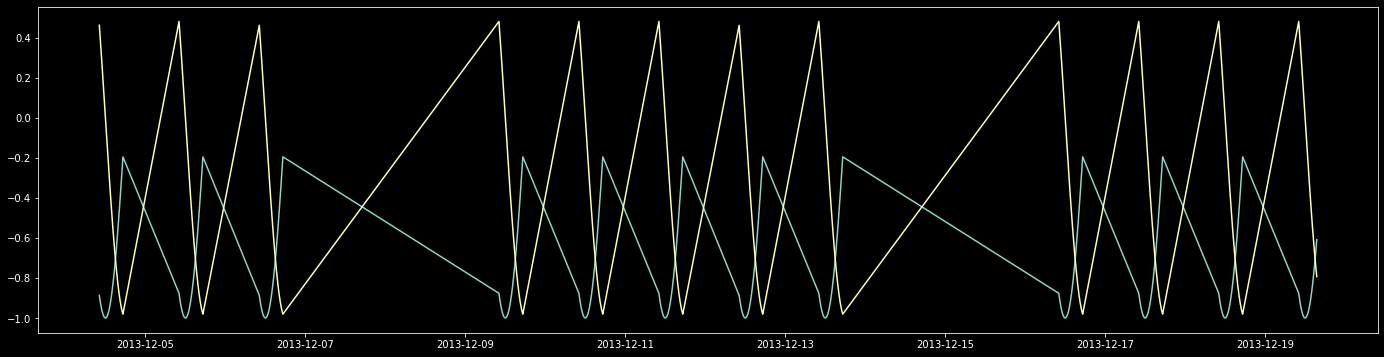

In [141]:
plt.figure(figsize=(24, 6))
plt.plot(data['time_cos'][:1000])
plt.plot(data['time_sin'][:1000])

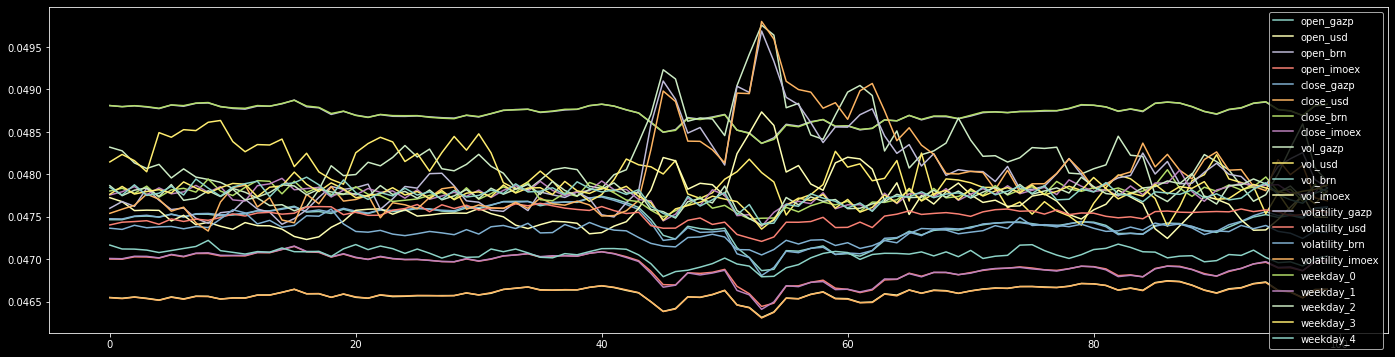

In [646]:
plt.figure(figsize=(24, 6))
plt.plot(x_attentions[:100])
plt.legend(data.columns)

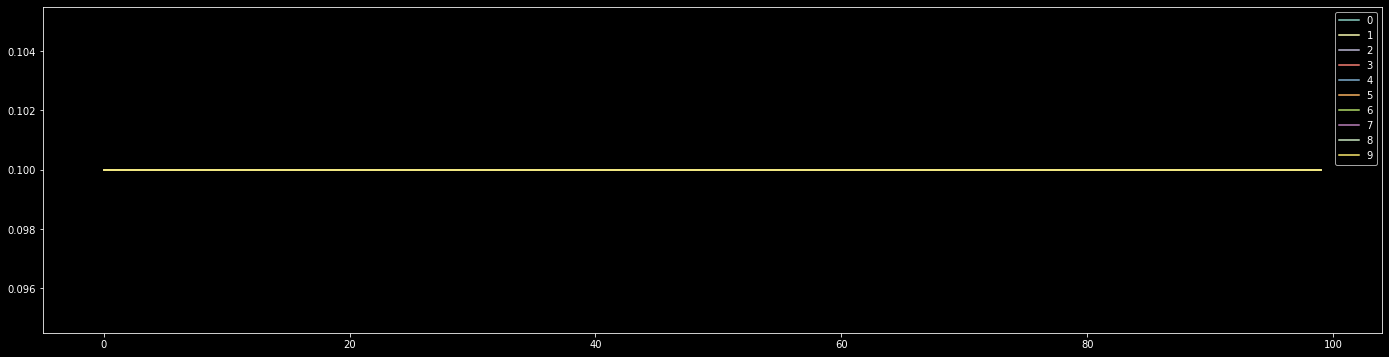

In [647]:
plt.figure(figsize=(24, 6))
plt.plot(t_attentions[:100])
plt.legend(range(10))

In [144]:
# data.loc[config['seq_length']:-1, 'predictions'] = full_preds

c:\python39\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


In [145]:
# data['return_pred'] = (data['predictions'] - data.shift()['predictions']) / data.shift()['predictions']

In [146]:
# data['return_pred_vs_actual'] = (data['predictions'] - data.shift()['close_gazp']) / data.shift()['close_gazp']

Text(0.5, 1.0, 'Predictions against target, full dataset')

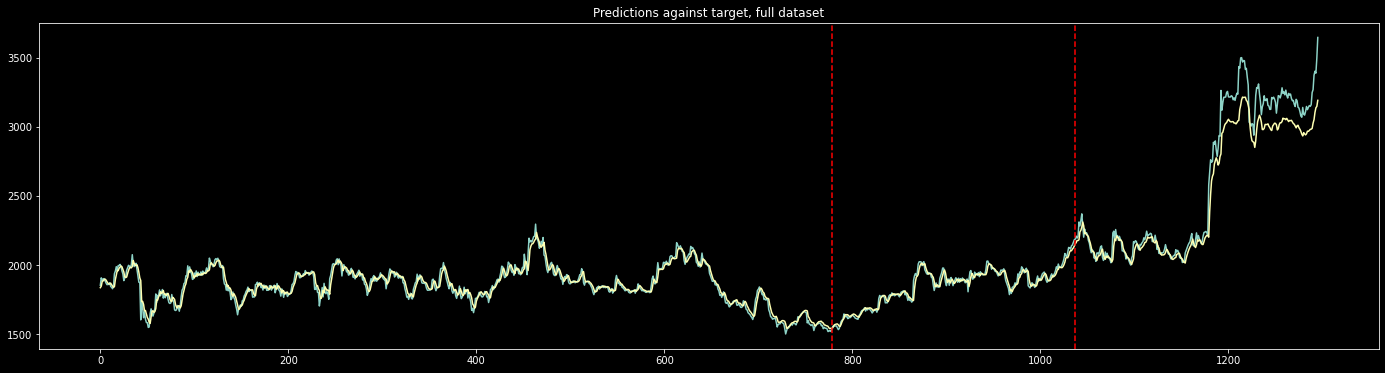

In [645]:
fig = plot_preds(full_preds, full_true, splits=(len(train_dataset), len(train_dataset)+len(val_dataset)))
plt.title('Predictions against target, full dataset')

Text(0.5, 1.0, 'Predictions against target, full dataset')

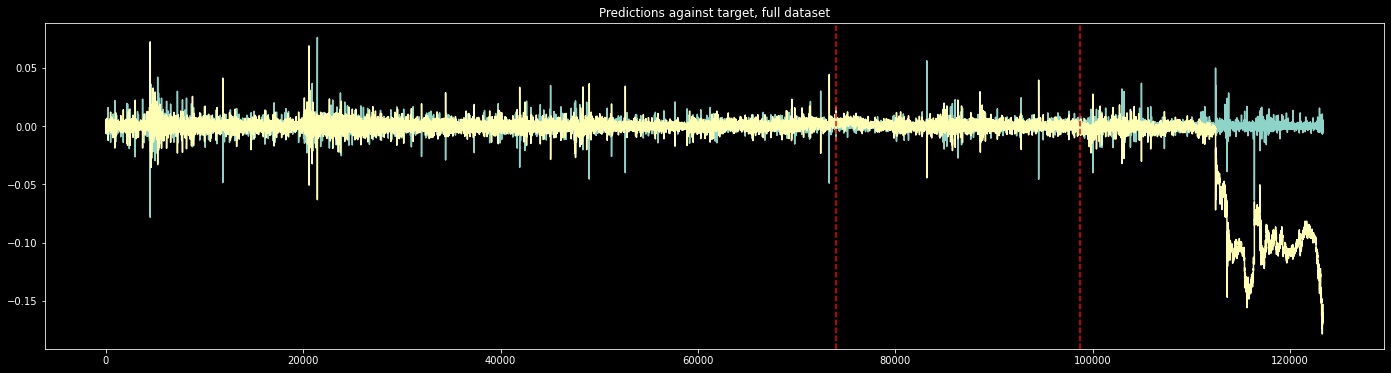

In [149]:
fig = plot_preds(
    data['return_pred_vs_actual'][config['seq_length']:].to_numpy(), 
    data['return_gazp'][config['seq_length']:].to_numpy(), 
    splits=(len(train_dataset), len(train_dataset)+len(val_dataset)))
plt.title('Predictions against target, full dataset')

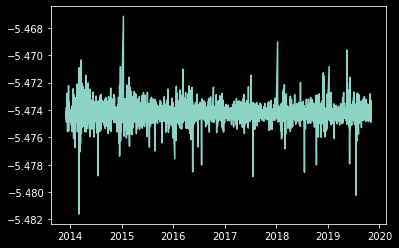

In [100]:
plt.plot((data['return_gazp'] - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5])

In [152]:
mean_squared_error(
    (data['return_pred_vs_actual'][config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5], 
    (data['return_gazp'][config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5]
)

7.440710613957586e-08

In [102]:
(data['return_pred_vs_actual'][config['seq_length']+len(train_dataset):-len(test_dataset)+1].to_numpy() - np.array(norm_stats)[0][5]) / np.array(norm_stats)[1][5]

array([-5.47461691, -5.4745441 , -5.47322134, ..., -5.47437701,
       -5.47440843, -5.47443562])

Text(0.5, 1.0, 'Predictions against target, full dataset')

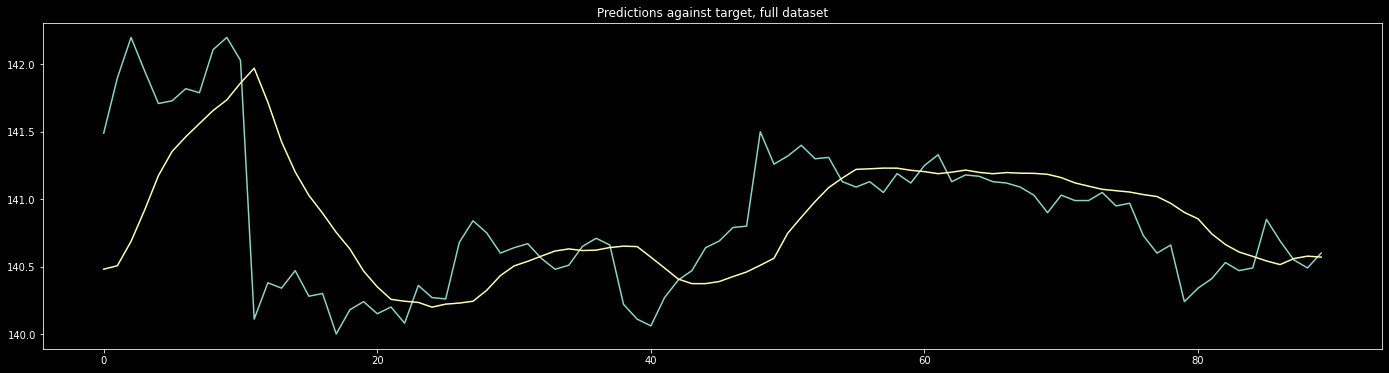

In [154]:
fig = plot_preds(data['predictions'][config['seq_length']+1000:1100].to_numpy(), data['close_gazp'][config['seq_length']+1000:1100].to_numpy())
plt.title('Predictions against target, full dataset')

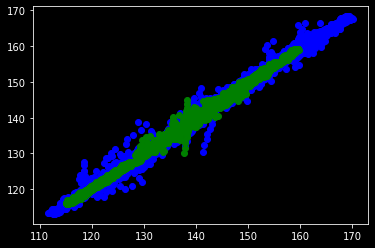

In [153]:
plt.scatter(
    data['close_gazp'][config['seq_length']:config['seq_length']+len(train_dataset)].to_numpy(), 
    data['predictions'][config['seq_length']:config['seq_length']+len(train_dataset)].to_numpy(),
    color='blue')
plt.scatter(
    data['close_gazp'][config['seq_length']+len(train_dataset):config['seq_length']+len(train_dataset)+len(val_dataset)].to_numpy(), 
    data['predictions'][config['seq_length']+len(train_dataset):config['seq_length']+len(train_dataset)+len(val_dataset)].to_numpy(),
    color='green')
# plt.scatter(
#     data['close'][config['seq_length']+len(train_dataset)+len(val_dataset):].to_numpy(), 
#     data['predictions'][config['seq_length']+len(train_dataset)+len(val_dataset):].to_numpy(),
#     color='red')

In [228]:
val_preds = trainer.predict(val_loader) * np.array(norm_stats)[1] + np.array(norm_stats)[0]
test_preds = trainer.predict(test_loader) * np.array(norm_stats)[1] + np.array(norm_stats)[0]

Text(0.5, 1.0, 'Predictions against target')

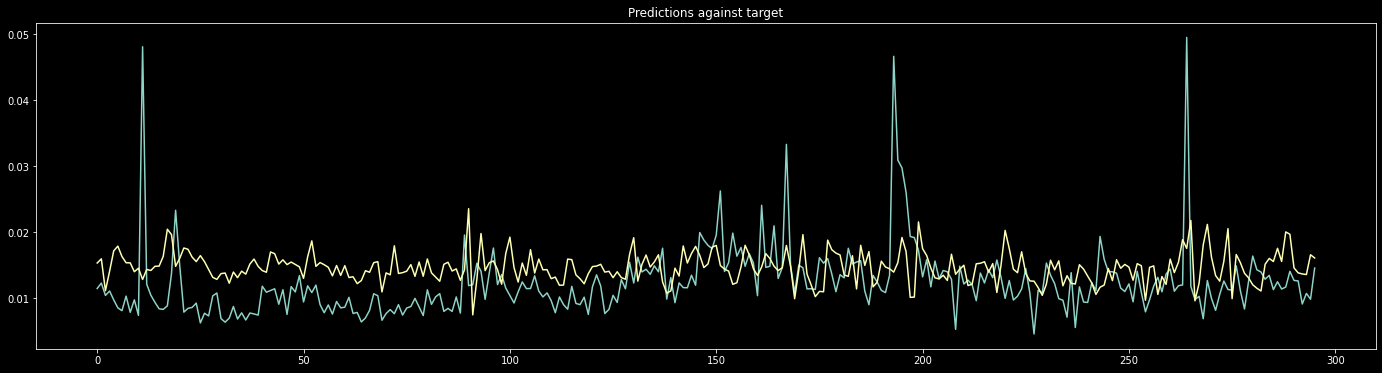

In [229]:
fig = plot_preds(val_preds[:, 4], data['volatility'][len(train_dataset)+config['seq_length']:len(train_dataset)+len(val_dataset)+config['seq_length']].to_numpy())
plt.title('Predictions against target')

In [ ]:
print('Validation')
print('previous item MSE |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], val_dataset.X[SEQ_LENGTH:, 0]))
print('train mean MSE    |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], np.repeat(train_target.mean(), len(val_dataset))))
print('validation MSE    |', mean_squared_error(val_dataset.y[SEQ_LENGTH:], val_preds))

Validation
previous item MSE | 0.75418323
train mean MSE    | 0.7425473620650748
validation MSE    | 3.0327671648757084


# xgb

In [88]:
def convert_to_lagged_df(dataset):
    x,y,target = dataset[0]
    num_lags = y.shape[0]
    num_predictors = x.shape[1]
    gen = (np.concatenate([target.numpy(), y.flatten().flip(0).numpy(), x.flip(0).flatten().numpy()]) for (x,y,target) in dataset)
    return pd.DataFrame(gen, columns=['y_target']+[f'y_lag{i+1}' for i in range(num_lags)]+[f'x{j}_lag{i+1}' for i in range(num_lags) for j in range(num_predictors)])

In [89]:
# full_dataset_df = convert_to_lagged_df(dataset)
train_dataset_df = convert_to_lagged_df(train_dataset)
val_dataset_df = convert_to_lagged_df(val_dataset)
test_dataset_df = convert_to_lagged_df(test_dataset)

In [90]:
full_dataset_df = pd.concat([train_dataset_df, val_dataset_df, test_dataset_df]).reset_index(drop=True)
traintest_dataset_df = pd.concat([train_dataset_df, val_dataset_df]).reset_index(drop=True)

In [91]:
train_x, train_target = train_dataset_df.iloc[:, 1:], train_dataset_df.iloc[:, 0]
val_x, val_target = val_dataset_df.iloc[:, 1:], val_dataset_df.iloc[:, 0]
test_x, test_target = test_dataset_df.iloc[:, 1:], test_dataset_df.iloc[:, 0]

In [92]:
full_x, full_target = full_dataset_df.iloc[:, 1:], full_dataset_df.iloc[:, 0]
traintest_x, traintest_target = traintest_dataset_df.iloc[:, 1:], traintest_dataset_df.iloc[:, 0]

In [93]:
import xgboost

In [94]:
xgb = xgboost.XGBClassifier(max_depth=10, n_estimators=1000)

In [95]:
xgb.fit(train_x, train_target.astype(np.int))

c:\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:05:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [96]:
val_pred = xgb.predict(val_x)

In [97]:
accuracy(val_pred, val_target.astype(np.int))

0.49606299212598426

In [204]:
mean_squared_error(val_target, val_pred) * 1e3

6.824913946783214

In [205]:
mean_squared_error(val_target, val_dataset_df.iloc[:, 1]) * 1e3

4.19802472417114

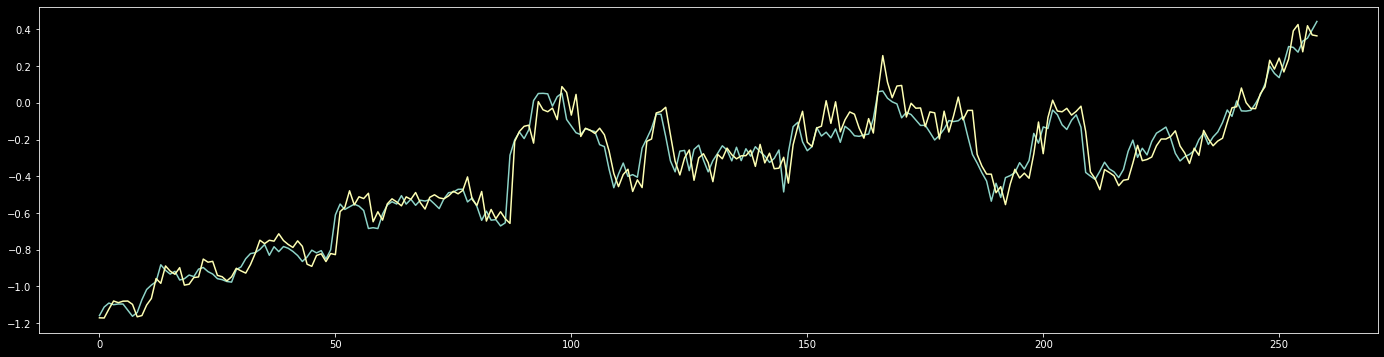

In [207]:
plot_preds(val_target, val_pred);

# arima

In [271]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [313]:
result = adfuller(traintest_target)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.304260
p-value: 0.014689


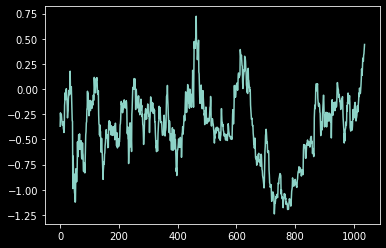

In [314]:
plt.plot(traintest_target)

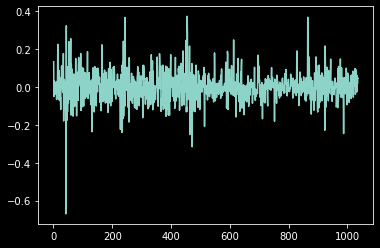

In [315]:
plt.plot(traintest_target.diff())

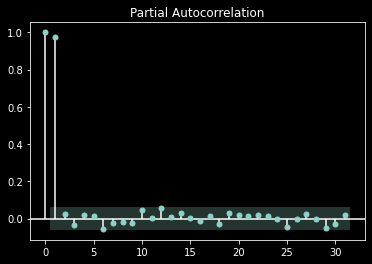

In [316]:
pacf = plot_pacf(traintest_target)

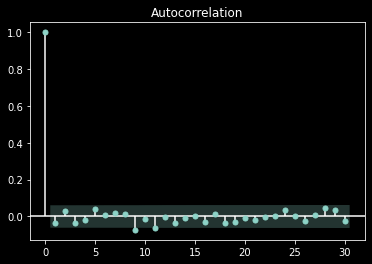

In [317]:
acf = plot_acf(traintest_target.diff()[1:], lags=30)

In [347]:
model = ARIMA(traintest_target, order=(10,1,0))
model_fit = model.fit()
prediction = model_fit.predict(start=len(train_dataset), end=len(train_dataset)+len(val_dataset)-1)

c:\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [335]:
# history = [x for x in train_target]
# prediction = []

# for y_true in val_target:
#     model = ARIMA(history, order=(10,1,0))
#     model_fit = model.fit()
#     y_pred = model_fit.forecast()[0]
#     prediction.append(y_pred)
#     history.append(y_true)

In [348]:
mean_squared_error(val_target, prediction) * 1e3

4.184500206719703

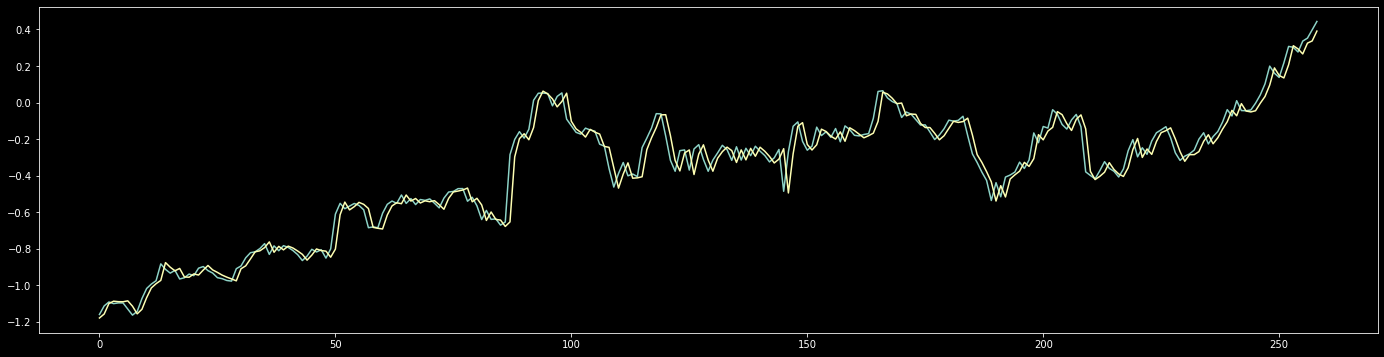

In [349]:
plot_preds(prediction.reset_index(drop=True), val_target);

In [50]:
from abc import ABC, abstractmethod

In [60]:
class Trainer(nn.Module):
    def __init__(self, model, criterion, metric, device=None):
        super().__init__()
        if device is not None:
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.logs = {}
        self.optimizer = None
        self.sceduler = None
        
        self.model = model.to(self.device)
        self.criterion = criterion
        self.metric = metric
    
    def forward(self, x, y):
        return self.model.forward(x, y)

    def log(self, name, value):
        if name not in self.logs:
            self.logs[name] = np.array([])
        if isinstance(value, float) or isinstance(value, int):
            self.logs[name] = np.append(self.logs[name], value)
        elif isinstance(value, np.ndarray):
            self.logs[name] = np.concatenate((self.logs[name], value))
    
    @staticmethod
    def _epoch_mean(array, loader_len):
        return array[-loader_len:].sum() / loader_len

    def _prepare_batch(self, batch):
        x, y, target  = batch
        x = x.to(self.device)
        y = y.to(self.device)
        target = target.to(self.device)
        return x, y, target
    
    def training_step(self, batch):
        x, y, target  = self._prepare_batch(batch)
        output = self.forward(x, y)
        loss = self.criterion(output, target)

        self.log('train_step_loss', loss.item())
        self.log('train_step_metric', float(self.metric(target.flatten().cpu(), output.detach().flatten().cpu())))
        return loss
    
    def validation_step(self, batch):
        x, y, target  = self._prepare_batch(batch)
        output = self.forward(x, y)
        loss = self.criterion(output, target)
        
        self.log('valid_step_loss', loss.item())
        self.log('valid_step_metric', float(self.metric(target.flatten().cpu(), output.detach().flatten().cpu())))
        return loss
    
    def prediction_step(self, batch):
        x, y, _ = self._prepare_batch(batch)
        output = self.forward(x, y)
        return output.cpu()
    
    def fit(self, train_loader, val_loader, epochs=10, verbose=True, stopper=None):
        if verbose: tqdm_ = tqdm
        else: tqdm_ = lambda x: x
        for epoch in tqdm_(range(epochs)):
            if verbose: print(f'{epoch+1} epoch:')

            self.train()
            for batch in tqdm_(train_loader):
                loss = self.training_step(batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            if self.sceduler is not None:
                self.sceduler.step()
            self.log(
                'train_epoch_loss', 
                self._epoch_mean(self.logs['train_step_loss'], len(train_loader)))
            self.log(
                'train_epoch_metric', 
                self._epoch_mean(self.logs['train_step_metric'], len(train_loader)))
            if verbose: 
                print(f"train loss {self.logs['train_epoch_loss'][-1]}")
                print(f"train {self.metric.__name__} {self.logs['train_epoch_metric'][-1]}")
                
            if val_loader is not None:
                self.eval()
                for batch in tqdm_(val_loader):
                    loss = self.validation_step(batch)
                self.log(
                    'valid_epoch_loss', 
                    self._epoch_mean(self.logs['valid_step_loss'], len(val_loader)))
                self.log(
                    'valid_epoch_metric', 
                    self._epoch_mean(self.logs['valid_step_metric'], len(val_loader)))
                if verbose: 
                    print(f"valid loss {self.logs['valid_epoch_loss'][-1]}")
                    print(f"valid {self.metric.__name__} {self.logs['valid_epoch_metric'][-1]}")
            if verbose: print('-'*80)
    
    def predict(self, data_loader, verbose=True):
        if verbose: tqdm_ = tqdm
        else: tqdm_ = lambda x: x
        ret = {
            'y_true': np.array([]),
            'y_pred': np.array([])
        }
        self.eval()
        for batch in tqdm_(data_loader):
            X, y, target  = batch
            output = self.prediction_step(batch)
            ret['y_pred'] = np.concatenate((ret['y_pred'], output.detach().numpy().flatten()))
            ret['y_true'] = np.concatenate((ret['y_true'], target.cpu().numpy().flatten()))
        return ret

    def plot_loss(self):
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('train loss')
        ax1.plot(self.logs['train_epoch_loss'])

        ax2 = ax1.twinx()
        ax2.set_ylabel('valid loss')
        ax2.plot(self.logs['valid_epoch_loss'], color='orange')

        fig.tight_layout()
        return fig
    
    def plot(self, x):
        return plt.plot(self.logs[x])

In [ ]:
    # def predict(self, data_loader, verbose=True):
    #     if verbose: tqdm_ = tqdm
    #     else: tqdm_ = lambda x: x
    #     ret = {
    #         'y_true': np.array([]),
    #         'y_pred': np.array([]),
    #         'x_attentions': [],
    #         't_attentions': []
    #     }
    #     self.eval()
    #     for batch in tqdm_(data_loader):
    #         X, y, target  = batch
    #         x_attention, t_attention = None, None
    #         output = self.prediction_step(batch)
    #         if isinstance(output, tuple) and len(output)==3:
    #             output, x_attention, t_attention = output
    #         ret['y_pred'] = np.concatenate((ret['y_pred'], output.detach().numpy().flatten()))
    #         ret['y_true'] = np.concatenate((ret['y_true'], target.cpu().numpy().flatten()))
    #         if x_attention is not None:
    #             ret['x_attentions'].append(x_attention.detach())
    #             ret['t_attentions'].append(t_attention.detach())
    #     if x_attention is not None:
    #         ret['x_attentions'] = torch.cat(ret['x_attentions'])
    #         ret['t_attentions'] = torch.cat(ret['t_attentions'])
    #     return ret

In [61]:
class LSTMTrainer(Trainer):
    # def __init__(self, model, criterion, metric):
    #     super().__init__(model, criterion, metric)
        # if device is not None:
        #     self.device = torch.device(device)
        # self.model = model.to(self.device)
        # self.criterion = criterion
        # self.metric = metric
        
    def forward(self, x, y):
        x = torch.cat((x, y), dim=2)
        return self.model.forward(x)
    
#     def training_step(self, batch):
#         x, y, target  = self._prepare_batch(batch)
#         # x = torch.cat((x, y), dim=2)
#         output = self.forward(x, y)
#         loss = self.criterion(output, target)

#         self.log('train_step_loss', loss.item())
#         self.log('train_step_metric', float(self.metric(target.flatten().cpu(), output.detach().flatten().cpu())))
#         return loss
    
#     def validation_step(self, batch):
#         x, y, target  = self._prepare_batch(batch)
#         # x = torch.cat((x, y), dim=2)
#         output = self.forward(x, y)
#         loss = self.criterion(output, target)
        
#         self.log('valid_step_loss', loss.item())
#         self.log('valid_step_metric', float(self.metric(target.flatten().cpu(), output.detach().flatten().cpu())))
#         return loss
    
#     def prediction_step(self, batch):
#         x, y, _ = self._prepare_batch(batch)
#         # x = torch.cat((x, y), dim=2)
#         output = self.forward(x, y)
#         return output.cpu()

In [62]:
trainer = LSTMTrainer(model, criterion, metric=mean_squared_error)

In [63]:
trainer

LSTMTrainer(
  (model): VanillaLSTM(
    (lstm): LSTM(12, 512, num_layers=2, batch_first=True, bidirectional=True)
    (fc_bloc): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Dropout(p=0, inplace=False)
      (2): ReLU()
    )
    (fc): Linear(in_features=30720, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)